# XGBoost + Optuna

In [1]:
# !pip install optuna
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import optuna 

### データの取り込み／前処理

In [2]:
df_date_data = pd.read_csv('../data/org/day.csv')
df_date_data.head()

instant      dteday  ...   registered   cnt
0        1  2011-01-01  ...          654   985
1        2  2011-01-02  ...          670   801
2        3  2011-01-03  ...         1229  1349
3        4  2011-01-04  ...         1454  1562
4        5  2011-01-05  ...         1518  1600

[5 rows x 16 columns]

In [3]:
used_columns = ['cnt', 'season', 'yr', 'mnth', 'holiday', 'weathersit', 'temp', 'hum', 'windspeed']
df = df_date_data.loc[:,used_columns]
df.head()

cnt  season  yr    ...          temp       hum  windspeed
0   985       1   0    ...      0.344167  0.805833   0.160446
1   801       1   0    ...      0.363478  0.696087   0.248539
2  1349       1   0    ...      0.196364  0.437273   0.248309
3  1562       1   0    ...      0.200000  0.590435   0.160296
4  1600       1   0    ...      0.226957  0.436957   0.186900

[5 rows x 9 columns]

In [4]:
ohe_columns = ['season', 'mnth', 'weathersit']
df_ohe = pd.get_dummies(df, columns=ohe_columns)

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

### Optunaによるパラメータチューニング
チューニング前の結果はhyperoptのNotebookを参照

In [6]:
# 以下のページのコードを参考に作成
# http://www.algo-fx-blog.com/xgboost-optuna-hyperparameter-tuning/

def opt(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 0, 1000),
    'max_depth': trial.suggest_int('max_depth', 1, 20),
    'eta': trial.suggest_discrete_uniform('gamma', 0.25, 0.5, 0.025),
    'gamma': trial.suggest_discrete_uniform('gamma', 0.5, 1, 0.05),
    'lambda': trial.suggest_discrete_uniform('lambda', 0.025, 1.0, 0.05),
    'alpha': trial.suggest_discrete_uniform('alpha', 0.1, 0.8, 0.05),
    'max_depth':  trial.suggest_int('max_depth', 1, 14),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
    'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
    'random_state': 0
    }
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    # 変数の格納
    dtrain = xgb.DMatrix(train_X, label=train_y)
    dvalid = xgb.DMatrix(test_X, label=test_y)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, 500,
                      evals=watchlist,
                      verbose_eval=True)
    pred_y = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration + 1)
    score = sqrt(mean_squared_error(test_y, pred_y))
    print("\tScore {0}\n\n".format(score))
    return score

In [7]:
# 最適化
study = optuna.create_study()
study.optimize(opt, n_trials=100)

[W 2019-04-13 00:24:33,936] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:24:33,944] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:24:33,947] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:24:33,951] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 725, 'max_depth': 15, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.5750000000000001, 'alpha': 0.45000000000000007, 'min_child_weight': 18, 'subsample': 0.7, 'colsample_bytree': 0.9, 'random_state': 0}
[00:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3711.64	train-rmse:3621.99
[00:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2781.47	train-rmse:2692.48
[00:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2094.9	train-rmse:2024.28
[00:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1614.66	train-rmse:1549.04
[00:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1309.32	train-rmse:1221.2

[00:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[51]	eval-rmse:740.779	train-rmse:344.207
[00:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=11
[52]	eval-rmse:737.876	train-rmse:340.756
[00:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:740.104	train-rmse:338.41
[00:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=12
[54]	eval-rmse:742.072	train-rmse:335.735
[00:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:743.997	train-rmse:332.568
[00:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[56]	eval-rmse:742.994	train-rmse:330.442
[00:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 ex

[00:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=14
[104]	eval-rmse:780.588	train-rmse:215.82
[00:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=15
[105]	eval-rmse:779.829	train-rmse:213.766
[00:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=11
[106]	eval-rmse:777.374	train-rmse:212.393
[00:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[107]	eval-rmse:779.427	train-rmse:210.522
[00:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[108]	eval-rmse:778.971	train-rmse:209.124
[00:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[109]	eval-rmse:780.426	train-rmse:206.659
[00:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[157]	eval-rmse:796.748	train-rmse:148.107
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:798.739	train-rmse:147.111
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[159]	eval-rmse:798.236	train-rmse:145.844
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:798.563	train-rmse:144.463
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:796.302	train-rmse:143.586
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=11
[162]	eval-rmse:797.87	train-rmse:142.583
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3

[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[210]	eval-rmse:799.888	train-rmse:104.893
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=11
[211]	eval-rmse:800.599	train-rmse:104.442
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[212]	eval-rmse:801.014	train-rmse:103.794
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[213]	eval-rmse:800.229	train-rmse:103.521
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[214]	eval-rmse:798.648	train-rmse:103.115
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[215]	eval-rmse:798.977	train-rmse:102.521
[00:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[263]	eval-rmse:808.886	train-rmse:74.474
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:809.072	train-rmse:73.8439
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[265]	eval-rmse:808.356	train-rmse:73.2169
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[266]	eval-rmse:807.81	train-rmse:72.5698
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[267]	eval-rmse:807.676	train-rmse:71.9738
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[268]	eval-rmse:807.785	train-rmse:71.5744
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 

[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=11
[316]	eval-rmse:813.683	train-rmse:53.0897
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=11
[317]	eval-rmse:813.7	train-rmse:52.8129
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:813.274	train-rmse:52.6557
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=12
[319]	eval-rmse:812.966	train-rmse:52.3154
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[320]	eval-rmse:813.435	train-rmse:52.088
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=11
[321]	eval-rmse:813.698	train-rmse:51.8647
[00:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[369]	eval-rmse:816.312	train-rmse:40.0963
[00:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=11
[370]	eval-rmse:816.232	train-rmse:39.8083
[00:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:816.319	train-rmse:39.5478
[00:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[372]	eval-rmse:816.555	train-rmse:39.2255
[00:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=11
[373]	eval-rmse:817.059	train-rmse:38.9385
[00:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[374]	eval-rmse:816.825	train-rmse:38.7286
[00:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[422]	eval-rmse:818.529	train-rmse:29.695
[00:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[423]	eval-rmse:817.975	train-rmse:29.5499
[00:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=15
[424]	eval-rmse:817.988	train-rmse:29.3646
[00:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[425]	eval-rmse:817.972	train-rmse:29.11
[00:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[426]	eval-rmse:817.787	train-rmse:29.0063
[00:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=14
[427]	eval-rmse:817.656	train-rmse:28.9074
[00:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3

[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[475]	eval-rmse:818.102	train-rmse:22.4203
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[476]	eval-rmse:818.371	train-rmse:22.2713
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=13
[477]	eval-rmse:818.07	train-rmse:22.2083
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[478]	eval-rmse:818.698	train-rmse:22.1081
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[479]	eval-rmse:818.655	train-rmse:21.9933
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[480]	eval-rmse:818.223	train-rmse:21.8567
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34

[I 2019-04-13 00:24:41,561] Finished trial#0 resulted in value: 819.1388323394797. Current best value is 819.1388323394797 with parameters: {'n_estimators': 725, 'max_depth': 15, 'gamma': 0.275, 'lambda': 0.5750000000000001, 'alpha': 0.45000000000000007, 'min_child_weight': 18, 'subsample': 0.7, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:24:41,571] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:24:41,583] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:24:41,591] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:24:41,597] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 370, 'max_depth': 1, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.125, 'alpha': 0.30000000000000004, 'min_child_weight': 11, 'subsample': 0.9, 'colsample_bytree': 0.5, 'random_state': 0}
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-rmse:3307.27	train-rmse:3198.48
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	eval-rmse:2315.37	train-rmse:2195.33
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	eval-rmse:1803.13	train-rmse:1688.4
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	eval-rmse:1505.86	train-rmse:1413.49
[00:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[4]	eval-rmse:1390.5	train-rmse:1283.01
[00:24:41] src/tree/up

[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[52]	eval-rmse:760.07	train-rmse:652.377
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[53]	eval-rmse:757.285	train-rmse:650.667
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[54]	eval-rmse:758.329	train-rmse:649.078
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[55]	eval-rmse:755.739	train-rmse:648.195
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[56]	eval-rmse:751.795	train-rmse:646.342
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[57]	eval-rmse:753.064	train-rmse:645.733
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 

[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[105]	eval-rmse:742.533	train-rmse:617.401
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	eval-rmse:740.464	train-rmse:617.13
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[107]	eval-rmse:738.568	train-rmse:616.728
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[108]	eval-rmse:739.596	train-rmse:616.65
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[109]	eval-rmse:740.686	train-rmse:616.074
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[110]	eval-rmse:740.776	train-rmse:615.816
[00:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[158]	eval-rmse:742.537	train-rmse:601.038
[00:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[159]	eval-rmse:742.259	train-rmse:600.835
[00:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[160]	eval-rmse:743.468	train-rmse:600.44
[00:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[161]	eval-rmse:743.43	train-rmse:600.201
[00:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[162]	eval-rmse:744.177	train-rmse:600.137
[00:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[163]	eval-rmse:744.395	train-rmse:599.519
[00:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[211]	eval-rmse:756.941	train-rmse:589.108
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[212]	eval-rmse:756.596	train-rmse:588.915
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[213]	eval-rmse:755.02	train-rmse:588.817
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[214]	eval-rmse:754.355	train-rmse:588.547
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[215]	eval-rmse:754.871	train-rmse:588.127
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[216]	eval-rmse:754.172	train-rmse:587.822
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[264]	eval-rmse:757.916	train-rmse:577.205
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[265]	eval-rmse:759.238	train-rmse:576.988
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[266]	eval-rmse:758.553	train-rmse:576.926
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[267]	eval-rmse:759.887	train-rmse:576.839
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[268]	eval-rmse:759.976	train-rmse:576.56
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[269]	eval-rmse:760.087	train-rmse:576.459
[00:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:761.645	train-rmse:567.56
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[318]	eval-rmse:761.192	train-rmse:567.299
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[319]	eval-rmse:760.227	train-rmse:567.086
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[320]	eval-rmse:760.019	train-rmse:566.969
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[321]	eval-rmse:760.121	train-rmse:566.739
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[322]	eval-rmse:758.259	train-rmse:566.561
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[370]	eval-rmse:762.464	train-rmse:559.17
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[371]	eval-rmse:761.319	train-rmse:558.932
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[372]	eval-rmse:761.214	train-rmse:558.744
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[373]	eval-rmse:761.292	train-rmse:558.615
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[374]	eval-rmse:760.401	train-rmse:558.504
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[375]	eval-rmse:758.98	train-rmse:558.397
[00:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[423]	eval-rmse:756.765	train-rmse:551.702
[00:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[424]	eval-rmse:756.759	train-rmse:551.45
[00:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:756.881	train-rmse:551.411
[00:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[426]	eval-rmse:757.156	train-rmse:551.284
[00:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	eval-rmse:757.61	train-rmse:551.139
[00:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[428]	eval-rmse:757.626	train-rmse:551.136
[00:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:756.438	train-rmse:544.62
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[477]	eval-rmse:757.709	train-rmse:544.365
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[478]	eval-rmse:756.604	train-rmse:544.248
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:756.962	train-rmse:544.279
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:757.326	train-rmse:544.174
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[481]	eval-rmse:757.658	train-rmse:543.9
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nod

[I 2019-04-13 00:24:47,775] Finished trial#1 resulted in value: 757.1746398336245. Current best value is 757.1746398336245 with parameters: {'n_estimators': 370, 'max_depth': 1, 'gamma': 0.4, 'lambda': 0.125, 'alpha': 0.30000000000000004, 'min_child_weight': 11, 'subsample': 0.9, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:24:47,778] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:24:47,786] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:24:47,790] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:24:47,794] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 915, 'max_depth': 13, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.925, 'alpha': 0.8, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 0}
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3715.65	train-rmse:3626.71
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2809.24	train-rmse:2706.27
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2159.08	train-rmse:2050.68
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1661.93	train-rmse:1567.66
[00:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1309.91	train-rmse:1219.41
[00:24:47] src/tree/updater

[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=13
[51]	eval-rmse:728.056	train-rmse:100.228
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=13
[52]	eval-rmse:729.078	train-rmse:95.8916
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=13
[53]	eval-rmse:729.284	train-rmse:92.7818
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=13
[54]	eval-rmse:730.917	train-rmse:90.316
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=13
[55]	eval-rmse:731.68	train-rmse:86.7582
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=13
[56]	eval-rmse:730.561	train-rmse:83.988
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=13
[103]	eval-rmse:735.806	train-rmse:21.198
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=13
[104]	eval-rmse:736.092	train-rmse:20.5542
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=13
[105]	eval-rmse:735.98	train-rmse:20.22
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=13
[106]	eval-rmse:735.761	train-rmse:19.7961
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=13
[107]	eval-rmse:735.721	train-rmse:19.2046
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[108]	eval-rmse:735.85	train-rmse:19.0835
[00:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 4 pruned nodes, max_depth=9
[155]	eval-rmse:734.464	train-rmse:6.19034
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=13
[156]	eval-rmse:734.363	train-rmse:6.03335
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=13
[157]	eval-rmse:734.435	train-rmse:5.86317
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=13
[158]	eval-rmse:734.468	train-rmse:5.61137
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[159]	eval-rmse:734.545	train-rmse:5.45115
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=13
[160]	eval-rmse:734.528	train-rmse:5.28395
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1

[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 2 pruned nodes, max_depth=13
[207]	eval-rmse:734.432	train-rmse:1.72381
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=13
[208]	eval-rmse:734.448	train-rmse:1.71124
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 2 pruned nodes, max_depth=13
[209]	eval-rmse:734.426	train-rmse:1.68312
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=13
[210]	eval-rmse:734.416	train-rmse:1.66809
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 6 pruned nodes, max_depth=11
[211]	eval-rmse:734.426	train-rmse:1.63065
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=13
[212]	eval-rmse:734.448	train-rmse:1.60236
[00:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 

[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 16 pruned nodes, max_depth=13
[259]	eval-rmse:734.452	train-rmse:0.635283
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 28 pruned nodes, max_depth=12
[260]	eval-rmse:734.455	train-rmse:0.626224
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=9
[261]	eval-rmse:734.447	train-rmse:0.619623
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes, max_depth=13
[262]	eval-rmse:734.45	train-rmse:0.613369
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 4 pruned nodes, max_depth=10
[263]	eval-rmse:734.448	train-rmse:0.60623
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 22 pruned nodes, max_depth=12
[264]	eval-rmse:734.45	train-rmse:0.593978
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end,

[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[311]	eval-rmse:734.447	train-rmse:0.409747
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[312]	eval-rmse:734.447	train-rmse:0.408778
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[313]	eval-rmse:734.447	train-rmse:0.408777
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[314]	eval-rmse:734.447	train-rmse:0.408781
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[315]	eval-rmse:734.447	train-rmse:0.408534
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[316]	eval-rmse:734.447	train-rmse:0.40652
[00:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4

[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[364]	eval-rmse:734.447	train-rmse:0.379072
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[365]	eval-rmse:734.447	train-rmse:0.378949
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[366]	eval-rmse:734.447	train-rmse:0.378947
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=7
[367]	eval-rmse:734.449	train-rmse:0.375854
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[368]	eval-rmse:734.449	train-rmse:0.375856
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:734.449	train-rmse:0.375876
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[417]	eval-rmse:734.454	train-rmse:0.359994
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[418]	eval-rmse:734.454	train-rmse:0.359987
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[419]	eval-rmse:734.454	train-rmse:0.35931
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[420]	eval-rmse:734.453	train-rmse:0.359172
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:734.453	train-rmse:0.359184
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[422]	eval-rmse:734.454	train-rmse:0.359157
[00:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 

[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[470]	eval-rmse:734.453	train-rmse:0.35375
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:734.453	train-rmse:0.35375
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=3
[472]	eval-rmse:734.455	train-rmse:0.352911
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:734.455	train-rmse:0.352926
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[474]	eval-rmse:734.455	train-rmse:0.352898
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[475]	eval-rmse:734.455	train-rmse:0.352897
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ex

[I 2019-04-13 00:24:52,683] Finished trial#2 resulted in value: 734.4581935775624. Current best value is 734.4581935775624 with parameters: {'n_estimators': 915, 'max_depth': 13, 'gamma': 0.275, 'lambda': 0.925, 'alpha': 0.8, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}.
[W 2019-04-13 00:24:52,688] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:24:52,691] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:24:52,705] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:24:52,709] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 560, 'max_depth': 1, 'eta': 0.375, 'gamma': 0.375, 'lambda': 0.925, 'alpha': 0.25, 'min_child_weight': 9, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-rmse:3449.97	train-rmse:3342.56
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	eval-rmse:2483.44	train-rmse:2362.5
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	eval-rmse:1919.94	train-rmse:1806.02
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	eval-rmse:1584.4	train-rmse:1484.32
[00:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[4]	eval-rmse:1421.96	train-rmse:1335.24
[00:24:52] src/tree/updater_prune.

[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[52]	eval-rmse:764.959	train-rmse:654.751
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[53]	eval-rmse:760.627	train-rmse:654.003
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[54]	eval-rmse:760.863	train-rmse:651.531
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[55]	eval-rmse:757.502	train-rmse:650.383
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[56]	eval-rmse:757.463	train-rmse:649.927
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[57]	eval-rmse:758.657	train-rmse:647.716
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes,

[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[105]	eval-rmse:748.546	train-rmse:615.225
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	eval-rmse:746.748	train-rmse:615.761
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[107]	eval-rmse:744.045	train-rmse:615.475
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[108]	eval-rmse:744.936	train-rmse:615.305
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[109]	eval-rmse:744.198	train-rmse:614.06
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[110]	eval-rmse:743.028	train-rmse:613.456
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[158]	eval-rmse:758.291	train-rmse:597.023
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[159]	eval-rmse:755.322	train-rmse:596.21
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[160]	eval-rmse:756.379	train-rmse:595.706
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[161]	eval-rmse:757.689	train-rmse:596.254
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[162]	eval-rmse:755.901	train-rmse:595.219
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[163]	eval-rmse:755.084	train-rmse:595.543
[00:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[211]	eval-rmse:764.054	train-rmse:583.243
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[212]	eval-rmse:760.659	train-rmse:582.103
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[213]	eval-rmse:760.556	train-rmse:582.325
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[214]	eval-rmse:759.593	train-rmse:581.672
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[215]	eval-rmse:756.474	train-rmse:581.469
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[216]	eval-rmse:757.319	train-rmse:580.995
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[264]	eval-rmse:755.861	train-rmse:572.106
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[265]	eval-rmse:757.18	train-rmse:571.825
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[266]	eval-rmse:757.496	train-rmse:571.378
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[267]	eval-rmse:758.54	train-rmse:571.251
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[268]	eval-rmse:759.176	train-rmse:571.135
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[269]	eval-rmse:757.047	train-rmse:570.832
[00:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:760.42	train-rmse:561.833
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[318]	eval-rmse:757.819	train-rmse:561.97
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[319]	eval-rmse:756.653	train-rmse:561.507
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[320]	eval-rmse:757.048	train-rmse:561.171
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[321]	eval-rmse:757.191	train-rmse:561.211
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[322]	eval-rmse:756.41	train-rmse:560.648
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nod

[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[370]	eval-rmse:758.841	train-rmse:550.776
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[371]	eval-rmse:759.484	train-rmse:550.481
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[372]	eval-rmse:759.155	train-rmse:550.449
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[373]	eval-rmse:758.286	train-rmse:550.115
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[374]	eval-rmse:760.025	train-rmse:550.533
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[375]	eval-rmse:761.035	train-rmse:550.032
[00:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[423]	eval-rmse:761.933	train-rmse:540.936
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[424]	eval-rmse:765.206	train-rmse:541.909
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:764.974	train-rmse:542.069
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[426]	eval-rmse:765.48	train-rmse:542.136
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	eval-rmse:765.585	train-rmse:541.804
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[428]	eval-rmse:765.478	train-rmse:541.512
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:745.86	train-rmse:533.184
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[477]	eval-rmse:747.499	train-rmse:532.785
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[478]	eval-rmse:746.46	train-rmse:532.828
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:742.838	train-rmse:533.146
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:743.292	train-rmse:532.665
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[481]	eval-rmse:743.491	train-rmse:532.298
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[I 2019-04-13 00:24:56,900] Finished trial#3 resulted in value: 750.156100912039. Current best value is 734.4581935775624 with parameters: {'n_estimators': 915, 'max_depth': 13, 'gamma': 0.275, 'lambda': 0.925, 'alpha': 0.8, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}.
[W 2019-04-13 00:24:56,909] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:24:56,913] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:24:56,919] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:24:56,928] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 192, 'max_depth': 4, 'eta': 0.42500000000000004, 'gamma': 0.42500000000000004, 'lambda': 0.8250000000000001, 'alpha': 0.75, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.8, 'random_state': 0}
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3042.97	train-rmse:2964.3
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:1926.91	train-rmse:1847.88
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:1349.75	train-rmse:1221.92
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1038.32	train-rmse:884.276
[00:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:883.88	train-r

[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[51]	eval-rmse:770.536	train-rmse:273.668
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:769.934	train-rmse:266.884
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:769.266	train-rmse:264.369
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:770.338	train-rmse:263.463
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:771.087	train-rmse:260.837
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:768.87	train-rmse:256.947
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra 

[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[104]	eval-rmse:771.749	train-rmse:140.64
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:772.134	train-rmse:139.241
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:768.006	train-rmse:137.021
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:765.916	train-rmse:135.808
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:764.691	train-rmse:133.694
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:765.023	train-rmse:133.248
[00:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[157]	eval-rmse:763.62	train-rmse:76.772
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:764.816	train-rmse:76.3394
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:764.199	train-rmse:75.6608
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:763.008	train-rmse:75.0677
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:762.738	train-rmse:74.2339
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:763.834	train-rmse:73.3929
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 e

[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[210]	eval-rmse:759.454	train-rmse:44.0751
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:759.242	train-rmse:43.8905
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:759.493	train-rmse:43.5519
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:759.36	train-rmse:43.2786
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:759.961	train-rmse:42.9789
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:760.118	train-rmse:42.4792
[00:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[263]	eval-rmse:762.536	train-rmse:27.7095
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:762.039	train-rmse:27.5782
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:761.795	train-rmse:27.2407
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:761.905	train-rmse:26.7968
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:761.775	train-rmse:26.4671
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:761.56	train-rmse:26.2668
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[316]	eval-rmse:761.08	train-rmse:17.0698
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:761.085	train-rmse:16.8784
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:760.831	train-rmse:16.7799
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:760.664	train-rmse:16.6053
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:760.856	train-rmse:16.4359
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:760.869	train-rmse:16.2986
[00:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 

[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[369]	eval-rmse:761.502	train-rmse:10.9355
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:761.325	train-rmse:10.8171
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:761.465	train-rmse:10.6325
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:761.244	train-rmse:10.5039
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:761.306	train-rmse:10.3978
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:761.491	train-rmse:10.3259
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26

[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[422]	eval-rmse:759.948	train-rmse:6.63387
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:759.981	train-rmse:6.57705
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:760.077	train-rmse:6.57163
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:759.939	train-rmse:6.40895
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:759.935	train-rmse:6.37355
[00:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:759.864	train-rmse:6.28504
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[475]	eval-rmse:760.012	train-rmse:3.9965
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:759.997	train-rmse:3.93903
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:760.009	train-rmse:3.91625
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:760.055	train-rmse:3.85458
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:760.044	train-rmse:3.81187
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:760.023	train-rmse:3.79851
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 

[I 2019-04-13 00:25:01,884] Finished trial#4 resulted in value: 759.8530804950788. Current best value is 734.4581935775624 with parameters: {'n_estimators': 915, 'max_depth': 13, 'gamma': 0.275, 'lambda': 0.925, 'alpha': 0.8, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}.
[W 2019-04-13 00:25:01,894] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:01,900] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:01,909] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:01,915] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 601, 'max_depth': 11, 'eta': 0.35, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9, 'random_state': 0}
[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-rmse:3349.86	train-rmse:3226.66
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[1]	eval-rmse:2267.62	train-rmse:2140
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[2]	eval-rmse:1576.08	train-rmse:1446.4
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[3]	eval-rmse:1172.13	train-rmse:1010.7
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[4]	eval-rmse:929.3	train-rmse:741.433
[00:25:02] src/tree/updater_pr

[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[51]	eval-rmse:713.838	train-rmse:63.1001
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[52]	eval-rmse:714.855	train-rmse:60.6444
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[53]	eval-rmse:714.555	train-rmse:58.1913
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=11
[54]	eval-rmse:712.926	train-rmse:56.4761
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[55]	eval-rmse:712.521	train-rmse:55.5054
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[56]	eval-rmse:713.157	train-rmse:53.8667
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

[00:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[104]	eval-rmse:714.044	train-rmse:13.0915
[00:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[105]	eval-rmse:713.845	train-rmse:12.7012
[00:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=11
[106]	eval-rmse:713.689	train-rmse:12.4318
[00:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:713.959	train-rmse:12.0446
[00:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[108]	eval-rmse:713.966	train-rmse:11.8448
[00:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[109]	eval-rmse:713.957	train-rmse:11.4936
[00:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=11
[156]	eval-rmse:713.949	train-rmse:3.78727
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[157]	eval-rmse:714.026	train-rmse:3.76519
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[158]	eval-rmse:714.096	train-rmse:3.68134
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=11
[159]	eval-rmse:714.068	train-rmse:3.59251
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[160]	eval-rmse:713.972	train-rmse:3.48078
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=11
[161]	eval-rmse:713.974	train-rmse:3.45577
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=11
[208]	eval-rmse:713.774	train-rmse:1.74957
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=10
[209]	eval-rmse:713.75	train-rmse:1.71915
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 4 pruned nodes, max_depth=11
[210]	eval-rmse:713.733	train-rmse:1.66609
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nodes, max_depth=11
[211]	eval-rmse:713.699	train-rmse:1.62648
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 6 pruned nodes, max_depth=11
[212]	eval-rmse:713.715	train-rmse:1.61057
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=11
[213]	eval-rmse:713.711	train-rmse:1.60201
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[260]	eval-rmse:713.68	train-rmse:1.03449
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=6
[261]	eval-rmse:713.672	train-rmse:1.03346
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 16 pruned nodes, max_depth=1
[262]	eval-rmse:713.675	train-rmse:1.03324
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[263]	eval-rmse:713.669	train-rmse:1.0257
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=5
[264]	eval-rmse:713.678	train-rmse:1.02669
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[265]	eval-rmse:713.673	train-rmse:1.01677
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 12 pruned nodes, max_depth=3
[312]	eval-rmse:713.67	train-rmse:0.683406
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=6
[313]	eval-rmse:713.669	train-rmse:0.669354
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[314]	eval-rmse:713.66	train-rmse:0.664483
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[315]	eval-rmse:713.66	train-rmse:0.656665
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=6
[316]	eval-rmse:713.664	train-rmse:0.656764
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:713.662	train-rmse:0.654709
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[364]	eval-rmse:713.646	train-rmse:0.475599
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[365]	eval-rmse:713.645	train-rmse:0.473229
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[366]	eval-rmse:713.643	train-rmse:0.473637
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[367]	eval-rmse:713.648	train-rmse:0.474763
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=6
[368]	eval-rmse:713.648	train-rmse:0.471043
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[369]	eval-rmse:713.648	train-rmse:0.471053
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[417]	eval-rmse:713.647	train-rmse:0.427707
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[418]	eval-rmse:713.647	train-rmse:0.427721
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[419]	eval-rmse:713.647	train-rmse:0.42771
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[420]	eval-rmse:713.646	train-rmse:0.428447
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[421]	eval-rmse:713.646	train-rmse:0.42628
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[422]	eval-rmse:713.646	train-rmse:0.426279
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 ex

[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[470]	eval-rmse:713.652	train-rmse:0.399357
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[471]	eval-rmse:713.652	train-rmse:0.399359
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[472]	eval-rmse:713.653	train-rmse:0.399624
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[473]	eval-rmse:713.653	train-rmse:0.399591
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[474]	eval-rmse:713.652	train-rmse:0.395094
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[475]	eval-rmse:713.652	train-rmse:0.395095
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:25:07,371] Finished trial#5 resulted in value: 713.6557016021255. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:07,380] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:07,390] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:07,396] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:07,401] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 399, 'max_depth': 1, 'eta': 0.375, 'gamma': 0.375, 'lambda': 0.17500000000000002, 'alpha': 0.25, 'min_child_weight': 4, 'subsample': 0.7, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-rmse:3425.86	train-rmse:3317.7
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	eval-rmse:2467.14	train-rmse:2345.87
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	eval-rmse:1917.37	train-rmse:1798.67
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	eval-rmse:1578.96	train-rmse:1479.13
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[4]	eval-rmse:1414.29	train-rmse:1328.42
[00:25:07] src/tree

[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[52]	eval-rmse:765.266	train-rmse:653.307
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[53]	eval-rmse:764.469	train-rmse:652.228
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[54]	eval-rmse:761.403	train-rmse:650.63
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[55]	eval-rmse:758.821	train-rmse:647.9
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[56]	eval-rmse:760.275	train-rmse:647.93
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[57]	eval-rmse:762.341	train-rmse:646.126
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 p

[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[105]	eval-rmse:745.371	train-rmse:604.415
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	eval-rmse:748.744	train-rmse:604.121
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[107]	eval-rmse:748.313	train-rmse:603.538
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[108]	eval-rmse:749.514	train-rmse:603.208
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[109]	eval-rmse:745.242	train-rmse:602.535
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[110]	eval-rmse:744.898	train-rmse:600.827
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[158]	eval-rmse:744.611	train-rmse:585.707
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[159]	eval-rmse:743.634	train-rmse:585.33
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[160]	eval-rmse:743.429	train-rmse:585.056
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[161]	eval-rmse:742.894	train-rmse:585.032
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[162]	eval-rmse:741.834	train-rmse:584.246
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[163]	eval-rmse:743.144	train-rmse:583.482
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[211]	eval-rmse:756.331	train-rmse:570.682
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[212]	eval-rmse:754.567	train-rmse:570.463
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[213]	eval-rmse:753.816	train-rmse:570.225
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[214]	eval-rmse:753.846	train-rmse:570.217
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[215]	eval-rmse:753.228	train-rmse:569.37
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[216]	eval-rmse:751.904	train-rmse:568.683
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[264]	eval-rmse:760.971	train-rmse:556.735
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[265]	eval-rmse:766.489	train-rmse:556.635
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[266]	eval-rmse:767.892	train-rmse:556.322
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[267]	eval-rmse:768.33	train-rmse:556.187
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[268]	eval-rmse:768.376	train-rmse:556.053
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[269]	eval-rmse:768.047	train-rmse:556.078
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:767.369	train-rmse:547.255
[00:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[318]	eval-rmse:766.901	train-rmse:547.205
[00:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[319]	eval-rmse:766.679	train-rmse:546.915
[00:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[320]	eval-rmse:772.277	train-rmse:546.033
[00:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[321]	eval-rmse:773.196	train-rmse:545.319
[00:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[322]	eval-rmse:771.554	train-rmse:545.315
[00:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[370]	eval-rmse:766.936	train-rmse:536.085
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[371]	eval-rmse:767.173	train-rmse:535.934
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[372]	eval-rmse:765.782	train-rmse:535.999
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[373]	eval-rmse:765.033	train-rmse:535.933
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[374]	eval-rmse:765.744	train-rmse:535.987
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[375]	eval-rmse:765.485	train-rmse:535.551
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[423]	eval-rmse:774.764	train-rmse:527.06
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[424]	eval-rmse:775.745	train-rmse:527.584
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:776.129	train-rmse:526.924
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[426]	eval-rmse:775.997	train-rmse:526.58
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	eval-rmse:775.898	train-rmse:526.105
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[428]	eval-rmse:777.015	train-rmse:525.876
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:779.783	train-rmse:521.072
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[477]	eval-rmse:782.246	train-rmse:521.27
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[478]	eval-rmse:780.849	train-rmse:520.429
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:778.294	train-rmse:520.465
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:781.018	train-rmse:520.537
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[481]	eval-rmse:780.087	train-rmse:519.87
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[I 2019-04-13 00:25:12,190] Finished trial#6 resulted in value: 786.0934508617344. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:12,196] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:12,202] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:12,205] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:12,210] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 170, 'max_depth': 6, 'eta': 0.35, 'gamma': 0.35, 'lambda': 0.225, 'alpha': 0.15000000000000002, 'min_child_weight': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3375.26	train-rmse:3264.71
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2284	train-rmse:2189.61
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1616.3	train-rmse:1510.8
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1206.01	train-rmse:1084.27
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:976.216	train-rmse:817.622
[00:25:12] src/tree

[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:718.889	train-rmse:196.464
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:719.102	train-rmse:193.822
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:718.378	train-rmse:189.679
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:719.725	train-rmse:188.727
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:723.327	train-rmse:186.711
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:723.981	train-rmse:182.936
[00:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra

[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:733.565	train-rmse:90.8086
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:733.241	train-rmse:88.5687
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:733.244	train-rmse:87.5037
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:732.435	train-rmse:86.3639
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-rmse:733.21	train-rmse:85.3243
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-rmse:733.198	train-rmse:84.0088
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 

[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:734.538	train-rmse:46.2662
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:734.602	train-rmse:45.2982
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[160]	eval-rmse:734.592	train-rmse:45.0109
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:734.496	train-rmse:44.5495
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:734.638	train-rmse:44.1814
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:734.79	train-rmse:43.3096
[00:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 

[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:732.983	train-rmse:24.6211
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:732.838	train-rmse:24.2127
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:732.421	train-rmse:23.8135
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:732.343	train-rmse:23.5054
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:732.526	train-rmse:23.1873
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[216]	eval-rmse:733.13	train-rmse:23.0491
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 

[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[264]	eval-rmse:733.436	train-rmse:13.1697
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[265]	eval-rmse:733.395	train-rmse:13.0261
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[266]	eval-rmse:733.385	train-rmse:12.9494
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[267]	eval-rmse:733.208	train-rmse:12.6611
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[268]	eval-rmse:733.137	train-rmse:12.5549
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[269]	eval-rmse:733.019	train-rmse:12.4894
[00:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38

[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[317]	eval-rmse:732.959	train-rmse:7.15534
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[318]	eval-rmse:732.956	train-rmse:7.11622
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[319]	eval-rmse:732.897	train-rmse:7.03341
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[320]	eval-rmse:732.892	train-rmse:6.96528
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[321]	eval-rmse:732.982	train-rmse:6.91633
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[322]	eval-rmse:732.954	train-rmse:6.8569
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 

[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[370]	eval-rmse:732.351	train-rmse:3.89157
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[371]	eval-rmse:732.372	train-rmse:3.85317
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[372]	eval-rmse:732.388	train-rmse:3.82474
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[373]	eval-rmse:732.394	train-rmse:3.75932
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[374]	eval-rmse:732.41	train-rmse:3.70717
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[375]	eval-rmse:732.465	train-rmse:3.64739
[00:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 

[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[423]	eval-rmse:732.4	train-rmse:2.1562
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[424]	eval-rmse:732.406	train-rmse:2.12493
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:732.397	train-rmse:2.09902
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[426]	eval-rmse:732.394	train-rmse:2.04967
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[427]	eval-rmse:732.388	train-rmse:2.0351
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[428]	eval-rmse:732.345	train-rmse:2.02115
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 ext

[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[476]	eval-rmse:732.194	train-rmse:1.24593
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[477]	eval-rmse:732.183	train-rmse:1.22947
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=6
[478]	eval-rmse:732.192	train-rmse:1.22166
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[479]	eval-rmse:732.195	train-rmse:1.19096
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=6
[480]	eval-rmse:732.206	train-rmse:1.18196
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[481]	eval-rmse:732.22	train-rmse:1.16433
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[I 2019-04-13 00:25:16,590] Finished trial#7 resulted in value: 732.1845812005. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:16,595] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:16,600] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:16,602] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:16,610] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 886, 'max_depth': 19, 'eta': 0.325, 'gamma': 0.325, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.7, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3483.64	train-rmse:3395.44
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2476.23	train-rmse:2390.89
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1832.53	train-rmse:1727.18
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1414.1	train-rmse:1294.66
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[4]	eval-rmse:1130.66	train-rmse:1012.01
[00:25:16] sr

[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=19
[51]	eval-rmse:718.961	train-rmse:112.213
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=14
[52]	eval-rmse:717.023	train-rmse:109.165
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=16
[53]	eval-rmse:713.174	train-rmse:105.952
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:714.133	train-rmse:105.129
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=19
[55]	eval-rmse:713.207	train-rmse:101.864
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=14
[56]	eval-rmse:711.276	train-rmse:99.7905
[00:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=14
[103]	eval-rmse:724.168	train-rmse:27.2574
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=17
[104]	eval-rmse:724.769	train-rmse:26.245
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=16
[105]	eval-rmse:724.754	train-rmse:25.4974
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=19
[106]	eval-rmse:724.002	train-rmse:25.0044
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=17
[107]	eval-rmse:724.29	train-rmse:24.5091
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=8
[108]	eval-rmse:724.299	train-rmse:24.2954
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[155]	eval-rmse:725.14	train-rmse:8.1448
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=19
[156]	eval-rmse:725.171	train-rmse:7.98786
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=17
[157]	eval-rmse:725.047	train-rmse:7.70615
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=16
[158]	eval-rmse:725.069	train-rmse:7.53095
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=19
[159]	eval-rmse:724.954	train-rmse:7.39592
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=19
[160]	eval-rmse:725.098	train-rmse:7.30241
[00:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 4 pruned nodes, max_depth=19
[207]	eval-rmse:725.33	train-rmse:2.76416
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=17
[208]	eval-rmse:725.327	train-rmse:2.71498
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 4 pruned nodes, max_depth=16
[209]	eval-rmse:725.279	train-rmse:2.67458
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 6 pruned nodes, max_depth=15
[210]	eval-rmse:725.299	train-rmse:2.61704
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 4 pruned nodes, max_depth=15
[211]	eval-rmse:725.293	train-rmse:2.57704
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 6 pruned nodes, max_depth=14
[212]	eval-rmse:725.3	train-rmse:2.54234
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 12 pruned nodes, max_depth=19
[259]	eval-rmse:725.373	train-rmse:1.0302
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 16 pruned nodes, max_depth=17
[260]	eval-rmse:725.358	train-rmse:1.01101
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 12 pruned nodes, max_depth=11
[261]	eval-rmse:725.375	train-rmse:1.00151
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=16
[262]	eval-rmse:725.364	train-rmse:0.986628
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=18
[263]	eval-rmse:725.376	train-rmse:0.980816
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 8 pruned nodes, max_depth=19
[264]	eval-rmse:725.368	train-rmse:0.966698
[00:25:18] src/tree/updater_prune.cc:74: tree pruning end, 

[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[311]	eval-rmse:725.393	train-rmse:0.544702
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=6
[312]	eval-rmse:725.395	train-rmse:0.539291
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=11
[313]	eval-rmse:725.392	train-rmse:0.533026
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[314]	eval-rmse:725.391	train-rmse:0.5318
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 18 pruned nodes, max_depth=8
[315]	eval-rmse:725.389	train-rmse:0.5279
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 10 pruned nodes, max_depth=9
[316]	eval-rmse:725.386	train-rmse:0.522972
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=5
[363]	eval-rmse:725.385	train-rmse:0.446104
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[364]	eval-rmse:725.382	train-rmse:0.446141
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[365]	eval-rmse:725.379	train-rmse:0.444141
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[366]	eval-rmse:725.38	train-rmse:0.443804
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=5
[367]	eval-rmse:725.379	train-rmse:0.442332
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 12 pruned nodes, max_depth=7
[368]	eval-rmse:725.383	train-rmse:0.437683
[00:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[416]	eval-rmse:725.38	train-rmse:0.401836
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=8
[417]	eval-rmse:725.382	train-rmse:0.39688
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[418]	eval-rmse:725.382	train-rmse:0.396991
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[419]	eval-rmse:725.382	train-rmse:0.397066
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[420]	eval-rmse:725.381	train-rmse:0.396803
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:725.381	train-rmse:0.396808
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[469]	eval-rmse:725.385	train-rmse:0.385922
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[470]	eval-rmse:725.389	train-rmse:0.384298
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:725.389	train-rmse:0.384311
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[472]	eval-rmse:725.389	train-rmse:0.384297
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:725.389	train-rmse:0.38437
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[474]	eval-rmse:725.39	train-rmse:0.384065
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[I 2019-04-13 00:25:20,947] Finished trial#8 resulted in value: 725.391987723373. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:20,955] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:20,959] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:20,964] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:20,972] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 273, 'max_depth': 8, 'eta': 0.42500000000000004, 'gamma': 0.42500000000000004, 'lambda': 0.775, 'alpha': 0.75, 'min_child_weight': 11, 'subsample': 0.9, 'colsample_bytree': 0.9, 'random_state': 0}
[00:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3045.86	train-rmse:2925.25
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:1910.11	train-rmse:1791.05
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1287.95	train-rmse:1165.07
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1015.7	train-rmse:835.001
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:879.512	train-rmse:657.326

[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:743.067	train-rmse:145.076
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:740.112	train-rmse:142.034
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:736.944	train-rmse:139.338
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:735.542	train-rmse:136.581
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[56]	eval-rmse:736.645	train-rmse:134.503
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[57]	eval-rmse:736.167	train-rmse:131.198
[00:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra

[00:25:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[105]	eval-rmse:755.638	train-rmse:47.7113
[00:25:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[106]	eval-rmse:756.492	train-rmse:46.9453
[00:25:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[107]	eval-rmse:755.984	train-rmse:46.1875
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:755.672	train-rmse:45.9757
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:756.092	train-rmse:45.1025
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[110]	eval-rmse:756.182	train-rmse:44.2394
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48

[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[158]	eval-rmse:755.809	train-rmse:19.9062
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[159]	eval-rmse:755.791	train-rmse:19.7879
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[160]	eval-rmse:756.225	train-rmse:19.2556
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[161]	eval-rmse:756.437	train-rmse:18.9378
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[162]	eval-rmse:756.331	train-rmse:18.4835
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[163]	eval-rmse:756.007	train-rmse:18.2004
[00:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40

[00:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:755.804	train-rmse:8.39893
[00:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[212]	eval-rmse:755.801	train-rmse:8.2551
[00:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[213]	eval-rmse:755.788	train-rmse:8.20823
[00:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[214]	eval-rmse:755.78	train-rmse:8.10163
[00:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[215]	eval-rmse:755.722	train-rmse:7.93343
[00:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[216]	eval-rmse:755.705	train-rmse:7.7842
[00:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 ex

[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:754.64	train-rmse:3.87684
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[265]	eval-rmse:754.652	train-rmse:3.83657
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:754.638	train-rmse:3.76809
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=8
[267]	eval-rmse:754.687	train-rmse:3.74282
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[268]	eval-rmse:754.687	train-rmse:3.70757
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[269]	eval-rmse:754.751	train-rmse:3.68509
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 

[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 4 pruned nodes, max_depth=8
[317]	eval-rmse:754.633	train-rmse:2.02175
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:754.599	train-rmse:1.98838
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=8
[319]	eval-rmse:754.602	train-rmse:1.9669
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:754.611	train-rmse:1.94871
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=8
[321]	eval-rmse:754.625	train-rmse:1.93314
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[322]	eval-rmse:754.621	train-rmse:1.91038
[00:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 

[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[370]	eval-rmse:754.598	train-rmse:0.988903
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=8
[371]	eval-rmse:754.602	train-rmse:0.976263
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=8
[372]	eval-rmse:754.609	train-rmse:0.957182
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=8
[373]	eval-rmse:754.604	train-rmse:0.943977
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=8
[374]	eval-rmse:754.602	train-rmse:0.934005
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=8
[375]	eval-rmse:754.609	train-rmse:0.919682
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[422]	eval-rmse:754.607	train-rmse:0.69284
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:754.607	train-rmse:0.692836
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=6
[424]	eval-rmse:754.611	train-rmse:0.690646
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 30 pruned nodes, max_depth=8
[425]	eval-rmse:754.607	train-rmse:0.683816
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[426]	eval-rmse:754.608	train-rmse:0.678684
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=5
[427]	eval-rmse:754.611	train-rmse:0.677275
[00:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[475]	eval-rmse:754.617	train-rmse:0.638973
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=8
[476]	eval-rmse:754.609	train-rmse:0.632081
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=6
[477]	eval-rmse:754.607	train-rmse:0.629487
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[478]	eval-rmse:754.606	train-rmse:0.629471
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:754.608	train-rmse:0.629888
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:754.606	train-rmse:0.629277
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[I 2019-04-13 00:25:28,248] Finished trial#9 resulted in value: 754.6106516387244. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:28,261] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:28,265] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:28,272] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:28,279] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 614, 'max_depth': 15, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.025, 'alpha': 0.65, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3824.38	train-rmse:3725.8
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2944.76	train-rmse:2853.82
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:2323.13	train-rmse:2225.36
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1877.98	train-rmse:1782.01
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:1551.88	train-rmse:1447.51
[00:25:28] src/tree/updater_

[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:754.681	train-rmse:435.688
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:756.346	train-rmse:430.496
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:755.126	train-rmse:429.461
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:752.944	train-rmse:425.758
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:746.641	train-rmse:422.488
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:751.514	train-rmse:420.541
[00:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra

[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:761.805	train-rmse:319.965
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:759.309	train-rmse:317.099
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[107]	eval-rmse:758.865	train-rmse:315.441
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:760.897	train-rmse:314.544
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:759.23	train-rmse:311.74
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[110]	eval-rmse:759.559	train-rmse:309.303
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 e

[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:774.081	train-rmse:249.549
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[159]	eval-rmse:775.692	train-rmse:248.412
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[160]	eval-rmse:775.853	train-rmse:247.458
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[161]	eval-rmse:773.217	train-rmse:245.721
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:775.254	train-rmse:245.778
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[163]	eval-rmse:778.806	train-rmse:243.737
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:783.168	train-rmse:193.721
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[212]	eval-rmse:786.245	train-rmse:193.318
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:784.748	train-rmse:193.141
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[214]	eval-rmse:783.872	train-rmse:192.225
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[215]	eval-rmse:780.925	train-rmse:190.849
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:782.398	train-rmse:189.824
[00:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3

[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:798.326	train-rmse:152.572
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:799.252	train-rmse:152.227
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[266]	eval-rmse:799.023	train-rmse:151.966
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[267]	eval-rmse:799.401	train-rmse:150.918
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[268]	eval-rmse:798.306	train-rmse:150.75
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[269]	eval-rmse:795.544	train-rmse:150.18
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[317]	eval-rmse:806.941	train-rmse:121.25
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:806.565	train-rmse:120.539
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[319]	eval-rmse:806.485	train-rmse:120.076
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:807.246	train-rmse:119.693
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=11
[321]	eval-rmse:808.375	train-rmse:119.056
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[322]	eval-rmse:809.324	train-rmse:118.392
[00:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[370]	eval-rmse:811.572	train-rmse:99.3957
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=11
[371]	eval-rmse:809.962	train-rmse:99.0875
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[372]	eval-rmse:809.375	train-rmse:98.9599
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[373]	eval-rmse:809.563	train-rmse:98.1941
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:809.782	train-rmse:98.0499
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[375]	eval-rmse:809.682	train-rmse:97.8469
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:817.761	train-rmse:81.2238
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=12
[424]	eval-rmse:817.062	train-rmse:80.8965
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:816.749	train-rmse:80.7725
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[426]	eval-rmse:816.25	train-rmse:80.4185
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[427]	eval-rmse:815.982	train-rmse:79.8044
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:815.776	train-rmse:79.6986
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[476]	eval-rmse:816.848	train-rmse:67.1976
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=11
[477]	eval-rmse:817.207	train-rmse:66.865
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[478]	eval-rmse:818.051	train-rmse:66.4266
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[479]	eval-rmse:817.955	train-rmse:66.0093
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[480]	eval-rmse:817.682	train-rmse:65.8212
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[481]	eval-rmse:817.745	train-rmse:65.4423
[00:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[I 2019-04-13 00:25:32,115] Finished trial#10 resulted in value: 820.3406995872609. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:32,123] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:32,127] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:32,133] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:32,139] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 16, 'max_depth': 11, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.32500000000000007, 'alpha': 0.6, 'min_child_weight': 15, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3837.65	train-rmse:3737.52
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2956.26	train-rmse:2867.95
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:2339.9	train-rmse:2245.32
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1902.7	train-rmse:1806.59
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1568.64	train-rmse:1470.55
[00:25:32] src/tr

[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:747.889	train-rmse:450.496
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:747.464	train-rmse:447.436
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:745.569	train-rmse:446.729
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:745.427	train-rmse:443.081
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:744.668	train-rmse:440.584
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:744.896	train-rmse:438.17
[00:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra 

[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:767.949	train-rmse:340.62
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:763.601	train-rmse:339.458
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:762.332	train-rmse:338.022
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:763.706	train-rmse:337.113
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:763.437	train-rmse:334.972
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[110]	eval-rmse:763.767	train-rmse:332.832
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:775.579	train-rmse:273.042
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:780.704	train-rmse:272.316
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:777.855	train-rmse:271.155
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:773.77	train-rmse:270.633
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[162]	eval-rmse:774.235	train-rmse:269.881
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[163]	eval-rmse:777.712	train-rmse:268.713
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:772.334	train-rmse:223.393
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[212]	eval-rmse:772.939	train-rmse:222.802
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[213]	eval-rmse:773.805	train-rmse:222.47
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[214]	eval-rmse:770.73	train-rmse:221.95
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[215]	eval-rmse:770.033	train-rmse:220.954
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:771.104	train-rmse:219.977
[00:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 ex

[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:785.195	train-rmse:183.776
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[265]	eval-rmse:786.187	train-rmse:183.068
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:786.771	train-rmse:182.521
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:787.862	train-rmse:182.224
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[268]	eval-rmse:786.124	train-rmse:181.592
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:787.002	train-rmse:181.067
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[317]	eval-rmse:798.178	train-rmse:148.226
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:797.671	train-rmse:147.747
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[319]	eval-rmse:796.997	train-rmse:147.384
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:797.874	train-rmse:146.533
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[321]	eval-rmse:799.184	train-rmse:145.792
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[322]	eval-rmse:798.178	train-rmse:145.352
[00:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[370]	eval-rmse:798.077	train-rmse:122.364
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[371]	eval-rmse:797.483	train-rmse:122.174
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[372]	eval-rmse:798.315	train-rmse:122.157
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[373]	eval-rmse:799.742	train-rmse:121.58
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:800.293	train-rmse:121.515
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[375]	eval-rmse:799.69	train-rmse:121.359
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[423]	eval-rmse:800.15	train-rmse:103.35
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[424]	eval-rmse:799.052	train-rmse:102.642
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:799.016	train-rmse:102.41
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[426]	eval-rmse:800.316	train-rmse:102.285
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[427]	eval-rmse:799.843	train-rmse:101.873
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[428]	eval-rmse:799.411	train-rmse:101.919
[00:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 ex

[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[476]	eval-rmse:801.022	train-rmse:86.6449
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[477]	eval-rmse:799.969	train-rmse:86.3616
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=11
[478]	eval-rmse:800.068	train-rmse:85.8983
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:800.047	train-rmse:85.6769
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[480]	eval-rmse:800.781	train-rmse:85.6271
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[481]	eval-rmse:800.631	train-rmse:85.085
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3

[I 2019-04-13 00:25:36,459] Finished trial#11 resulted in value: 803.1541954061075. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:36,467] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:36,479] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:36,487] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:36,509] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 767, 'max_depth': 20, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.025, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=11
[0]	eval-rmse:3768.43	train-rmse:3717.91
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-rmse:2889.69	train-rmse:2831.04
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=16
[2]	eval-rmse:2298.33	train-rmse:2186.16
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=15
[3]	eval-rmse:1855.01	train-rmse:1712.74
[00:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=14
[4]	eval-rmse:1505.49	train-rmse:1345.22
[00:25:36] src/tree/u

[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=20
[51]	eval-rmse:822.486	train-rmse:49.9984
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=19
[52]	eval-rmse:822.991	train-rmse:46.3777
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=18
[53]	eval-rmse:824.117	train-rmse:44.0745
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:824.443	train-rmse:43.6863
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=20
[55]	eval-rmse:825.115	train-rmse:41.1167
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=19
[56]	eval-rmse:824.95	train-rmse:39.3027
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 12 pruned nodes, max_depth=16
[103]	eval-rmse:828.557	train-rmse:5.59958
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=16
[104]	eval-rmse:828.517	train-rmse:5.3027
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=20
[105]	eval-rmse:828.35	train-rmse:5.05604
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 4 pruned nodes, max_depth=20
[106]	eval-rmse:828.422	train-rmse:4.8751
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 6 pruned nodes, max_depth=20
[107]	eval-rmse:828.42	train-rmse:4.64261
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:828.386	train-rmse:4.63387
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[155]	eval-rmse:828.33	train-rmse:1.07162
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 22 pruned nodes, max_depth=15
[156]	eval-rmse:828.322	train-rmse:1.01983
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 34 pruned nodes, max_depth=13
[157]	eval-rmse:828.319	train-rmse:0.969876
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 46 pruned nodes, max_depth=10
[158]	eval-rmse:828.328	train-rmse:0.954356
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 26 pruned nodes, max_depth=13
[159]	eval-rmse:828.341	train-rmse:0.904021
[00:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 28 pruned nodes, max_depth=12
[160]	eval-rmse:828.319	train-rmse:0.852251
[00:25:37] src/tree/updater_prune.cc:74: tree pruning 

[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=9
[207]	eval-rmse:828.335	train-rmse:0.354881
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[208]	eval-rmse:828.335	train-rmse:0.354187
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[209]	eval-rmse:828.326	train-rmse:0.346825
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 16 pruned nodes, max_depth=1
[210]	eval-rmse:828.325	train-rmse:0.346329
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[211]	eval-rmse:828.321	train-rmse:0.343179
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[212]	eval-rmse:828.32	train-rmse:0.342912
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[259]	eval-rmse:828.316	train-rmse:0.293018
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[260]	eval-rmse:828.316	train-rmse:0.293038
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[261]	eval-rmse:828.316	train-rmse:0.293009
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[262]	eval-rmse:828.315	train-rmse:0.29109
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[263]	eval-rmse:828.316	train-rmse:0.289734
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=6
[264]	eval-rmse:828.324	train-rmse:0.286989
[00:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[312]	eval-rmse:828.312	train-rmse:0.276265
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[313]	eval-rmse:828.312	train-rmse:0.276297
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[314]	eval-rmse:828.312	train-rmse:0.276335
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[315]	eval-rmse:828.312	train-rmse:0.276322
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[316]	eval-rmse:828.312	train-rmse:0.276335
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[317]	eval-rmse:828.312	train-rmse:0.276388
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[365]	eval-rmse:828.306	train-rmse:0.268927
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[366]	eval-rmse:828.306	train-rmse:0.268895
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[367]	eval-rmse:828.306	train-rmse:0.268911
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[368]	eval-rmse:828.306	train-rmse:0.268959
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[369]	eval-rmse:828.306	train-rmse:0.268924
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[370]	eval-rmse:828.306	train-rmse:0.268911
[00:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0

[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[418]	eval-rmse:828.302	train-rmse:0.265275
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[419]	eval-rmse:828.302	train-rmse:0.265263
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[420]	eval-rmse:828.302	train-rmse:0.265251
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:828.302	train-rmse:0.265274
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[422]	eval-rmse:828.302	train-rmse:0.26524
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[423]	eval-rmse:828.302	train-rmse:0.265189
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:828.304	train-rmse:0.26213
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[472]	eval-rmse:828.304	train-rmse:0.262113
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:828.304	train-rmse:0.262114
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[474]	eval-rmse:828.304	train-rmse:0.262108
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[475]	eval-rmse:828.304	train-rmse:0.26213
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[476]	eval-rmse:828.304	train-rmse:0.26215
[00:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[I 2019-04-13 00:25:41,164] Finished trial#12 resulted in value: 828.31219707633. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:41,180] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:41,189] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:41,213] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:41,228] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 989, 'max_depth': 17, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.37500000000000006, 'alpha': 0.55, 'min_child_weight': 20, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3831.12	train-rmse:3732.48
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2970.84	train-rmse:2871.48
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:2367.95	train-rmse:2258.45
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1940.31	train-rmse:1818.67
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:1596.99	train-rmse:1482.67
[00:25:41] sr

[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:710.876	train-rmse:498.479
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:715.277	train-rmse:495.434
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:715.57	train-rmse:494.475
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:716.811	train-rmse:490.995
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:711.581	train-rmse:488.266
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:715.149	train-rmse:485.771
[00:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra 

[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:740.633	train-rmse:400.23
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:736.192	train-rmse:399.516
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:732.663	train-rmse:398.705
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:733.418	train-rmse:397.971
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-rmse:735.616	train-rmse:396.302
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[110]	eval-rmse:738.237	train-rmse:391.137
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:752.518	train-rmse:335.065
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:754.804	train-rmse:334.849
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:752.285	train-rmse:333.923
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:749.696	train-rmse:333.296
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:751.748	train-rmse:332.559
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:754.036	train-rmse:330.548
[00:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18

[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:748.812	train-rmse:290.355
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:750.249	train-rmse:289.657
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:750.673	train-rmse:289.157
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:748.746	train-rmse:289.363
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[215]	eval-rmse:746.609	train-rmse:288.81
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:749.098	train-rmse:288.629
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:757.684	train-rmse:257.395
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[265]	eval-rmse:758.128	train-rmse:256.216
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:759.594	train-rmse:255.547
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[267]	eval-rmse:760.612	train-rmse:255.268
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:759.704	train-rmse:254.427
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[269]	eval-rmse:757.78	train-rmse:254.243
[00:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[317]	eval-rmse:752.868	train-rmse:221.464
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[318]	eval-rmse:751.617	train-rmse:220.826
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:753.392	train-rmse:220.512
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:754.28	train-rmse:220.498
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:755.928	train-rmse:219.689
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[322]	eval-rmse:756.854	train-rmse:219.164
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:756.01	train-rmse:196.13
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[371]	eval-rmse:754.618	train-rmse:196.018
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[372]	eval-rmse:753.976	train-rmse:195.734
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[373]	eval-rmse:756.435	train-rmse:194.929
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:757.957	train-rmse:194.681
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:756.551	train-rmse:194.309
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 e

[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[423]	eval-rmse:760.249	train-rmse:174.617
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[424]	eval-rmse:761.315	train-rmse:174.147
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:760.636	train-rmse:174.071
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[426]	eval-rmse:760.922	train-rmse:174.034
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[427]	eval-rmse:761.385	train-rmse:173.576
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:761.79	train-rmse:173.463
[00:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:764.933	train-rmse:156.557
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[477]	eval-rmse:764.37	train-rmse:155.983
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[478]	eval-rmse:764.895	train-rmse:155.339
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[479]	eval-rmse:766.181	train-rmse:154.774
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[480]	eval-rmse:767.24	train-rmse:154.481
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[481]	eval-rmse:767.5	train-rmse:153.933
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 ext

[I 2019-04-13 00:25:45,669] Finished trial#13 resulted in value: 768.4643419663763. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:45,699] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:45,709] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:45,718] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:45,730] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 705, 'max_depth': 9, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.025, 'alpha': 0.55, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3824.38	train-rmse:3725.8
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2944.76	train-rmse:2853.82
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:2323.13	train-rmse:2225.36
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1877.98	train-rmse:1782.01
[00:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:1551.88	train-rmse:1447.51
[00:25:45] src/tree/updater_p

[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[52]	eval-rmse:758.921	train-rmse:435.626
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[53]	eval-rmse:758.542	train-rmse:430.763
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:757.045	train-rmse:429.818
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:757.815	train-rmse:426.028
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:758.623	train-rmse:421.407
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:757.922	train-rmse:419.497
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra

[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:768.661	train-rmse:317.441
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:767.145	train-rmse:316.676
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:767.613	train-rmse:314.972
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:767.591	train-rmse:313.776
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:766.273	train-rmse:311.88
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[110]	eval-rmse:768.529	train-rmse:309.086
[00:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 

[00:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:763.623	train-rmse:251.146
[00:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:764.097	train-rmse:251.359
[00:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:766.019	train-rmse:250.103
[00:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:761.489	train-rmse:248.205
[00:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:759.759	train-rmse:248.961
[00:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:763.906	train-rmse:247.216
[00:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:762.084	train-rmse:198.489
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:763.405	train-rmse:198.091
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:761.936	train-rmse:197.689
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:761.164	train-rmse:196.843
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[215]	eval-rmse:760.935	train-rmse:196.062
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[216]	eval-rmse:762.241	train-rmse:195.159
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:769.471	train-rmse:158.33
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:770.818	train-rmse:157.688
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:771.035	train-rmse:156.905
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[267]	eval-rmse:771.31	train-rmse:156.672
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[268]	eval-rmse:771.615	train-rmse:156.208
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[269]	eval-rmse:772.121	train-rmse:155.735
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 e

[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[317]	eval-rmse:779.205	train-rmse:123.772
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:779.366	train-rmse:123.233
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[319]	eval-rmse:779.825	train-rmse:122.833
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:779.587	train-rmse:122.397
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:780.839	train-rmse:122.305
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[322]	eval-rmse:780.313	train-rmse:121.784
[00:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[370]	eval-rmse:787.571	train-rmse:100.948
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[371]	eval-rmse:786.705	train-rmse:100.597
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[372]	eval-rmse:786.547	train-rmse:100.427
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[373]	eval-rmse:786.049	train-rmse:99.8147
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:786.357	train-rmse:99.8212
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[375]	eval-rmse:785.709	train-rmse:99.4079
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:795.286	train-rmse:83.4825
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[424]	eval-rmse:795.284	train-rmse:83.3914
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:794.4	train-rmse:83.283
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[426]	eval-rmse:794.732	train-rmse:83.0731
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[427]	eval-rmse:794.837	train-rmse:82.622
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[428]	eval-rmse:794.66	train-rmse:82.545
[00:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra

[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[476]	eval-rmse:795.864	train-rmse:69.2475
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[477]	eval-rmse:795.608	train-rmse:69.0097
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[478]	eval-rmse:795.4	train-rmse:68.6668
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[479]	eval-rmse:795.316	train-rmse:68.2215
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[480]	eval-rmse:795.658	train-rmse:67.9599
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[481]	eval-rmse:795.808	train-rmse:67.6911
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 e

[I 2019-04-13 00:25:50,514] Finished trial#14 resulted in value: 796.5573438946354. Current best value is 713.6557016021255 with parameters: {'n_estimators': 601, 'max_depth': 11, 'gamma': 0.35, 'lambda': 0.025, 'alpha': 0.5, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9}.
[W 2019-04-13 00:25:50,523] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:50,532] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:50,547] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:50,557] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 470, 'max_depth': 4, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3837.09	train-rmse:3739.12
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2956.5	train-rmse:2872.55
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2342.38	train-rmse:2252.4
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1911.92	train-rmse:1812.02
[00:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:1569.41	train-rmse:1468.87
[00:25:50] src/tree

[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:685.625	train-rmse:441.485
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:688.009	train-rmse:439.066
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:686.088	train-rmse:437.021
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:681.007	train-rmse:434.961
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:680.42	train-rmse:433.944
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[57]	eval-rmse:682.65	train-rmse:431.619
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra n

[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:678.481	train-rmse:349.418
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:673.588	train-rmse:347.64
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:674.747	train-rmse:345.788
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:678.845	train-rmse:343.994
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:677.679	train-rmse:341.968
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[110]	eval-rmse:680.65	train-rmse:340.787
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:695.581	train-rmse:290.957
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:698.804	train-rmse:289.641
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:695.28	train-rmse:289.698
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:692.087	train-rmse:287.852
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:692.262	train-rmse:285.925
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[163]	eval-rmse:689.688	train-rmse:284.163
[00:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 e

[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:691.183	train-rmse:236.887
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:691.308	train-rmse:236.255
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:691.792	train-rmse:236.207
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:692.016	train-rmse:235.481
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:691.497	train-rmse:234.236
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[216]	eval-rmse:689.984	train-rmse:233.854
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 

[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:692.257	train-rmse:198.713
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:692.24	train-rmse:198.507
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:694.562	train-rmse:197.909
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:693.1	train-rmse:197.148
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:691.616	train-rmse:196.955
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[269]	eval-rmse:691.358	train-rmse:196.012
[00:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 ext

[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:689.233	train-rmse:164.504
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:687.458	train-rmse:164.195
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:688.944	train-rmse:163.73
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:689.57	train-rmse:163.506
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:691.258	train-rmse:162.632
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[322]	eval-rmse:691.612	train-rmse:161.912
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 e

[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:697.743	train-rmse:143.585
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:698.434	train-rmse:143.114
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:697.955	train-rmse:142.852
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:697.67	train-rmse:142.376
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:698.127	train-rmse:142.331
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[375]	eval-rmse:698.18	train-rmse:142.025
[00:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 e

[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:704.982	train-rmse:122.646
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:704.835	train-rmse:122.586
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:704.519	train-rmse:122.383
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:703.945	train-rmse:121.842
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:703.875	train-rmse:121.398
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[428]	eval-rmse:704.116	train-rmse:121.235
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 

[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:700.21	train-rmse:108.326
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:700.034	train-rmse:107.973
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:701.675	train-rmse:107.47
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:701.231	train-rmse:107.185
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:701.334	train-rmse:107.081
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[481]	eval-rmse:700.924	train-rmse:106.644
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 e

[I 2019-04-13 00:25:54,788] Finished trial#15 resulted in value: 701.5937269282193. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:25:54,800] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:25:54,813] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:25:54,829] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:25:54,836] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 400, 'max_depth': 4, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.675, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3834.58	train-rmse:3738.97
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2959.15	train-rmse:2875.89
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2335.3	train-rmse:2255.55
[00:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1907	train-rmse:1807.82
[00:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:1546.04	train-rmse:1464.45
[00:25:55] src/tree/updater_prune.

[00:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:669.571	train-rmse:392.274
[00:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:668.111	train-rmse:391.503
[00:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:667.736	train-rmse:388.998
[00:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:664.674	train-rmse:385.201
[00:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:663.759	train-rmse:383.13
[00:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[57]	eval-rmse:665.729	train-rmse:380.023
[00:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra n

[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:670.202	train-rmse:278.261
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:667.836	train-rmse:276.402
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:667.495	train-rmse:276.244
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:667.696	train-rmse:275.852
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:667.529	train-rmse:272.977
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[110]	eval-rmse:670.766	train-rmse:270.75
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 

[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:669.11	train-rmse:210.01
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:669.386	train-rmse:209.063
[00:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:667.065	train-rmse:207.75
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:664.88	train-rmse:206.485
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:666.605	train-rmse:205.485
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[163]	eval-rmse:668.457	train-rmse:204.282
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 ext

[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:683.283	train-rmse:160.695
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:685.875	train-rmse:159.984
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:687.187	train-rmse:159.221
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:685.841	train-rmse:158.607
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:687.798	train-rmse:157.094
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[216]	eval-rmse:687.176	train-rmse:156.386
[00:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:698.229	train-rmse:128.788
[00:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:696.786	train-rmse:128.162
[00:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:696.648	train-rmse:127.377
[00:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:697.102	train-rmse:126.708
[00:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:696.201	train-rmse:126.445
[00:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[269]	eval-rmse:695.331	train-rmse:126.116
[00:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:698.836	train-rmse:100.907
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:699.198	train-rmse:100.567
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:700.3	train-rmse:99.8945
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:700.521	train-rmse:99.6461
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:700.522	train-rmse:99.2442
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[322]	eval-rmse:700.24	train-rmse:98.5421
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 ex

[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:702.706	train-rmse:80.7607
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:702.89	train-rmse:80.5486
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:702.086	train-rmse:80.3691
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:702.793	train-rmse:79.7726
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:703.037	train-rmse:79.746
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[375]	eval-rmse:702.903	train-rmse:79.236
[00:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 ex

[00:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:703.8	train-rmse:64.9313
[00:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:703.558	train-rmse:64.7943
[00:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:703.064	train-rmse:64.8307
[00:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:702.629	train-rmse:64.5124
[00:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:702.823	train-rmse:64.1907
[00:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[428]	eval-rmse:703.224	train-rmse:64.0827
[00:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 e

[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:703.45	train-rmse:54.3648
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:703.246	train-rmse:53.7811
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:703.423	train-rmse:53.8128
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:703.591	train-rmse:53.5324
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:703.376	train-rmse:53.4028
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[481]	eval-rmse:703.506	train-rmse:53.2559
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[I 2019-04-13 00:26:02,232] Finished trial#16 resulted in value: 702.8758732129929. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:02,239] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:02,244] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:02,251] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:02,255] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 438, 'max_depth': 5, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.675, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3170.84	train-rmse:3051.11
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2028.92	train-rmse:1920.21
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1392.8	train-rmse:1265.26
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1036.29	train-rmse:885.044
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:871.276	train-rmse:678.008
[00:26:02] src/tree/updater_prune

[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:753.518	train-rmse:163.417
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:751.337	train-rmse:158.667
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:751.867	train-rmse:155.728
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:750.981	train-rmse:154.264
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:753.151	train-rmse:150.476
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:755.244	train-rmse:146.835
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra

[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:748.029	train-rmse:66.0611
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:747.767	train-rmse:65.5617
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:747.321	train-rmse:64.8224
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:748.227	train-rmse:63.8454
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:748.713	train-rmse:62.4655
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:748.819	train-rmse:61.5277
[00:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:748.23	train-rmse:25.9903
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:748.688	train-rmse:25.4745
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:748.656	train-rmse:25.2082
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:749.339	train-rmse:24.7749
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:749.027	train-rmse:24.4546
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:748.727	train-rmse:24.0246
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 

[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:747.078	train-rmse:10.28
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:746.873	train-rmse:10.1797
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:746.915	train-rmse:10.006
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:746.847	train-rmse:9.86243
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:746.853	train-rmse:9.70927
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:746.916	train-rmse:9.486
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extr

[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:746.619	train-rmse:4.0948
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:746.716	train-rmse:3.99004
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:746.709	train-rmse:3.86346
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:746.777	train-rmse:3.82382
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:746.777	train-rmse:3.74697
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:746.735	train-rmse:3.69203
[00:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 

[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:746.457	train-rmse:1.63807
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:746.467	train-rmse:1.60943
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 4 pruned nodes, max_depth=5
[319]	eval-rmse:746.482	train-rmse:1.57474
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:746.474	train-rmse:1.53679
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:746.474	train-rmse:1.5141
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:746.486	train-rmse:1.50149
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 

[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[370]	eval-rmse:746.458	train-rmse:0.67994
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[371]	eval-rmse:746.458	train-rmse:0.675808
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=5
[372]	eval-rmse:746.464	train-rmse:0.667015
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=5
[373]	eval-rmse:746.462	train-rmse:0.658437
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[374]	eval-rmse:746.462	train-rmse:0.658417
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=5
[375]	eval-rmse:746.466	train-rmse:0.651477
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[422]	eval-rmse:746.453	train-rmse:0.510665
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[423]	eval-rmse:746.463	train-rmse:0.505955
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[424]	eval-rmse:746.463	train-rmse:0.505959
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[425]	eval-rmse:746.463	train-rmse:0.505962
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:746.463	train-rmse:0.505961
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[427]	eval-rmse:746.469	train-rmse:0.502882
[00:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[475]	eval-rmse:746.46	train-rmse:0.456319
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[476]	eval-rmse:746.46	train-rmse:0.456345
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	eval-rmse:746.46	train-rmse:0.456339
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[478]	eval-rmse:746.46	train-rmse:0.456364
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:746.46	train-rmse:0.45635
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[480]	eval-rmse:746.461	train-rmse:0.456298
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra 

[I 2019-04-13 00:26:05,707] Finished trial#17 resulted in value: 746.4720006416829. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:05,718] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:05,727] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:05,737] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:05,746] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 301, 'max_depth': 3, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3166.67	train-rmse:3074.4
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2066.44	train-rmse:1976.26
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:1441.75	train-rmse:1349.2
[00:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1120.52	train-rmse:1000.88
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:954.164	train-rmse:818.674
[00:26:06] src/tree/u

[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:689.291	train-rmse:346.657
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:686.362	train-rmse:343.348
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:685.551	train-rmse:339.773
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:684.165	train-rmse:336.028
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:679.698	train-rmse:333.503
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:686.3	train-rmse:330.662
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra n

[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:698.82	train-rmse:221.95
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:699.045	train-rmse:220.765
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:698.178	train-rmse:219.171
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:699.335	train-rmse:217.569
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:696.93	train-rmse:215.087
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:699.951	train-rmse:212.71
[00:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ext

[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:709.167	train-rmse:156.979
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:708.931	train-rmse:156.326
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:709.573	train-rmse:155.078
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:709.201	train-rmse:153.515
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:709.109	train-rmse:152.158
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:709.352	train-rmse:150.864
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12

[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:717.04	train-rmse:109.424
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:715.941	train-rmse:108.609
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:715.117	train-rmse:107.913
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:714.973	train-rmse:107.334
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:715.034	train-rmse:106.248
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:714.616	train-rmse:105.136
[00:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:716.448	train-rmse:75.6078
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:716.48	train-rmse:75.0021
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:716.377	train-rmse:74.4248
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:716.108	train-rmse:73.8722
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:716.78	train-rmse:73.3931
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:715.826	train-rmse:72.6268
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:717.264	train-rmse:55.2914
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:717.091	train-rmse:55.1273
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:717.284	train-rmse:54.9615
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:717.443	train-rmse:54.8643
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:717.052	train-rmse:54.7132
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:717.716	train-rmse:54.5902
[00:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:719.224	train-rmse:41.4527
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:719.329	train-rmse:41.3202
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:719.34	train-rmse:41.0719
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:719.119	train-rmse:40.859
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:719.011	train-rmse:40.4819
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:719.097	train-rmse:40.1653
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:718.702	train-rmse:31.0611
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:718.684	train-rmse:30.9476
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:718.018	train-rmse:30.7589
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:718.072	train-rmse:30.5921
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:718.006	train-rmse:30.4141
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:717.997	train-rmse:30.3553
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:719.037	train-rmse:23.2393
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:718.992	train-rmse:23.0965
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:718.945	train-rmse:23.0057
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:719.097	train-rmse:22.9324
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:719.138	train-rmse:22.8545
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:719.154	train-rmse:22.8356
[00:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[I 2019-04-13 00:26:10,085] Finished trial#18 resulted in value: 718.4982922695341. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:10,101] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:10,121] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:10,131] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:10,142] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 488, 'max_depth': 8, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 9, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3156.42	train-rmse:3047.27
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2046.69	train-rmse:1933.08
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1404.74	train-rmse:1290.59
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1033.91	train-rmse:911.088
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:863.399	train-rmse:692.599
[00:26:10] src/tree

[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:758.385	train-rmse:147.133
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:755.976	train-rmse:143.85
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:758.064	train-rmse:140.199
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:757.457	train-rmse:137.764
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[56]	eval-rmse:758.866	train-rmse:135.207
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[57]	eval-rmse:757.613	train-rmse:133.803
[00:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra 

[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[105]	eval-rmse:759.206	train-rmse:54.7019
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[106]	eval-rmse:757.742	train-rmse:53.9314
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[107]	eval-rmse:758.411	train-rmse:52.9615
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:758.146	train-rmse:51.8808
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:758.948	train-rmse:50.4156
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[110]	eval-rmse:758.028	train-rmse:49.2063
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52

[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[158]	eval-rmse:756.25	train-rmse:19.8821
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[159]	eval-rmse:756.157	train-rmse:19.6586
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[160]	eval-rmse:756.066	train-rmse:19.2293
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=8
[161]	eval-rmse:756.158	train-rmse:18.9919
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[162]	eval-rmse:756.194	train-rmse:18.6955
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[163]	eval-rmse:756.121	train-rmse:18.3525
[00:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 

[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:755.36	train-rmse:8.7998
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[212]	eval-rmse:755.516	train-rmse:8.68739
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[213]	eval-rmse:755.521	train-rmse:8.62109
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[214]	eval-rmse:755.487	train-rmse:8.40186
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[215]	eval-rmse:755.227	train-rmse:8.25315
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[216]	eval-rmse:755.141	train-rmse:8.18154
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:754.976	train-rmse:3.92174
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[265]	eval-rmse:754.851	train-rmse:3.84739
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:754.823	train-rmse:3.81025
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[267]	eval-rmse:754.844	train-rmse:3.72341
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[268]	eval-rmse:754.78	train-rmse:3.6533
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[269]	eval-rmse:754.752	train-rmse:3.61869
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 e

[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[317]	eval-rmse:754.711	train-rmse:1.71576
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=8
[318]	eval-rmse:754.725	train-rmse:1.69009
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[319]	eval-rmse:754.7	train-rmse:1.66033
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:754.674	train-rmse:1.63789
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[321]	eval-rmse:754.682	train-rmse:1.61642
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[322]	eval-rmse:754.688	train-rmse:1.5931
[00:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 ex

[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=8
[370]	eval-rmse:754.624	train-rmse:0.792628
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=8
[371]	eval-rmse:754.625	train-rmse:0.783184
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=8
[372]	eval-rmse:754.63	train-rmse:0.775716
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=6
[373]	eval-rmse:754.622	train-rmse:0.770352
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=8
[374]	eval-rmse:754.615	train-rmse:0.758789
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=8
[375]	eval-rmse:754.612	train-rmse:0.746895
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[422]	eval-rmse:754.647	train-rmse:0.561032
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:754.647	train-rmse:0.561013
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[424]	eval-rmse:754.645	train-rmse:0.560882
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[425]	eval-rmse:754.645	train-rmse:0.560867
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:754.645	train-rmse:0.560845
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=7
[427]	eval-rmse:754.647	train-rmse:0.557499
[00:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[475]	eval-rmse:754.642	train-rmse:0.494251
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=6
[476]	eval-rmse:754.644	train-rmse:0.492219
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:754.643	train-rmse:0.490145
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[478]	eval-rmse:754.643	train-rmse:0.488513
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[479]	eval-rmse:754.643	train-rmse:0.488534
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[480]	eval-rmse:754.643	train-rmse:0.488491
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:26:14,547] Finished trial#19 resulted in value: 754.6390766053327. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:14,561] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:14,571] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:14,583] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:14,596] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 186, 'max_depth': 6, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3160.66	train-rmse:3044.05
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2069.74	train-rmse:1923.18
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1437.76	train-rmse:1269.79
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1061.89	train-rmse:883.185
[00:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:889.051	train-rmse:669.011
[00:26:14] src/tre

[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:748.723	train-rmse:122.576
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:746.753	train-rmse:120.883
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:747.617	train-rmse:117.331
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:748.48	train-rmse:114.98
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:750.241	train-rmse:112.797
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:752.044	train-rmse:109.294
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra n

[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:760.223	train-rmse:40.1306
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:760.571	train-rmse:38.7588
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:760.604	train-rmse:38.2681
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:760.743	train-rmse:37.8542
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-rmse:760.818	train-rmse:37.0648
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-rmse:761.332	train-rmse:35.6561
[00:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44

[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:759.025	train-rmse:13.9677
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:759.146	train-rmse:13.7179
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[160]	eval-rmse:759.094	train-rmse:13.4654
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:759.074	train-rmse:13.2151
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:759.24	train-rmse:12.9217
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:759.117	train-rmse:12.7458
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 

[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:757.486	train-rmse:5.31352
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:757.497	train-rmse:5.24722
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:757.514	train-rmse:5.16683
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:757.442	train-rmse:5.09151
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:757.376	train-rmse:4.89836
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[216]	eval-rmse:757.344	train-rmse:4.85212
[00:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52

[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[264]	eval-rmse:757.615	train-rmse:1.95302
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[265]	eval-rmse:757.591	train-rmse:1.90334
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[266]	eval-rmse:757.572	train-rmse:1.86089
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[267]	eval-rmse:757.604	train-rmse:1.8309
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[268]	eval-rmse:757.582	train-rmse:1.81709
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=6
[269]	eval-rmse:757.587	train-rmse:1.79716
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 

[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=6
[317]	eval-rmse:757.518	train-rmse:0.801708
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=6
[318]	eval-rmse:757.519	train-rmse:0.779727
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=6
[319]	eval-rmse:757.509	train-rmse:0.7729
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=6
[320]	eval-rmse:757.512	train-rmse:0.76266
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 8 pruned nodes, max_depth=6
[321]	eval-rmse:757.521	train-rmse:0.752097
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 8 pruned nodes, max_depth=6
[322]	eval-rmse:757.525	train-rmse:0.739608
[00:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:757.51	train-rmse:0.492231
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[370]	eval-rmse:757.509	train-rmse:0.492216
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[371]	eval-rmse:757.51	train-rmse:0.492235
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=6
[372]	eval-rmse:757.504	train-rmse:0.489567
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[373]	eval-rmse:757.504	train-rmse:0.48961
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[374]	eval-rmse:757.504	train-rmse:0.489594
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[422]	eval-rmse:757.511	train-rmse:0.452878
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:757.511	train-rmse:0.452858
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[424]	eval-rmse:757.511	train-rmse:0.45285
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[425]	eval-rmse:757.511	train-rmse:0.452843
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:757.511	train-rmse:0.452846
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[427]	eval-rmse:757.511	train-rmse:0.452842
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[475]	eval-rmse:757.512	train-rmse:0.443689
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[476]	eval-rmse:757.512	train-rmse:0.443699
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[477]	eval-rmse:757.512	train-rmse:0.443707
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[478]	eval-rmse:757.512	train-rmse:0.443705
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:757.512	train-rmse:0.44369
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[480]	eval-rmse:757.512	train-rmse:0.443694
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[I 2019-04-13 00:26:18,848] Finished trial#20 resulted in value: 757.5134315584723. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:18,857] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:18,863] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:18,871] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:18,880] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 69, 'max_depth': 3, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.775, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3169.1	train-rmse:3076.98
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2069.56	train-rmse:1979.88
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:1438.32	train-rmse:1349.91
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1108.44	train-rmse:998.144
[00:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:940.287	train-rmse:827.313
[00:26:18] src/tree/updater_prune.

[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:721.749	train-rmse:370.921
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:718.395	train-rmse:367.26
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:720.05	train-rmse:364.413
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:719.601	train-rmse:361.425
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:719.532	train-rmse:359.876
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:718.426	train-rmse:357.55
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra no

[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:738.59	train-rmse:266.705
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:738.554	train-rmse:263.584
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:734.922	train-rmse:261.363
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:734.755	train-rmse:259.179
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:733.952	train-rmse:256.983
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:733.172	train-rmse:255.268
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:754.769	train-rmse:190.463
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:754.965	train-rmse:189.387
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:754.303	train-rmse:188.475
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:753.998	train-rmse:187.424
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:754.332	train-rmse:186.863
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:753.81	train-rmse:185.368
[00:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:758.556	train-rmse:145.321
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:757.594	train-rmse:144.952
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:756.961	train-rmse:145.061
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:756.946	train-rmse:144.739
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:758.35	train-rmse:143.764
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:758.334	train-rmse:142.985
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 

[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:756.634	train-rmse:111.313
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:757.346	train-rmse:110.485
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:757.787	train-rmse:109.686
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:758.24	train-rmse:109.41
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:756.814	train-rmse:108.987
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:756.702	train-rmse:108.838
[00:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ex

[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:761.214	train-rmse:85.1969
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:761.365	train-rmse:85.0619
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:761.714	train-rmse:84.5935
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:761.52	train-rmse:84.3473
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:761.021	train-rmse:84.1581
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:760.515	train-rmse:83.8309
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 ext

[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:759.253	train-rmse:67.4511
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:759.381	train-rmse:67.0777
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:759.507	train-rmse:66.8263
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:759.255	train-rmse:66.7039
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:759.539	train-rmse:66.3812
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:759.974	train-rmse:65.9863
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:762.108	train-rmse:53.0648
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:762.071	train-rmse:52.7799
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:761.579	train-rmse:52.4995
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:761.783	train-rmse:52.4549
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:761.517	train-rmse:52.3472
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:761.649	train-rmse:52.167
[00:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:760.613	train-rmse:42.0471
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:760.837	train-rmse:41.9452
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:761.118	train-rmse:41.5563
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:760.913	train-rmse:41.5017
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:761.043	train-rmse:41.4301
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:761.253	train-rmse:41.1411
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12

[I 2019-04-13 00:26:22,166] Finished trial#21 resulted in value: 761.6488589982465. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:22,181] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:22,189] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:22,199] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:22,205] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 512, 'max_depth': 3, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.7250000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3170.9	train-rmse:3076.67
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2060.07	train-rmse:1982.07
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:1429.31	train-rmse:1362.09
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1112.26	train-rmse:1023.83
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:943.822	train-rmse:847.762
[00:26:22] src/tree/

[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:721.647	train-rmse:405.939
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:721.263	train-rmse:403.068
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:724.624	train-rmse:398.44
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:723.737	train-rmse:395.236
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:723.287	train-rmse:392.411
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:724.736	train-rmse:390.94
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra n

[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:736.68	train-rmse:305.39
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:737.066	train-rmse:303.952
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:736.626	train-rmse:302.071
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:734.766	train-rmse:300.949
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:737.058	train-rmse:298.467
[00:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:738.55	train-rmse:296.977
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 ex

[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:760.078	train-rmse:230.589
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:761.478	train-rmse:230.315
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:758.403	train-rmse:228.651
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:758.654	train-rmse:227.893
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:758.352	train-rmse:227.546
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:759.044	train-rmse:225.409
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:755.86	train-rmse:182.015
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:757.024	train-rmse:181.082
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:756.071	train-rmse:180.667
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:759.73	train-rmse:180.463
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:761.864	train-rmse:179.528
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:761.031	train-rmse:178.224
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 ex

[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:765.309	train-rmse:143.128
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:765.033	train-rmse:142.16
[00:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:765.599	train-rmse:140.927
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:764.5	train-rmse:140.388
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:764.725	train-rmse:139.61
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:763.503	train-rmse:139.298
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extr

[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:768.678	train-rmse:115.744
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:768.682	train-rmse:115.512
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:768.748	train-rmse:115.307
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:768.891	train-rmse:115.026
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:769.204	train-rmse:114.545
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:768.516	train-rmse:114.219
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:768.47	train-rmse:95.8179
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:768.557	train-rmse:95.6336
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:768.497	train-rmse:95.1497
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:769.449	train-rmse:94.5756
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:770.413	train-rmse:94.4047
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:770.737	train-rmse:94.1563
[00:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 ex

[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:769.822	train-rmse:78.9618
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:769.316	train-rmse:78.3287
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:769.95	train-rmse:78.1191
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:769.733	train-rmse:77.9721
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:769.799	train-rmse:77.6195
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:770.155	train-rmse:77.3763
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:769.745	train-rmse:65.2048
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:769.572	train-rmse:64.9657
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:769.76	train-rmse:64.7874
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:769.906	train-rmse:64.6662
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:770.007	train-rmse:64.5215
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:770.132	train-rmse:64.3635
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 e

[I 2019-04-13 00:26:25,628] Finished trial#22 resulted in value: 771.8782234287411. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:25,646] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:25,653] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:25,662] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:25,670] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 275, 'max_depth': 7, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.8750000000000001, 'alpha': 0.1, 'min_child_weight': 12, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3159.26	train-rmse:3063.73
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2040.93	train-rmse:1958.37
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1419.45	train-rmse:1326.2
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1055.99	train-rmse:954.62
[00:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:898.494	train-rmse:742.812
[00:26:25] src/tree/

[00:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[52]	eval-rmse:723.875	train-rmse:199.593
[00:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[53]	eval-rmse:725.135	train-rmse:194.413
[00:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:726.892	train-rmse:192.938
[00:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:728.484	train-rmse:189.59
[00:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:731.049	train-rmse:187.567
[00:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:731.052	train-rmse:184.417
[00:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra 

[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:748.27	train-rmse:93.0342
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[106]	eval-rmse:746.824	train-rmse:92.1153
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[107]	eval-rmse:747.263	train-rmse:90.8448
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:746.985	train-rmse:89.9861
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[109]	eval-rmse:746.837	train-rmse:88.4147
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[110]	eval-rmse:747.507	train-rmse:87.1852
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:749.243	train-rmse:48.9022
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[159]	eval-rmse:748.573	train-rmse:48.397
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:748.434	train-rmse:47.7872
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:748.623	train-rmse:47.3512
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:749.116	train-rmse:46.9124
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[163]	eval-rmse:749.216	train-rmse:46.7376
[00:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 

[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[211]	eval-rmse:751.826	train-rmse:27.8706
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[212]	eval-rmse:751.94	train-rmse:27.5337
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[213]	eval-rmse:752	train-rmse:27.1741
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[214]	eval-rmse:751.685	train-rmse:26.7334
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[215]	eval-rmse:751.57	train-rmse:26.4307
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:751.623	train-rmse:26.0336
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra

[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:752.385	train-rmse:15.118
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:752.549	train-rmse:14.9164
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[266]	eval-rmse:752.483	train-rmse:14.7088
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:752.578	train-rmse:14.4569
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[268]	eval-rmse:752.679	train-rmse:14.3702
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:752.784	train-rmse:14.2599
[00:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 

[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[317]	eval-rmse:753.257	train-rmse:8.407
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:753.211	train-rmse:8.3608
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[319]	eval-rmse:753.107	train-rmse:8.27337
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:753.047	train-rmse:8.21947
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:753.042	train-rmse:8.1786
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[322]	eval-rmse:753.057	train-rmse:8.05197
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 ext

[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:753.309	train-rmse:5.02219
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:753.306	train-rmse:4.99009
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[372]	eval-rmse:753.281	train-rmse:4.90906
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[373]	eval-rmse:753.255	train-rmse:4.81748
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[374]	eval-rmse:753.326	train-rmse:4.78693
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[375]	eval-rmse:753.36	train-rmse:4.72891
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 

[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:753.421	train-rmse:2.98556
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[424]	eval-rmse:753.407	train-rmse:2.96371
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[425]	eval-rmse:753.403	train-rmse:2.93585
[00:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[426]	eval-rmse:753.452	train-rmse:2.91132
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[427]	eval-rmse:753.513	train-rmse:2.88555
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=7
[428]	eval-rmse:753.521	train-rmse:2.86677
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[476]	eval-rmse:753.479	train-rmse:1.8277
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[477]	eval-rmse:753.479	train-rmse:1.81411
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[478]	eval-rmse:753.487	train-rmse:1.79911
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[479]	eval-rmse:753.491	train-rmse:1.78476
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[480]	eval-rmse:753.485	train-rmse:1.77452
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[481]	eval-rmse:753.495	train-rmse:1.76649
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 

[I 2019-04-13 00:26:30,835] Finished trial#23 resulted in value: 753.5392785366798. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:30,857] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:30,866] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:30,876] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:30,891] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 354, 'max_depth': 10, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.42500000000000004, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[0]	eval-rmse:3159.46	train-rmse:3043.98
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[1]	eval-rmse:2065.23	train-rmse:1924.09
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1430.16	train-rmse:1269.93
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[3]	eval-rmse:1040.53	train-rmse:880.051
[00:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[4]	eval-rmse:874.962	train-rmse:650.593
[00:26:30] src/

[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[51]	eval-rmse:749.504	train-rmse:39.0251
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[52]	eval-rmse:750.145	train-rmse:37.7573
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:749.822	train-rmse:36.3673
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:749.99	train-rmse:35.1438
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:749.93	train-rmse:34.1909
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:750.09	train-rmse:33.6406
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 e

[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[104]	eval-rmse:753.359	train-rmse:4.36621
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=10
[105]	eval-rmse:753.369	train-rmse:4.16896
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:753.37	train-rmse:3.98314
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[107]	eval-rmse:753.377	train-rmse:3.84613
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[108]	eval-rmse:753.325	train-rmse:3.74687
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[109]	eval-rmse:753.382	train-rmse:3.63224
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=10
[156]	eval-rmse:753.252	train-rmse:0.692708
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 12 pruned nodes, max_depth=10
[157]	eval-rmse:753.253	train-rmse:0.669742
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 16 pruned nodes, max_depth=10
[158]	eval-rmse:753.257	train-rmse:0.637431
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 40 pruned nodes, max_depth=10
[159]	eval-rmse:753.251	train-rmse:0.613429
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=10
[160]	eval-rmse:753.233	train-rmse:0.602298
[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 28 pruned nodes, max_depth=10
[161]	eval-rmse:753.232	train-rmse:0.586613
[00:26:31] src/tree/updater_prune.cc:74: tree pruning

[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[208]	eval-rmse:753.239	train-rmse:0.45899
[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[209]	eval-rmse:753.239	train-rmse:0.459014
[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[210]	eval-rmse:753.239	train-rmse:0.458977
[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[211]	eval-rmse:753.239	train-rmse:0.459003
[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[212]	eval-rmse:753.237	train-rmse:0.459766
[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[213]	eval-rmse:753.237	train-rmse:0.45972
[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 ex

[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[261]	eval-rmse:753.252	train-rmse:0.436328
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[262]	eval-rmse:753.25	train-rmse:0.435863
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[263]	eval-rmse:753.25	train-rmse:0.435914
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[264]	eval-rmse:753.25	train-rmse:0.435955
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[265]	eval-rmse:753.253	train-rmse:0.436531
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[266]	eval-rmse:753.253	train-rmse:0.436426
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 ext

[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[314]	eval-rmse:753.25	train-rmse:0.42563
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[315]	eval-rmse:753.25	train-rmse:0.4256
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[316]	eval-rmse:753.25	train-rmse:0.425596
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[317]	eval-rmse:753.25	train-rmse:0.425619
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:753.25	train-rmse:0.425641
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[319]	eval-rmse:753.25	train-rmse:0.425598
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nod

[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[367]	eval-rmse:753.242	train-rmse:0.416054
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[368]	eval-rmse:753.242	train-rmse:0.416047
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:753.242	train-rmse:0.416067
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[370]	eval-rmse:753.242	train-rmse:0.416053
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[371]	eval-rmse:753.242	train-rmse:0.415035
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[372]	eval-rmse:753.242	train-rmse:0.415027
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[420]	eval-rmse:753.245	train-rmse:0.412538
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:753.245	train-rmse:0.412544
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[422]	eval-rmse:753.245	train-rmse:0.412538
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:753.245	train-rmse:0.412537
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[424]	eval-rmse:753.245	train-rmse:0.41255
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[425]	eval-rmse:753.245	train-rmse:0.412561
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[473]	eval-rmse:753.247	train-rmse:0.406527
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[474]	eval-rmse:753.247	train-rmse:0.406527
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[475]	eval-rmse:753.247	train-rmse:0.406519
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[476]	eval-rmse:753.247	train-rmse:0.406609
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[477]	eval-rmse:753.247	train-rmse:0.40652
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[478]	eval-rmse:753.247	train-rmse:0.406523
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[I 2019-04-13 00:26:34,574] Finished trial#24 resulted in value: 753.2450971799179. Current best value is 701.5937269282193 with parameters: {'n_estimators': 470, 'max_depth': 4, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5}.
[W 2019-04-13 00:26:34,589] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:34,598] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:34,605] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:34,611] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 474, 'max_depth': 5, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3162.15	train-rmse:3042.99
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2035.79	train-rmse:1909.37
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1395.25	train-rmse:1247.34
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1061	train-rmse:865.422
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:877.968	train-rmse:652.269
[00:26:34] src/tree/up

[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:697.855	train-rmse:108.958
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:699.169	train-rmse:106.907
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:697.264	train-rmse:102.755
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:697.611	train-rmse:100.722
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:697.02	train-rmse:98.5913
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:695.291	train-rmse:94.3958
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra 

[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:694.882	train-rmse:30.2783
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:694.801	train-rmse:29.7656
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:695	train-rmse:29.184
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:695.141	train-rmse:28.8024
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:695.055	train-rmse:27.8283
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:694.997	train-rmse:27.2448
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extr

[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:694.557	train-rmse:10.2519
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:694.51	train-rmse:10.149
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:694.674	train-rmse:9.92748
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:694.619	train-rmse:9.77096
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:694.643	train-rmse:9.61674
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:694.838	train-rmse:9.33606
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 e

[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:694.258	train-rmse:3.47735
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=5
[212]	eval-rmse:694.276	train-rmse:3.44558
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:694.259	train-rmse:3.38742
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:694.257	train-rmse:3.3459
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:694.279	train-rmse:3.30084
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:694.249	train-rmse:3.22428
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 

[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:694.493	train-rmse:1.17734
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=5
[265]	eval-rmse:694.5	train-rmse:1.15539
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=5
[266]	eval-rmse:694.517	train-rmse:1.12204
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=5
[267]	eval-rmse:694.523	train-rmse:1.10112
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=5
[268]	eval-rmse:694.502	train-rmse:1.08398
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:694.498	train-rmse:1.06581
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[316]	eval-rmse:694.491	train-rmse:0.525652
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:694.487	train-rmse:0.520803
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 22 pruned nodes, max_depth=5
[318]	eval-rmse:694.49	train-rmse:0.510534
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=5
[319]	eval-rmse:694.489	train-rmse:0.504231
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[320]	eval-rmse:694.489	train-rmse:0.504272
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[321]	eval-rmse:694.484	train-rmse:0.500382
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:694.5	train-rmse:0.454058
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[370]	eval-rmse:694.5	train-rmse:0.454039
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:694.5	train-rmse:0.454112
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=4
[372]	eval-rmse:694.497	train-rmse:0.450088
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[373]	eval-rmse:694.495	train-rmse:0.449761
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[374]	eval-rmse:694.495	train-rmse:0.449763
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extr

[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[422]	eval-rmse:694.499	train-rmse:0.442413
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[423]	eval-rmse:694.499	train-rmse:0.442421
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=5
[424]	eval-rmse:694.499	train-rmse:0.435096
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[425]	eval-rmse:694.499	train-rmse:0.435121
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:694.499	train-rmse:0.435106
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[427]	eval-rmse:694.499	train-rmse:0.435085
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0

[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[475]	eval-rmse:694.497	train-rmse:0.427688
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[476]	eval-rmse:694.497	train-rmse:0.427692
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	eval-rmse:694.497	train-rmse:0.427691
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[478]	eval-rmse:694.497	train-rmse:0.427687
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:694.497	train-rmse:0.427705
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[480]	eval-rmse:694.497	train-rmse:0.427753
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[I 2019-04-13 00:26:38,351] Finished trial#25 resulted in value: 694.497578070781. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:26:38,362] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:38,368] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:38,376] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:38,385] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 678, 'max_depth': 2, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-rmse:3864.67	train-rmse:3759.66
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-rmse:3029.53	train-rmse:2922.3
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	eval-rmse:2426.87	train-rmse:2320.56
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	eval-rmse:2036	train-rmse:1916.47
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	eval-rmse:1717.76	train-rmse:1606.91
[00:26:38] src/tree/update

[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[52]	eval-rmse:733.12	train-rmse:563.781
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[53]	eval-rmse:732.08	train-rmse:560.987
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[54]	eval-rmse:728.927	train-rmse:559.731
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[55]	eval-rmse:726.008	train-rmse:559.025
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[56]	eval-rmse:724.453	train-rmse:556.499
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[57]	eval-rmse:722.773	train-rmse:554.117
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0

[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[105]	eval-rmse:710.022	train-rmse:471.668
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[106]	eval-rmse:708.114	train-rmse:470.572
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[107]	eval-rmse:706.628	train-rmse:469.166
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[108]	eval-rmse:705.108	train-rmse:466.943
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[109]	eval-rmse:702.329	train-rmse:465.888
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[110]	eval-rmse:704.913	train-rmse:463.996
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[158]	eval-rmse:695.84	train-rmse:425.997
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[159]	eval-rmse:690.97	train-rmse:424.695
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[160]	eval-rmse:693.051	train-rmse:423.879
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[161]	eval-rmse:689.249	train-rmse:422.995
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[162]	eval-rmse:691.716	train-rmse:421.013
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[163]	eval-rmse:694.544	train-rmse:421.766
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[211]	eval-rmse:717.531	train-rmse:386.489
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[212]	eval-rmse:720.734	train-rmse:386.688
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[213]	eval-rmse:719.404	train-rmse:386.657
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[214]	eval-rmse:721.237	train-rmse:387.301
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[215]	eval-rmse:721.937	train-rmse:387.033
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[216]	eval-rmse:722.572	train-rmse:386.385
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra 

[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[264]	eval-rmse:724.998	train-rmse:362.832
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[265]	eval-rmse:727.804	train-rmse:362.539
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[266]	eval-rmse:726.923	train-rmse:361.92
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[267]	eval-rmse:727.323	train-rmse:361.608
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[268]	eval-rmse:725.707	train-rmse:361.359
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[269]	eval-rmse:727.367	train-rmse:360.392
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:753.273	train-rmse:329.387
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[318]	eval-rmse:752.749	train-rmse:328.634
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[319]	eval-rmse:752.196	train-rmse:328.392
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[320]	eval-rmse:752.805	train-rmse:328.017
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[321]	eval-rmse:753.39	train-rmse:327.63
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[322]	eval-rmse:752.331	train-rmse:327.336
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[370]	eval-rmse:750.681	train-rmse:309.214
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[371]	eval-rmse:750.122	train-rmse:308.823
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[372]	eval-rmse:750.951	train-rmse:308.585
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[373]	eval-rmse:750.225	train-rmse:308.223
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[374]	eval-rmse:751.214	train-rmse:308.086
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[375]	eval-rmse:752.132	train-rmse:307.468
[00:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[423]	eval-rmse:760.562	train-rmse:290.421
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[424]	eval-rmse:762.449	train-rmse:289.265
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[425]	eval-rmse:759.688	train-rmse:288.982
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	eval-rmse:759.04	train-rmse:288.653
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[427]	eval-rmse:760.167	train-rmse:288.416
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[428]	eval-rmse:759.547	train-rmse:288.315
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	eval-rmse:749.178	train-rmse:274.419
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	eval-rmse:750.042	train-rmse:274.109
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[478]	eval-rmse:749.988	train-rmse:273.118
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[479]	eval-rmse:749.386	train-rmse:273.062
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[480]	eval-rmse:749.31	train-rmse:273.125
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[481]	eval-rmse:749.427	train-rmse:272.457
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[I 2019-04-13 00:26:41,830] Finished trial#26 resulted in value: 754.4920546226177. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:26:41,839] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:41,852] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:41,860] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:41,897] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 485, 'max_depth': 6, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.32500000000000007, 'alpha': 0.1, 'min_child_weight': 18, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3837.07	train-rmse:3735.05
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2975.72	train-rmse:2872
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:2348.85	train-rmse:2248.59
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1922.75	train-rmse:1814.03
[00:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1590.88	train-rmse:1481.08
[00:26:41] src/tre

[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:752.699	train-rmse:503.987
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:757.947	train-rmse:502.926
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:759.004	train-rmse:501.878
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:753.48	train-rmse:498.154
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:751.799	train-rmse:493.56
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:753.123	train-rmse:492.021
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra n

[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:752.908	train-rmse:406.809
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:749.192	train-rmse:406.207
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:744.674	train-rmse:405.633
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:747.518	train-rmse:403.348
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-rmse:747.846	train-rmse:399.697
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-rmse:747.68	train-rmse:396.264
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:762.255	train-rmse:336.427
[00:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:765.294	train-rmse:335.809
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[160]	eval-rmse:761.829	train-rmse:334.652
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:753.068	train-rmse:333.175
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:753.864	train-rmse:332.231
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:754.118	train-rmse:330.133
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20

[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:750.605	train-rmse:285.996
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:751.444	train-rmse:286.04
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:749.501	train-rmse:285.367
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:751.261	train-rmse:284.471
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:751.293	train-rmse:283.285
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:752.479	train-rmse:282.731
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[264]	eval-rmse:764.475	train-rmse:249.789
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[265]	eval-rmse:765.481	train-rmse:248.488
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:767.27	train-rmse:247.747
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[267]	eval-rmse:766.107	train-rmse:247.023
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[268]	eval-rmse:764.839	train-rmse:246.615
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[269]	eval-rmse:766.104	train-rmse:246.436
[00:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:775.07	train-rmse:214.816
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[318]	eval-rmse:772.94	train-rmse:214.557
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[319]	eval-rmse:772.291	train-rmse:214.307
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[320]	eval-rmse:773.188	train-rmse:214.29
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[321]	eval-rmse:774.426	train-rmse:213.958
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[322]	eval-rmse:771.959	train-rmse:213.331
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 ex

[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[370]	eval-rmse:773.11	train-rmse:191.673
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[371]	eval-rmse:771.83	train-rmse:191.053
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[372]	eval-rmse:774.092	train-rmse:190.571
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[373]	eval-rmse:775.416	train-rmse:190.364
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:775.921	train-rmse:190.158
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:778.052	train-rmse:189.276
[00:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 e

[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[423]	eval-rmse:782.966	train-rmse:167.233
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[424]	eval-rmse:782.98	train-rmse:166.797
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:782.481	train-rmse:166.73
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[426]	eval-rmse:781.648	train-rmse:165.944
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:781.334	train-rmse:165.309
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[428]	eval-rmse:782.484	train-rmse:165.1
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 ext

[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:785.231	train-rmse:149.343
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[477]	eval-rmse:784.424	train-rmse:148.685
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[478]	eval-rmse:785.742	train-rmse:147.893
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:786.002	train-rmse:147.44
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[480]	eval-rmse:786.785	train-rmse:147.342
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[481]	eval-rmse:788.15	train-rmse:146.917
[00:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 e

[I 2019-04-13 00:26:46,096] Finished trial#27 resulted in value: 789.5307988176768. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:26:46,117] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:46,127] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:46,136] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:46,150] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 791, 'max_depth': 5, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.525, 'alpha': 0.1, 'min_child_weight': 13, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3835.35	train-rmse:3735.75
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2955.83	train-rmse:2871.75
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2347.92	train-rmse:2252.15
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1913.29	train-rmse:1814.89
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1566.25	train-rmse:1475.33
[00:26:46] src/tree/updater_p

[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:729.383	train-rmse:467.632
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:728.613	train-rmse:462.823
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:727.365	train-rmse:461.91
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:726.25	train-rmse:458.922
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:729.694	train-rmse:454.829
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:729.371	train-rmse:451.553
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra n

[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:723.342	train-rmse:369.857
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:720.647	train-rmse:368.345
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:720.653	train-rmse:366.407
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:722.146	train-rmse:365.504
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:719.018	train-rmse:363.716
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:720.95	train-rmse:361.47
[00:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 e

[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:728.763	train-rmse:302.047
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:734.23	train-rmse:301.222
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:735.261	train-rmse:301.52
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:730.2	train-rmse:300.162
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:728.404	train-rmse:300.123
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:729.443	train-rmse:297.57
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extr

[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:723.537	train-rmse:253.102
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:723.294	train-rmse:252.606
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:724.01	train-rmse:251.84
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:724.566	train-rmse:251.001
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:724.562	train-rmse:249.775
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:729.603	train-rmse:247.829
[00:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 e

[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:747.44	train-rmse:214.817
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:749.851	train-rmse:213.923
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:749.07	train-rmse:213.809
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:747.575	train-rmse:213.005
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:748.751	train-rmse:212.146
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:746.537	train-rmse:211.768
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 e

[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:760.135	train-rmse:180.243
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:761.408	train-rmse:179.673
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:761.579	train-rmse:179.635
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:761.243	train-rmse:178.887
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:762.764	train-rmse:178.515
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:762.399	train-rmse:178.077
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[370]	eval-rmse:770.094	train-rmse:156.54
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[371]	eval-rmse:768.707	train-rmse:155.822
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:767.506	train-rmse:155.557
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[373]	eval-rmse:767.715	train-rmse:154.959
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:767.889	train-rmse:154.91
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:768.699	train-rmse:154.322
[00:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 e

[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[423]	eval-rmse:768.878	train-rmse:136.205
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[424]	eval-rmse:769.01	train-rmse:136.068
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:768.735	train-rmse:136.111
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:768.165	train-rmse:135.62
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:769.441	train-rmse:134.712
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:769.843	train-rmse:134.749
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 e

[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:775.878	train-rmse:118.811
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:775.158	train-rmse:118.272
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:775.446	train-rmse:117.462
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:776.212	train-rmse:116.969
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[480]	eval-rmse:775.94	train-rmse:116.781
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[481]	eval-rmse:775.561	train-rmse:116.718
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[I 2019-04-13 00:26:49,704] Finished trial#28 resulted in value: 775.2225681682194. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:26:49,721] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:49,731] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:49,740] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:49,753] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 636, 'max_depth': 13, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.675, 'alpha': 0.1, 'min_child_weight': 9, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3726.11	train-rmse:3627.24
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2794.21	train-rmse:2711.54
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:2173.78	train-rmse:2082.19
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1758.43	train-rmse:1656.31
[00:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:1432.33	train-rmse:1337.42
[00:26:49] src/tree/updater

[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=13
[52]	eval-rmse:736.265	train-rmse:319.831
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[53]	eval-rmse:736.747	train-rmse:317.448
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:736.881	train-rmse:316.38
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:730.279	train-rmse:312.003
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[56]	eval-rmse:725.716	train-rmse:308.4
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:721.223	train-rmse:304.155
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra 

[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:738.974	train-rmse:191.868
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:738.396	train-rmse:189.954
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[107]	eval-rmse:736.482	train-rmse:187.628
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:738.79	train-rmse:187.217
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[109]	eval-rmse:736.84	train-rmse:185.129
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=11
[110]	eval-rmse:737.997	train-rmse:181.64
[00:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4

[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=13
[157]	eval-rmse:745.705	train-rmse:124.692
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[158]	eval-rmse:746.275	train-rmse:123.042
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[159]	eval-rmse:748.542	train-rmse:122.121
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[160]	eval-rmse:745.997	train-rmse:120.746
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:745.151	train-rmse:119.552
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[162]	eval-rmse:744.803	train-rmse:119.202
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[209]	eval-rmse:744.961	train-rmse:83.1435
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[210]	eval-rmse:744.058	train-rmse:82.6189
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:745.051	train-rmse:82.1785
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=11
[212]	eval-rmse:744.983	train-rmse:81.742
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[213]	eval-rmse:745.515	train-rmse:80.9418
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=11
[214]	eval-rmse:745.266	train-rmse:80.2723
[00:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=11
[261]	eval-rmse:749.716	train-rmse:55.757
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[262]	eval-rmse:749.332	train-rmse:55.1562
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[263]	eval-rmse:749.042	train-rmse:54.6737
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[264]	eval-rmse:749.465	train-rmse:54.034
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[265]	eval-rmse:749.888	train-rmse:53.534
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[266]	eval-rmse:750.256	train-rmse:53.3653
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[313]	eval-rmse:752.99	train-rmse:37.6438
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[314]	eval-rmse:752.794	train-rmse:37.5677
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[315]	eval-rmse:752.658	train-rmse:37.2096
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=13
[316]	eval-rmse:753.102	train-rmse:36.9342
[00:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[317]	eval-rmse:753.189	train-rmse:36.6366
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[318]	eval-rmse:753.184	train-rmse:36.5434
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[365]	eval-rmse:755.308	train-rmse:26.9758
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[366]	eval-rmse:755.229	train-rmse:26.9125
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[367]	eval-rmse:754.929	train-rmse:26.737
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=13
[368]	eval-rmse:754.535	train-rmse:26.6017
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[369]	eval-rmse:754.662	train-rmse:26.5316
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[370]	eval-rmse:754.636	train-rmse:26.2553
[00:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[417]	eval-rmse:755.301	train-rmse:18.9262
[00:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=13
[418]	eval-rmse:755.404	train-rmse:18.8541
[00:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[419]	eval-rmse:755.434	train-rmse:18.7138
[00:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[420]	eval-rmse:755.489	train-rmse:18.5708
[00:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[421]	eval-rmse:755.498	train-rmse:18.4994
[00:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=10
[422]	eval-rmse:755.443	train-rmse:18.4084
[00:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=13
[423]	eval-rmse:755.756	train-rmse:18.1669
[00:26:55] src/tree/upd

[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=13
[470]	eval-rmse:756.19	train-rmse:13.4545
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[471]	eval-rmse:756.138	train-rmse:13.4704
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[472]	eval-rmse:756.199	train-rmse:13.3509
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[473]	eval-rmse:756.165	train-rmse:13.3461
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=13
[474]	eval-rmse:756.215	train-rmse:13.2151
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[475]	eval-rmse:756.131	train-rmse:13.0884
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[I 2019-04-13 00:26:56,708] Finished trial#29 resulted in value: 755.8666133016172. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:26:56,733] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:26:56,743] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:26:56,752] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:26:56,761] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 534, 'max_depth': 8, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 17, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3834.56	train-rmse:3736.79
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2967.81	train-rmse:2878.44
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2366.27	train-rmse:2266.97
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1938.6	train-rmse:1825.19
[00:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1598.19	train-rmse:1492.15
[00:26:56] src/tr

[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:729.926	train-rmse:475.472
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:729.441	train-rmse:473.209
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:729.481	train-rmse:472.452
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:724.437	train-rmse:469.899
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:726.115	train-rmse:467.847
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:727.188	train-rmse:462.471
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra

[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:749.077	train-rmse:375.847
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:745.091	train-rmse:374.956
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:742.684	train-rmse:373.822
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:746.614	train-rmse:372.575
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:744.912	train-rmse:370.263
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[110]	eval-rmse:749.159	train-rmse:367.088
[00:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:763.193	train-rmse:305.95
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:765.917	train-rmse:305.415
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:764.227	train-rmse:304.303
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[161]	eval-rmse:762.048	train-rmse:302.433
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:762.835	train-rmse:301.118
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[163]	eval-rmse:767.195	train-rmse:298.755
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:765.447	train-rmse:254.735
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:766.507	train-rmse:254.322
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:762.877	train-rmse:253.543
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:762.13	train-rmse:251.908
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:758.146	train-rmse:250.565
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[216]	eval-rmse:759.69	train-rmse:249.612
[00:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 e

[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:761.919	train-rmse:215.155
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[265]	eval-rmse:762.364	train-rmse:214.648
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:762.723	train-rmse:213.825
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:761.945	train-rmse:213.558
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[268]	eval-rmse:759.636	train-rmse:212.605
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:758.148	train-rmse:212.096
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:765.869	train-rmse:182.73
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[318]	eval-rmse:765.502	train-rmse:182.455
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[319]	eval-rmse:766.274	train-rmse:182.104
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:767.549	train-rmse:181.898
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[321]	eval-rmse:769.524	train-rmse:181.557
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[322]	eval-rmse:769.885	train-rmse:180.643
[00:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:771.225	train-rmse:157.678
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[371]	eval-rmse:772.187	train-rmse:157.301
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[372]	eval-rmse:773.177	train-rmse:157.088
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[373]	eval-rmse:773.637	train-rmse:156.361
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:774.039	train-rmse:156.164
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[375]	eval-rmse:775.596	train-rmse:155.754
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:787.148	train-rmse:137.197
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[424]	eval-rmse:787.033	train-rmse:136.642
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:787.304	train-rmse:136.4
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[426]	eval-rmse:787.861	train-rmse:136.059
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[427]	eval-rmse:787.292	train-rmse:135.598
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:787.405	train-rmse:135.403
[00:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 e

[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[476]	eval-rmse:790.769	train-rmse:119.431
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[477]	eval-rmse:789.249	train-rmse:119.364
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:790.098	train-rmse:118.772
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[479]	eval-rmse:791.492	train-rmse:118.049
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[480]	eval-rmse:792.152	train-rmse:117.814
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[481]	eval-rmse:792.893	train-rmse:117.302
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[I 2019-04-13 00:27:01,346] Finished trial#30 resulted in value: 792.5033304678713. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:01,364] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:01,380] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:01,397] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:01,404] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 820, 'max_depth': 1, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.275, 'alpha': 0.1, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-rmse:3939.95	train-rmse:3834.8
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	eval-rmse:3154.01	train-rmse:3035.87
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	eval-rmse:2587.07	train-rmse:2463.88
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	eval-rmse:2175.74	train-rmse:2056.27
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[4]	eval-rmse:1882.78	train-rmse:1767.98
[00:27:01] src/tree/updater_prune.c

[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[52]	eval-rmse:812.338	train-rmse:682.908
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[53]	eval-rmse:810.99	train-rmse:680.821
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[54]	eval-rmse:807.031	train-rmse:678.947
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[55]	eval-rmse:804.793	train-rmse:677.538
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[56]	eval-rmse:802.653	train-rmse:675.704
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[57]	eval-rmse:803.406	train-rmse:674.429
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 

[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[105]	eval-rmse:778.005	train-rmse:638.942
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	eval-rmse:771.813	train-rmse:638.077
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[107]	eval-rmse:769.21	train-rmse:637.264
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[108]	eval-rmse:769.22	train-rmse:636.902
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[109]	eval-rmse:765.248	train-rmse:636.223
[00:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[110]	eval-rmse:765.484	train-rmse:635.12
[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nod

[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[158]	eval-rmse:753.852	train-rmse:615.545
[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[159]	eval-rmse:757.789	train-rmse:615.107
[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[160]	eval-rmse:759.91	train-rmse:615.221
[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[161]	eval-rmse:759.813	train-rmse:615.497
[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[162]	eval-rmse:760.867	train-rmse:615.416
[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[163]	eval-rmse:762.606	train-rmse:614.481
[00:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[211]	eval-rmse:753.524	train-rmse:603.254
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[212]	eval-rmse:753.814	train-rmse:603.021
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[213]	eval-rmse:753.552	train-rmse:602.767
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[214]	eval-rmse:755.429	train-rmse:602.81
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[215]	eval-rmse:755.054	train-rmse:602.022
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[216]	eval-rmse:755.829	train-rmse:601.631
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[264]	eval-rmse:738.238	train-rmse:593.25
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[265]	eval-rmse:741.01	train-rmse:592.465
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[266]	eval-rmse:739.515	train-rmse:592.724
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[267]	eval-rmse:740.149	train-rmse:592.392
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[268]	eval-rmse:738.956	train-rmse:592.148
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[269]	eval-rmse:738.595	train-rmse:591.881
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:741.901	train-rmse:584.723
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[318]	eval-rmse:741.495	train-rmse:584.354
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[319]	eval-rmse:741.567	train-rmse:584.17
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[320]	eval-rmse:742.06	train-rmse:584.19
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[321]	eval-rmse:741.306	train-rmse:584.192
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[322]	eval-rmse:740.759	train-rmse:583.353
[00:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nod

[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[370]	eval-rmse:739.609	train-rmse:574.51
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[371]	eval-rmse:739.695	train-rmse:574.501
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[372]	eval-rmse:740.063	train-rmse:574.641
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[373]	eval-rmse:739.659	train-rmse:573.88
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[374]	eval-rmse:741.253	train-rmse:574.094
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[375]	eval-rmse:741.201	train-rmse:573.599
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[423]	eval-rmse:746.036	train-rmse:566.067
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[424]	eval-rmse:747.188	train-rmse:566.075
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:745.256	train-rmse:566.518
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[426]	eval-rmse:745.558	train-rmse:565.783
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	eval-rmse:745.965	train-rmse:565.55
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[428]	eval-rmse:745.55	train-rmse:565.503
[00:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:739.238	train-rmse:560.186
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[477]	eval-rmse:740.042	train-rmse:560.112
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[478]	eval-rmse:738.711	train-rmse:560.281
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:739.429	train-rmse:560.171
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:739.298	train-rmse:560.088
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[481]	eval-rmse:739.566	train-rmse:559.538
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[I 2019-04-13 00:27:05,176] Finished trial#31 resulted in value: 745.470150490705. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:05,194] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:05,205] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:05,217] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:05,228] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 115, 'max_depth': 12, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.9750000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3846.22	train-rmse:3746.36
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2995.65	train-rmse:2897.03
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2385.57	train-rmse:2281.41
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1961.25	train-rmse:1842.81
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1606.42	train-rmse:1493.03
[00:27:05] src/t

[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[51]	eval-rmse:729.148	train-rmse:300.156
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[52]	eval-rmse:728.705	train-rmse:295.322
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[53]	eval-rmse:727.172	train-rmse:290.14
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[54]	eval-rmse:727.564	train-rmse:288.417
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[55]	eval-rmse:721.194	train-rmse:284.85
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:723.659	train-rmse:281.919
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 ext

[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[104]	eval-rmse:741.777	train-rmse:157.428
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:741.398	train-rmse:156.504
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:738.859	train-rmse:153.532
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[107]	eval-rmse:737.018	train-rmse:151.446
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:737.105	train-rmse:150.595
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=12
[109]	eval-rmse:734.602	train-rmse:148.905
[00:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[156]	eval-rmse:743.807	train-rmse:90.0482
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[157]	eval-rmse:742.952	train-rmse:89.0568
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[158]	eval-rmse:742.496	train-rmse:88.2066
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=12
[159]	eval-rmse:742.936	train-rmse:87.4518
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=11
[160]	eval-rmse:741.841	train-rmse:86.6726
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=12
[161]	eval-rmse:742.229	train-rmse:85.792
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=12
[208]	eval-rmse:751.306	train-rmse:54.7583
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[209]	eval-rmse:752.074	train-rmse:54.1859
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[210]	eval-rmse:751.895	train-rmse:53.713
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:752.42	train-rmse:53.0748
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[212]	eval-rmse:752.273	train-rmse:52.6424
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=12
[213]	eval-rmse:752.334	train-rmse:52.0977
[00:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[260]	eval-rmse:751.243	train-rmse:34.9239
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[261]	eval-rmse:752.051	train-rmse:34.5964
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=12
[262]	eval-rmse:752.294	train-rmse:34.2986
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[263]	eval-rmse:751.516	train-rmse:33.9878
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[264]	eval-rmse:751.328	train-rmse:33.7397
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[265]	eval-rmse:751.346	train-rmse:33.4068
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[312]	eval-rmse:751.287	train-rmse:21.7721
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[313]	eval-rmse:751.32	train-rmse:21.6305
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=12
[314]	eval-rmse:751.526	train-rmse:21.5512
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[315]	eval-rmse:751.691	train-rmse:21.3134
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[316]	eval-rmse:751.98	train-rmse:21.1131
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[317]	eval-rmse:751.932	train-rmse:20.8708
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[364]	eval-rmse:752.329	train-rmse:14.7326
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[365]	eval-rmse:752.236	train-rmse:14.565
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[366]	eval-rmse:752.158	train-rmse:14.5408
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[367]	eval-rmse:752.222	train-rmse:14.4221
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[368]	eval-rmse:752.25	train-rmse:14.3053
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=12
[369]	eval-rmse:752.507	train-rmse:14.1558
[00:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=12
[416]	eval-rmse:753.647	train-rmse:9.90997
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[417]	eval-rmse:753.598	train-rmse:9.90321
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=12
[418]	eval-rmse:753.754	train-rmse:9.83215
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[419]	eval-rmse:753.695	train-rmse:9.65331
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[420]	eval-rmse:753.581	train-rmse:9.57088
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[421]	eval-rmse:753.653	train-rmse:9.50749
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=9
[468]	eval-rmse:754.412	train-rmse:6.97878
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[469]	eval-rmse:754.485	train-rmse:6.94386
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[470]	eval-rmse:754.512	train-rmse:6.88452
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[471]	eval-rmse:754.466	train-rmse:6.88302
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[472]	eval-rmse:754.505	train-rmse:6.79699
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[473]	eval-rmse:754.474	train-rmse:6.80945
[00:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:27:08,885] Finished trial#32 resulted in value: 754.4050438051679. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:08,904] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:08,917] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:08,933] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:08,943] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 319, 'max_depth': 2, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.42500000000000004, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-rmse:3862.86	train-rmse:3757.86
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-rmse:3027	train-rmse:2919.77
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	eval-rmse:2424.14	train-rmse:2317.84
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	eval-rmse:2033.53	train-rmse:1914.03
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	eval-rmse:1715.84	train-rmse:1605.01
[00:27:09] src/tree/upda

[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[52]	eval-rmse:719.272	train-rmse:575.595
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[53]	eval-rmse:720.271	train-rmse:574.542
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[54]	eval-rmse:718.318	train-rmse:572.917
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[55]	eval-rmse:711.698	train-rmse:572.793
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[56]	eval-rmse:712.143	train-rmse:571.28
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[57]	eval-rmse:714.222	train-rmse:568.734
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 

[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[105]	eval-rmse:712.654	train-rmse:504.975
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[106]	eval-rmse:709.6	train-rmse:503.883
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[107]	eval-rmse:705.484	train-rmse:503.101
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[108]	eval-rmse:707.185	train-rmse:502.308
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[109]	eval-rmse:703.165	train-rmse:500.431
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[110]	eval-rmse:708.155	train-rmse:498.694
[00:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[158]	eval-rmse:685.792	train-rmse:453.415
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[159]	eval-rmse:687.314	train-rmse:451.755
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[160]	eval-rmse:686.973	train-rmse:450.46
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[161]	eval-rmse:683.983	train-rmse:448.738
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[162]	eval-rmse:682.834	train-rmse:448.296
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[163]	eval-rmse:686.389	train-rmse:449.076
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[211]	eval-rmse:704.816	train-rmse:414.192
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[212]	eval-rmse:706.796	train-rmse:413.168
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[213]	eval-rmse:705.194	train-rmse:413.282
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[214]	eval-rmse:705.346	train-rmse:412.942
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[215]	eval-rmse:706.711	train-rmse:412.575
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[216]	eval-rmse:709.174	train-rmse:412.638
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[264]	eval-rmse:698.609	train-rmse:385.871
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[265]	eval-rmse:700.048	train-rmse:385.621
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[266]	eval-rmse:699.348	train-rmse:385.042
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[267]	eval-rmse:700.227	train-rmse:384.255
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[268]	eval-rmse:699.286	train-rmse:383.275
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[269]	eval-rmse:699.238	train-rmse:383.468
[00:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:715.219	train-rmse:355.087
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[318]	eval-rmse:714.004	train-rmse:354.523
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[319]	eval-rmse:714.523	train-rmse:354.53
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[320]	eval-rmse:715.489	train-rmse:354.642
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[321]	eval-rmse:714.08	train-rmse:354.231
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[322]	eval-rmse:713.011	train-rmse:353.7
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra node

[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[370]	eval-rmse:708.495	train-rmse:329.637
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[371]	eval-rmse:707.05	train-rmse:329.497
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[372]	eval-rmse:706.45	train-rmse:329.402
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[373]	eval-rmse:707.863	train-rmse:328.82
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[374]	eval-rmse:709.137	train-rmse:328.643
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[375]	eval-rmse:710.464	train-rmse:328.251
[00:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nod

[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[423]	eval-rmse:730.638	train-rmse:308.612
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[424]	eval-rmse:729.527	train-rmse:308.323
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[425]	eval-rmse:724.524	train-rmse:308.199
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	eval-rmse:723.201	train-rmse:307.95
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[427]	eval-rmse:722.28	train-rmse:306.953
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[428]	eval-rmse:723.232	train-rmse:306.072
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	eval-rmse:726.58	train-rmse:293.004
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	eval-rmse:725.584	train-rmse:293.19
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[478]	eval-rmse:725.835	train-rmse:292.174
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[479]	eval-rmse:724.528	train-rmse:292.078
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[480]	eval-rmse:724.795	train-rmse:291.756
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[481]	eval-rmse:726.303	train-rmse:291.082
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[I 2019-04-13 00:27:12,701] Finished trial#33 resulted in value: 724.7906296106646. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:12,723] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:12,733] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:12,771] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:12,780] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 576, 'max_depth': 15, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.8750000000000001, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3845.63	train-rmse:3744.22
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2977.98	train-rmse:2886.33
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2361.6	train-rmse:2265.32
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1931.98	train-rmse:1819.17
[00:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1579.39	train-rmse:1475.12
[00:27:12] src/tr

[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[51]	eval-rmse:678.362	train-rmse:269.453
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=15
[52]	eval-rmse:676.112	train-rmse:262.096
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=15
[53]	eval-rmse:676.711	train-rmse:258.161
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[54]	eval-rmse:676.928	train-rmse:257.238
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:672.679	train-rmse:251.28
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=12
[56]	eval-rmse:669.515	train-rmse:248.426
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 e

[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[104]	eval-rmse:703.203	train-rmse:129.75
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=14
[105]	eval-rmse:701.602	train-rmse:128.774
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:699.837	train-rmse:126.375
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:700.168	train-rmse:125.403
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:700.045	train-rmse:124.949
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=15
[109]	eval-rmse:699.067	train-rmse:122.828
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=13
[156]	eval-rmse:705.202	train-rmse:70.2784
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=15
[157]	eval-rmse:704.016	train-rmse:68.8708
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=14
[158]	eval-rmse:703.497	train-rmse:68.1227
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=12
[159]	eval-rmse:703.97	train-rmse:67.2619
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[160]	eval-rmse:703.484	train-rmse:66.3485
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[161]	eval-rmse:702.947	train-rmse:65.6713
[00:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=12
[208]	eval-rmse:703.199	train-rmse:40.1224
[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=15
[209]	eval-rmse:702.829	train-rmse:39.7768
[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[210]	eval-rmse:702.851	train-rmse:39.3826
[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:703.521	train-rmse:38.9197
[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[212]	eval-rmse:703.822	train-rmse:38.5693
[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=14
[213]	eval-rmse:703.977	train-rmse:38.3072
[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=12
[260]	eval-rmse:704.853	train-rmse:23.3514
[00:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=12
[261]	eval-rmse:705.294	train-rmse:23.1276
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=12
[262]	eval-rmse:705.395	train-rmse:22.7406
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=13
[263]	eval-rmse:705.458	train-rmse:22.4349
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=14
[264]	eval-rmse:705.779	train-rmse:22.1068
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=15
[265]	eval-rmse:705.843	train-rmse:21.7859
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=15
[312]	eval-rmse:705.531	train-rmse:13.531
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[313]	eval-rmse:705.434	train-rmse:13.3472
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=14
[314]	eval-rmse:705.261	train-rmse:13.3148
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=13
[315]	eval-rmse:705.206	train-rmse:13.1383
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=13
[316]	eval-rmse:705.322	train-rmse:13.0105
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=13
[317]	eval-rmse:705.351	train-rmse:12.9081
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=15
[364]	eval-rmse:706.106	train-rmse:8.49737
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=15
[365]	eval-rmse:706.05	train-rmse:8.39411
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=9
[366]	eval-rmse:706.05	train-rmse:8.37595
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[367]	eval-rmse:706.076	train-rmse:8.32914
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=13
[368]	eval-rmse:706.108	train-rmse:8.28301
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=13
[369]	eval-rmse:706.146	train-rmse:8.17854
[00:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=15
[416]	eval-rmse:706.518	train-rmse:5.6092
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=14
[417]	eval-rmse:706.541	train-rmse:5.58209
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[418]	eval-rmse:706.546	train-rmse:5.54559
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=12
[419]	eval-rmse:706.591	train-rmse:5.47819
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=11
[420]	eval-rmse:706.636	train-rmse:5.46609
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=13
[421]	eval-rmse:706.611	train-rmse:5.44395
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=13
[468]	eval-rmse:706.899	train-rmse:4.06531
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=15
[469]	eval-rmse:706.927	train-rmse:4.05569
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=13
[470]	eval-rmse:706.907	train-rmse:4.02348
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[471]	eval-rmse:706.878	train-rmse:4.01392
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=15
[472]	eval-rmse:706.888	train-rmse:4.00294
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=7
[473]	eval-rmse:706.878	train-rmse:4.00339
[00:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[I 2019-04-13 00:27:17,062] Finished trial#34 resulted in value: 706.9177004173581. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:17,090] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:17,130] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:17,166] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:17,178] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 444, 'max_depth': 9, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.775, 'alpha': 0.5, 'min_child_weight': 4, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3835.04	train-rmse:3744.85
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2954.62	train-rmse:2878.28
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:2339.48	train-rmse:2256.09
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1907.72	train-rmse:1814.35
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:1542.86	train-rmse:1459.94
[00:27:17] src/tree/updater_pr

[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[52]	eval-rmse:708.122	train-rmse:214.725
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[53]	eval-rmse:708.763	train-rmse:210.452
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:707.93	train-rmse:209.631
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[55]	eval-rmse:707.87	train-rmse:206.181
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[56]	eval-rmse:707.219	train-rmse:202.814
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:708.048	train-rmse:199.331
[00:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra n

[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:715.434	train-rmse:92.9697
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:714.57	train-rmse:92.0286
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[107]	eval-rmse:716.667	train-rmse:90.0579
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:716.586	train-rmse:89.6952
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:715.192	train-rmse:88.7533
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[110]	eval-rmse:716.505	train-rmse:87.485
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 

[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[158]	eval-rmse:721.711	train-rmse:45.8929
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[159]	eval-rmse:722.517	train-rmse:45.5805
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:723.069	train-rmse:44.9135
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:722.699	train-rmse:44.3661
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[162]	eval-rmse:722.883	train-rmse:43.9215
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[163]	eval-rmse:723.458	train-rmse:43.1959
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[211]	eval-rmse:726.185	train-rmse:23.2307
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[212]	eval-rmse:726.111	train-rmse:22.9192
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:725.934	train-rmse:22.8289
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[214]	eval-rmse:725.957	train-rmse:22.5322
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[215]	eval-rmse:726.456	train-rmse:22.0017
[00:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[216]	eval-rmse:726.224	train-rmse:21.6458
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10

[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[264]	eval-rmse:725.906	train-rmse:11.3389
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[265]	eval-rmse:725.989	train-rmse:11.2429
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[266]	eval-rmse:725.903	train-rmse:11.0968
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[267]	eval-rmse:725.829	train-rmse:10.9425
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[268]	eval-rmse:725.811	train-rmse:10.8153
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[269]	eval-rmse:725.679	train-rmse:10.7335
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98

[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[317]	eval-rmse:725.546	train-rmse:5.93804
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[318]	eval-rmse:725.504	train-rmse:5.925
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[319]	eval-rmse:725.418	train-rmse:5.86319
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[320]	eval-rmse:725.369	train-rmse:5.78398
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[321]	eval-rmse:725.439	train-rmse:5.73628
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[322]	eval-rmse:725.365	train-rmse:5.65144
[00:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 

[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[370]	eval-rmse:725.325	train-rmse:3.24843
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nodes, max_depth=9
[371]	eval-rmse:725.336	train-rmse:3.22328
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[372]	eval-rmse:725.377	train-rmse:3.2174
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[373]	eval-rmse:725.426	train-rmse:3.1996
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[374]	eval-rmse:725.428	train-rmse:3.19319
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[375]	eval-rmse:725.38	train-rmse:3.16634
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 ex

[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 4 pruned nodes, max_depth=9
[423]	eval-rmse:725.482	train-rmse:1.68509
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=9
[424]	eval-rmse:725.469	train-rmse:1.66999
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 6 pruned nodes, max_depth=7
[425]	eval-rmse:725.465	train-rmse:1.67092
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 6 pruned nodes, max_depth=9
[426]	eval-rmse:725.472	train-rmse:1.6526
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 4 pruned nodes, max_depth=9
[427]	eval-rmse:725.475	train-rmse:1.63284
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=7
[428]	eval-rmse:725.493	train-rmse:1.63171
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 

[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[476]	eval-rmse:725.395	train-rmse:0.927231
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 8 pruned nodes, max_depth=9
[477]	eval-rmse:725.389	train-rmse:0.907169
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 8 pruned nodes, max_depth=9
[478]	eval-rmse:725.38	train-rmse:0.897789
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=9
[479]	eval-rmse:725.386	train-rmse:0.889869
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 pruned nodes, max_depth=9
[480]	eval-rmse:725.39	train-rmse:0.886176
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=9
[481]	eval-rmse:725.393	train-rmse:0.874533
[00:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[I 2019-04-13 00:27:21,035] Finished trial#35 resulted in value: 725.4459313414949. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:21,048] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:21,065] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:21,081] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:21,096] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 664, 'max_depth': 4, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.525, 'alpha': 0.1, 'min_child_weight': 16, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3833.47	train-rmse:3735.67
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2964.55	train-rmse:2877.84
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2362.75	train-rmse:2264.48
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1932.35	train-rmse:1823.88
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:1596.3	train-rmse:1491.41
[00:27:21] src/tree/updater_pr

[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:741.932	train-rmse:514.341
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:745.016	train-rmse:510.684
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:744.099	train-rmse:509.805
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:740.345	train-rmse:506.298
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:739.981	train-rmse:502.682
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[57]	eval-rmse:742.415	train-rmse:499.133
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra

[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:731.935	train-rmse:425.267
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:730.064	train-rmse:425.453
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:724.766	train-rmse:423.916
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:729.121	train-rmse:423.044
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:726.926	train-rmse:419.342
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[110]	eval-rmse:726.159	train-rmse:416.304
[00:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16

[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:735.525	train-rmse:366.589
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:739.358	train-rmse:366.428
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:737.241	train-rmse:364.445
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:729.408	train-rmse:363.414
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:730.102	train-rmse:362.622
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[163]	eval-rmse:733.041	train-rmse:361.863
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20

[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:731.58	train-rmse:321.274
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:733.098	train-rmse:321.583
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:731.029	train-rmse:320.782
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:728.548	train-rmse:320.519
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:729.36	train-rmse:319.341
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[216]	eval-rmse:731.432	train-rmse:318.554
[00:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 e

[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:743.634	train-rmse:285.378
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:743.728	train-rmse:284.763
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:745.181	train-rmse:283.917
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:745.892	train-rmse:283.44
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:746.095	train-rmse:282.259
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[269]	eval-rmse:744.025	train-rmse:281.757
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 

[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:760.933	train-rmse:255.345
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:760.258	train-rmse:254.961
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:759.103	train-rmse:254.697
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:759.395	train-rmse:253.898
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:763.164	train-rmse:253.477
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[322]	eval-rmse:762.956	train-rmse:252.653
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18

[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:768.434	train-rmse:228.359
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:767.218	train-rmse:227.712
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:767.82	train-rmse:227.527
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:768.417	train-rmse:227.281
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:769.11	train-rmse:226.949
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[375]	eval-rmse:767.406	train-rmse:226.987
[00:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 e

[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:776.151	train-rmse:204.611
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:777.67	train-rmse:203.705
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:777.588	train-rmse:203.435
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:778.031	train-rmse:203.057
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:777.881	train-rmse:202.728
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[428]	eval-rmse:777.515	train-rmse:202.415
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 

[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:769.449	train-rmse:188.179
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:768.251	train-rmse:187.964
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:767.192	train-rmse:186.643
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:766.586	train-rmse:186.336
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:766.543	train-rmse:186.211
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[481]	eval-rmse:767.399	train-rmse:185.217
[00:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16

[I 2019-04-13 00:27:24,903] Finished trial#36 resulted in value: 770.3090748548685. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:24,922] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:24,932] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:24,944] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:24,953] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 920, 'max_depth': 7, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.125, 'alpha': 0.1, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3830.31	train-rmse:3733.07
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2950.47	train-rmse:2861.43
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:2341.21	train-rmse:2236.21
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1897.93	train-rmse:1788.33
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:1549.33	train-rmse:1447.88
[00:27:25] src/tree/updater_p

[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[52]	eval-rmse:768.045	train-rmse:380.528
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[53]	eval-rmse:773.492	train-rmse:376.214
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:769.188	train-rmse:374.985
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:766.509	train-rmse:370.536
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:760.62	train-rmse:366.027
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:765.041	train-rmse:361.765
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra 

[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:791.972	train-rmse:257.626
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[106]	eval-rmse:789.293	train-rmse:255.634
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[107]	eval-rmse:788.083	train-rmse:254.262
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:788.698	train-rmse:253.81
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[109]	eval-rmse:790.11	train-rmse:252.796
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[110]	eval-rmse:792.661	train-rmse:250.8
[00:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 ext

[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:801.98	train-rmse:185.725
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[159]	eval-rmse:803.433	train-rmse:183.93
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:802.249	train-rmse:182.51
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:800.011	train-rmse:181.56
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:802.094	train-rmse:180.534
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[163]	eval-rmse:803.212	train-rmse:178.004
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 ext

[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[211]	eval-rmse:803.55	train-rmse:137.781
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[212]	eval-rmse:803.901	train-rmse:136.93
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[213]	eval-rmse:803.921	train-rmse:136.458
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[214]	eval-rmse:804.473	train-rmse:135.777
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[215]	eval-rmse:803.195	train-rmse:134.395
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:804.294	train-rmse:133.872
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 e

[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:806.38	train-rmse:101.441
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:806.9	train-rmse:100.478
[00:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[266]	eval-rmse:808.34	train-rmse:100.205
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:808.169	train-rmse:99.7316
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[268]	eval-rmse:807.636	train-rmse:98.9611
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:806.839	train-rmse:98.7257
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 ext

[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[317]	eval-rmse:813.807	train-rmse:75.9392
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:813.943	train-rmse:75.6478
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[319]	eval-rmse:813.525	train-rmse:75.3303
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:814.149	train-rmse:75.062
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:815.67	train-rmse:74.5327
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[322]	eval-rmse:815.806	train-rmse:74.1953
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 e

[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:816.581	train-rmse:59.527
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:815.768	train-rmse:59.2612
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[372]	eval-rmse:815.951	train-rmse:59.3383
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[373]	eval-rmse:816.136	train-rmse:58.994
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:816.513	train-rmse:58.923
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[375]	eval-rmse:816.235	train-rmse:58.5056
[00:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 ex

[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:820.985	train-rmse:47.0396
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[424]	eval-rmse:821.072	train-rmse:46.9552
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[425]	eval-rmse:821.001	train-rmse:46.9615
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[426]	eval-rmse:821.597	train-rmse:46.7482
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[427]	eval-rmse:821.537	train-rmse:46.5305
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[428]	eval-rmse:821.587	train-rmse:46.5095
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32

[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[476]	eval-rmse:823.794	train-rmse:36.5958
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[477]	eval-rmse:823.491	train-rmse:36.4193
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[478]	eval-rmse:823.542	train-rmse:36.2319
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[479]	eval-rmse:823.685	train-rmse:35.9564
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[480]	eval-rmse:823.772	train-rmse:35.7981
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[481]	eval-rmse:823.937	train-rmse:35.6379
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[I 2019-04-13 00:27:28,606] Finished trial#37 resulted in value: 824.8697848349858. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:28,622] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:28,635] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:28,646] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:28,658] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 224, 'max_depth': 13, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.925, 'alpha': 0.1, 'min_child_weight': 8, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3845.21	train-rmse:3745.34
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2984.62	train-rmse:2890.91
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2374.36	train-rmse:2274.19
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1946.98	train-rmse:1834.7
[00:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1595.53	train-rmse:1491.13
[00:27:28] src/tree/updater_pr

[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=13
[52]	eval-rmse:733.62	train-rmse:306.38
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:733.384	train-rmse:302.429
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:732.353	train-rmse:300.755
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:728.446	train-rmse:294.247
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:730.506	train-rmse:290.605
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[57]	eval-rmse:732.395	train-rmse:286.827
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 ex

[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[105]	eval-rmse:744.168	train-rmse:176.991
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:743.1	train-rmse:175.757
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=12
[107]	eval-rmse:742.692	train-rmse:173.111
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:743.568	train-rmse:171.823
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:739.831	train-rmse:169.817
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=13
[110]	eval-rmse:741.582	train-rmse:168.896
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5

[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=13
[157]	eval-rmse:750.28	train-rmse:111.526
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[158]	eval-rmse:750.314	train-rmse:110.675
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=11
[159]	eval-rmse:750.449	train-rmse:109.733
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[160]	eval-rmse:750.109	train-rmse:108.691
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[161]	eval-rmse:748.541	train-rmse:107.214
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[162]	eval-rmse:746.933	train-rmse:106.785
[00:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=13
[209]	eval-rmse:754.128	train-rmse:73.8765
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[210]	eval-rmse:753.456	train-rmse:73.4672
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:753.828	train-rmse:72.7011
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[212]	eval-rmse:753.967	train-rmse:72.3116
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[213]	eval-rmse:754.245	train-rmse:71.9272
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[214]	eval-rmse:755.049	train-rmse:71.4931
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[261]	eval-rmse:760.413	train-rmse:48.0601
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[262]	eval-rmse:759.99	train-rmse:47.3302
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=13
[263]	eval-rmse:759.616	train-rmse:47.1288
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[264]	eval-rmse:760.674	train-rmse:46.6783
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[265]	eval-rmse:760.51	train-rmse:46.3698
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:760.55	train-rmse:45.9934
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54

[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[313]	eval-rmse:759.751	train-rmse:31.0168
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[314]	eval-rmse:759.541	train-rmse:30.9276
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=13
[315]	eval-rmse:759.416	train-rmse:30.6053
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=13
[316]	eval-rmse:759.884	train-rmse:30.3684
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[317]	eval-rmse:760.346	train-rmse:30.183
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[318]	eval-rmse:759.852	train-rmse:30.0405
[00:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[365]	eval-rmse:761.144	train-rmse:21.6209
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[366]	eval-rmse:761.057	train-rmse:21.5859
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=11
[367]	eval-rmse:760.752	train-rmse:21.4306
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[368]	eval-rmse:760.877	train-rmse:21.2142
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=12
[369]	eval-rmse:761.145	train-rmse:21.1009
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[370]	eval-rmse:761.379	train-rmse:20.9594
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=12
[417]	eval-rmse:761.524	train-rmse:15.6177
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[418]	eval-rmse:761.672	train-rmse:15.4625
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=13
[419]	eval-rmse:761.538	train-rmse:15.2287
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[420]	eval-rmse:761.323	train-rmse:15.0908
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[421]	eval-rmse:761.425	train-rmse:15.0481
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[422]	eval-rmse:761.471	train-rmse:14.9969
[00:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[469]	eval-rmse:761.271	train-rmse:11.2527
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=13
[470]	eval-rmse:761.184	train-rmse:11.1566
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[471]	eval-rmse:761.089	train-rmse:11.1669
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=13
[472]	eval-rmse:761.148	train-rmse:11.017
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[473]	eval-rmse:761.175	train-rmse:11.0278
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=11
[474]	eval-rmse:761.25	train-rmse:10.9784
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:27:32,277] Finished trial#38 resulted in value: 761.5023436586869. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:32,298] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:32,349] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:32,361] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:32,372] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 742, 'max_depth': 2, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.8750000000000001, 'alpha': 0.45000000000000007, 'min_child_weight': 12, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-rmse:3868.27	train-rmse:3763.25
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-rmse:3034.59	train-rmse:2927.34
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	eval-rmse:2432.31	train-rmse:2325.99
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	eval-rmse:2040.92	train-rmse:1921.32
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	eval-rmse:1716.83	train-rmse:1607.05
[00:2

[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[52]	eval-rmse:761.786	train-rmse:603.146
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[53]	eval-rmse:758.888	train-rmse:602.266
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[54]	eval-rmse:760.94	train-rmse:602.128
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[55]	eval-rmse:759.685	train-rmse:600.926
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[56]	eval-rmse:756.961	train-rmse:599.069
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[57]	eval-rmse:757.93	train-rmse:597.912
[00:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0

[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[105]	eval-rmse:746.122	train-rmse:539.488
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[106]	eval-rmse:742.842	train-rmse:539.348
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[107]	eval-rmse:741.451	train-rmse:538.587
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[108]	eval-rmse:744.484	train-rmse:537.486
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[109]	eval-rmse:741.158	train-rmse:536.172
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[110]	eval-rmse:741.753	train-rmse:535.946
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[158]	eval-rmse:712.456	train-rmse:501.792
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[159]	eval-rmse:714.101	train-rmse:502.188
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[160]	eval-rmse:714.343	train-rmse:501.491
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[161]	eval-rmse:716.073	train-rmse:501.28
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[162]	eval-rmse:714.156	train-rmse:501.164
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[163]	eval-rmse:713.929	train-rmse:500.186
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[211]	eval-rmse:715.072	train-rmse:477.757
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[212]	eval-rmse:715.274	train-rmse:477.251
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[213]	eval-rmse:716.998	train-rmse:477.184
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[214]	eval-rmse:717.064	train-rmse:477.119
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[215]	eval-rmse:715.375	train-rmse:476.868
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[216]	eval-rmse:715.51	train-rmse:476.367
[00:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[264]	eval-rmse:721.533	train-rmse:455.477
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[265]	eval-rmse:723.277	train-rmse:454.983
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[266]	eval-rmse:723.026	train-rmse:454.731
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[267]	eval-rmse:724.134	train-rmse:454.218
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[268]	eval-rmse:725.103	train-rmse:453.763
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[269]	eval-rmse:726.318	train-rmse:453.722
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra 

[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:735.215	train-rmse:427.229
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[318]	eval-rmse:734.096	train-rmse:426.801
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[319]	eval-rmse:736.238	train-rmse:426.886
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[320]	eval-rmse:737.363	train-rmse:426.445
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[321]	eval-rmse:737.669	train-rmse:426.272
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[322]	eval-rmse:738.444	train-rmse:425.546
[00:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[370]	eval-rmse:739.944	train-rmse:406.754
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[371]	eval-rmse:740.474	train-rmse:406.637
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[372]	eval-rmse:739.7	train-rmse:406.588
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[373]	eval-rmse:737.475	train-rmse:405.711
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[374]	eval-rmse:739.626	train-rmse:405.569
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[375]	eval-rmse:741.686	train-rmse:405.587
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra no

[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[423]	eval-rmse:751.479	train-rmse:391.143
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[424]	eval-rmse:753.743	train-rmse:391.068
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[425]	eval-rmse:751.376	train-rmse:391.135
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	eval-rmse:751.252	train-rmse:390.689
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[427]	eval-rmse:749.374	train-rmse:390.351
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[428]	eval-rmse:749.726	train-rmse:390.587
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	eval-rmse:750.209	train-rmse:379.269
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	eval-rmse:750.706	train-rmse:379.323
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[478]	eval-rmse:752.628	train-rmse:378.759
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[479]	eval-rmse:750.889	train-rmse:378.017
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[480]	eval-rmse:750.523	train-rmse:377.925
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[481]	eval-rmse:752.213	train-rmse:377.315
[00:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra 

[I 2019-04-13 00:27:35,929] Finished trial#39 resulted in value: 741.8987941931451. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:35,947] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:35,960] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:35,973] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:35,986] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 576, 'max_depth': 5, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.42500000000000004, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3833.6	train-rmse:3737.49
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2965.9	train-rmse:2876.13
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:2352.62	train-rmse:2250.83
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1912.74	train-rmse:1804.65
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1554.04	train-rmse:1455.78
[00:27:36] src/tre

[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:690.049	train-rmse:361.95
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:689.734	train-rmse:360.61
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:690.464	train-rmse:359.637
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:689.56	train-rmse:355.134
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:689.261	train-rmse:352.39
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:689.935	train-rmse:348.978
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nod

[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:702.193	train-rmse:250.301
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:699.254	train-rmse:249.049
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:695.303	train-rmse:245.839
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:697.336	train-rmse:244.636
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:698.773	train-rmse:243.919
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:699.802	train-rmse:240.487
[00:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:711.111	train-rmse:175.947
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:711.261	train-rmse:175.287
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:711.478	train-rmse:174.661
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:711.774	train-rmse:173.175
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:714.213	train-rmse:171.528
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:713.322	train-rmse:170.146
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26

[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:718.69	train-rmse:132.31
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:719.185	train-rmse:131.864
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:720.404	train-rmse:131.449
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:720.427	train-rmse:130.879
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:720.327	train-rmse:130.214
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:719.974	train-rmse:128.237
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 e

[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:721.126	train-rmse:96.9021
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:721.971	train-rmse:96.729
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:722.337	train-rmse:96.3989
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:722.099	train-rmse:95.4965
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:720.35	train-rmse:94.8985
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:720.176	train-rmse:94.7159
[00:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 e

[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:722.979	train-rmse:71.032
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:723.104	train-rmse:71.0496
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:722.643	train-rmse:70.966
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:723.376	train-rmse:70.6363
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:724.057	train-rmse:69.9211
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:724.264	train-rmse:69.4023
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 e

[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[370]	eval-rmse:724.088	train-rmse:53.5572
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[371]	eval-rmse:724.158	train-rmse:53.0081
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:724.235	train-rmse:52.5696
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[373]	eval-rmse:724.906	train-rmse:52.1586
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:725.185	train-rmse:52.1274
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:725.441	train-rmse:51.6455
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[423]	eval-rmse:725.049	train-rmse:39.952
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[424]	eval-rmse:724.779	train-rmse:39.7046
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:724.619	train-rmse:39.6911
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:724.99	train-rmse:39.2769
[00:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:724.806	train-rmse:39.1913
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:724.964	train-rmse:39.0986
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 e

[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:726.262	train-rmse:31.8176
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:725.817	train-rmse:31.6168
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:725.574	train-rmse:31.2117
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:725.629	train-rmse:31.1464
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[480]	eval-rmse:725.459	train-rmse:31.1086
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[481]	eval-rmse:725.405	train-rmse:30.8711
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[I 2019-04-13 00:27:39,462] Finished trial#40 resulted in value: 725.1036605159609. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:39,482] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:39,494] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:39,506] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:39,516] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 359, 'max_depth': 1, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.675, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-rmse:3841.26	train-rmse:3735.86
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	eval-rmse:3007.74	train-rmse:2888.8
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	eval-rmse:2431.74	train-rmse:2309.15
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	eval-rmse:2031.14	train-rmse:1913.62
[00:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[4]	eval-rmse:1758.96	train-rmse:1647.76
[00:27:39] src/tree/updater_prune.

[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[52]	eval-rmse:806.58	train-rmse:672.343
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[53]	eval-rmse:802.656	train-rmse:669.389
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[54]	eval-rmse:803.527	train-rmse:667.442
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[55]	eval-rmse:802.35	train-rmse:665.58
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[56]	eval-rmse:799.127	train-rmse:663.068
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[57]	eval-rmse:791.751	train-rmse:660.727
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 

[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[105]	eval-rmse:767.361	train-rmse:624.953
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	eval-rmse:760.049	train-rmse:623.694
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[107]	eval-rmse:757.105	train-rmse:622.733
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[108]	eval-rmse:758.278	train-rmse:622.022
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[109]	eval-rmse:757.377	train-rmse:621.363
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[110]	eval-rmse:756.804	train-rmse:620.023
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[158]	eval-rmse:759.631	train-rmse:600.324
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[159]	eval-rmse:761.077	train-rmse:600.455
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[160]	eval-rmse:763.365	train-rmse:600.451
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[161]	eval-rmse:762.193	train-rmse:600.327
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[162]	eval-rmse:761.986	train-rmse:600.057
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[163]	eval-rmse:769.317	train-rmse:601.446
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[211]	eval-rmse:770.712	train-rmse:584.399
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[212]	eval-rmse:767.833	train-rmse:583.419
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[213]	eval-rmse:769.295	train-rmse:584.134
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[214]	eval-rmse:769.028	train-rmse:583.429
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[215]	eval-rmse:764.142	train-rmse:583.146
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[216]	eval-rmse:761.38	train-rmse:583.671
[00:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[264]	eval-rmse:767.453	train-rmse:574.189
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[265]	eval-rmse:764.93	train-rmse:573.566
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[266]	eval-rmse:764.226	train-rmse:573.186
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[267]	eval-rmse:764.136	train-rmse:573.274
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[268]	eval-rmse:772.467	train-rmse:573.124
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[269]	eval-rmse:772.159	train-rmse:573.22
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:774.798	train-rmse:562.639
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[318]	eval-rmse:777.338	train-rmse:562.61
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[319]	eval-rmse:777.712	train-rmse:562.645
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[320]	eval-rmse:777.344	train-rmse:562.414
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[321]	eval-rmse:775.212	train-rmse:561.956
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[322]	eval-rmse:772.902	train-rmse:562.061
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[370]	eval-rmse:754.352	train-rmse:555.454
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[371]	eval-rmse:753.796	train-rmse:555.229
[00:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[372]	eval-rmse:753.984	train-rmse:555.195
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[373]	eval-rmse:755.52	train-rmse:554.446
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[374]	eval-rmse:755.043	train-rmse:553.401
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[375]	eval-rmse:754.796	train-rmse:552.91
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[423]	eval-rmse:762.877	train-rmse:547.673
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[424]	eval-rmse:763.802	train-rmse:548.071
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:762.844	train-rmse:548.453
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[426]	eval-rmse:762.617	train-rmse:547.407
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	eval-rmse:763.413	train-rmse:547.174
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[428]	eval-rmse:763.084	train-rmse:546.451
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:765.298	train-rmse:541.027
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[477]	eval-rmse:765.556	train-rmse:541.357
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[478]	eval-rmse:764.167	train-rmse:540.949
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:760.348	train-rmse:540.335
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:761.904	train-rmse:540.2
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[481]	eval-rmse:762.452	train-rmse:539.675
[00:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[I 2019-04-13 00:27:42,906] Finished trial#41 resulted in value: 774.3395163224241. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:42,924] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:42,939] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:42,948] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:42,957] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 841, 'max_depth': 7, 'eta': 0.35, 'gamma': 0.35, 'lambda': 0.775, 'alpha': 0.1, 'min_child_weight': 4, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3381.9	train-rmse:3298.29
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2318.82	train-rmse:2255.04
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1708.9	train-rmse:1623.04
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1358.25	train-rmse:1248.69
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:1088.32	train-rmse:993.581
[00:27:43] src/tree/updater_prun

[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[52]	eval-rmse:743.085	train-rmse:218.913
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[53]	eval-rmse:745.169	train-rmse:215.266
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:747.293	train-rmse:215.24
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:746.131	train-rmse:211.795
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:744.441	train-rmse:207.656
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:741.757	train-rmse:202.077
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra 

[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:774.943	train-rmse:94.9045
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[106]	eval-rmse:774.533	train-rmse:93.3813
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[107]	eval-rmse:770.865	train-rmse:90.9199
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:770.71	train-rmse:90.7117
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[109]	eval-rmse:768.704	train-rmse:88.7595
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[110]	eval-rmse:770.712	train-rmse:85.9681
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 

[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:774.019	train-rmse:39.7246
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[159]	eval-rmse:774.496	train-rmse:39.382
[00:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:774.068	train-rmse:38.8258
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:774.01	train-rmse:38.2115
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:774.368	train-rmse:37.6415
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[163]	eval-rmse:774.878	train-rmse:36.8336
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 e

[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[211]	eval-rmse:779.102	train-rmse:19.1698
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[212]	eval-rmse:779.232	train-rmse:19.0051
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[213]	eval-rmse:778.817	train-rmse:18.7977
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[214]	eval-rmse:778.841	train-rmse:18.7268
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[215]	eval-rmse:778.775	train-rmse:18.5451
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:778.711	train-rmse:18.2241
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80

[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:779.996	train-rmse:9.27836
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:779.984	train-rmse:9.17577
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[266]	eval-rmse:779.949	train-rmse:9.00507
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:779.811	train-rmse:8.91096
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[268]	eval-rmse:779.87	train-rmse:8.75324
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:779.978	train-rmse:8.68496
[00:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 

[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 4 pruned nodes, max_depth=7
[317]	eval-rmse:780.055	train-rmse:4.26064
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:780.064	train-rmse:4.23477
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[319]	eval-rmse:780.082	train-rmse:4.20592
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:780.124	train-rmse:4.17281
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:780.169	train-rmse:4.13842
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=7
[322]	eval-rmse:780.205	train-rmse:4.06238
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44

[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:780.211	train-rmse:2.19414
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:780.211	train-rmse:2.15336
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[372]	eval-rmse:780.24	train-rmse:2.1431
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[373]	eval-rmse:780.213	train-rmse:2.09103
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[374]	eval-rmse:780.204	train-rmse:2.08312
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=7
[375]	eval-rmse:780.173	train-rmse:2.04271
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 e

[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:780.114	train-rmse:1.08706
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=7
[424]	eval-rmse:780.119	train-rmse:1.05558
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[425]	eval-rmse:780.121	train-rmse:1.05456
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 4 pruned nodes, max_depth=7
[426]	eval-rmse:780.124	train-rmse:1.03994
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 10 pruned nodes, max_depth=7
[427]	eval-rmse:780.109	train-rmse:1.01726
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:780.112	train-rmse:1.01881
[00:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8

[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 8 pruned nodes, max_depth=7
[475]	eval-rmse:779.974	train-rmse:0.610205
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=7
[476]	eval-rmse:779.974	train-rmse:0.609377
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=7
[477]	eval-rmse:779.975	train-rmse:0.601919
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=7
[478]	eval-rmse:779.965	train-rmse:0.588178
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=7
[479]	eval-rmse:779.97	train-rmse:0.584354
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=7
[480]	eval-rmse:779.983	train-rmse:0.577674
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[I 2019-04-13 00:27:46,431] Finished trial#42 resulted in value: 779.9926623845154. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:46,449] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:46,463] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:46,483] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:46,502] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 448, 'max_depth': 10, 'eta': 0.3, 'gamma': 0.3, 'lambda': 0.275, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3609.65	train-rmse:3509.92
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2624.15	train-rmse:2536.21
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:2007.65	train-rmse:1892.15
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1597.8	train-rmse:1465.88
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1304.05	train-rmse:1164.7
[00:27:46] src/tree/updater_prune

[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[52]	eval-rmse:718.635	train-rmse:231.969
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:723.385	train-rmse:227.725
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:723.931	train-rmse:226.587
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:721.292	train-rmse:223.758
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:719.352	train-rmse:220.936
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:717.593	train-rmse:214.985
[00:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 e

[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[105]	eval-rmse:729.495	train-rmse:108.791
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:727.976	train-rmse:106.83
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[107]	eval-rmse:728.113	train-rmse:105.419
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:729.235	train-rmse:104.488
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[109]	eval-rmse:728.136	train-rmse:103.256
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[110]	eval-rmse:727.299	train-rmse:101.424
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[157]	eval-rmse:727.015	train-rmse:55.8978
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[158]	eval-rmse:728.122	train-rmse:55.0617
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[159]	eval-rmse:728.011	train-rmse:54.7092
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[160]	eval-rmse:727.853	train-rmse:53.901
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[161]	eval-rmse:727.977	train-rmse:53.2586
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[162]	eval-rmse:728.203	train-rmse:52.6938
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[209]	eval-rmse:730.354	train-rmse:30.03
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[210]	eval-rmse:729.698	train-rmse:29.7809
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:729.975	train-rmse:29.4994
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[212]	eval-rmse:729.917	train-rmse:29.3211
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[213]	eval-rmse:730.487	train-rmse:29.0094
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[214]	eval-rmse:730.102	train-rmse:28.6354
[00:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[261]	eval-rmse:729.858	train-rmse:16.6467
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[262]	eval-rmse:729.778	train-rmse:16.5451
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[263]	eval-rmse:729.711	train-rmse:16.3214
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[264]	eval-rmse:730.379	train-rmse:16.1545
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[265]	eval-rmse:729.919	train-rmse:15.8767
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[266]	eval-rmse:730.049	train-rmse:15.7195
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[313]	eval-rmse:730.169	train-rmse:8.77142
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[314]	eval-rmse:730.151	train-rmse:8.72415
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[315]	eval-rmse:730.355	train-rmse:8.60425
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[316]	eval-rmse:730.357	train-rmse:8.54558
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[317]	eval-rmse:730.33	train-rmse:8.48548
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[318]	eval-rmse:730.325	train-rmse:8.46122
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[365]	eval-rmse:730.659	train-rmse:4.96504
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[366]	eval-rmse:730.644	train-rmse:4.93333
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[367]	eval-rmse:730.711	train-rmse:4.85277
[00:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=9
[368]	eval-rmse:730.689	train-rmse:4.78141
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[369]	eval-rmse:730.742	train-rmse:4.71321
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[370]	eval-rmse:730.828	train-rmse:4.63069
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[417]	eval-rmse:731.054	train-rmse:2.80508
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[418]	eval-rmse:731.079	train-rmse:2.77631
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[419]	eval-rmse:731.067	train-rmse:2.73723
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=10
[420]	eval-rmse:731.056	train-rmse:2.70677
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=10
[421]	eval-rmse:731.045	train-rmse:2.69048
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[422]	eval-rmse:731.064	train-rmse:2.65
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[469]	eval-rmse:731.207	train-rmse:1.59786
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=10
[470]	eval-rmse:731.186	train-rmse:1.58048
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=5
[471]	eval-rmse:731.166	train-rmse:1.58139
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[472]	eval-rmse:731.188	train-rmse:1.56295
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[473]	eval-rmse:731.191	train-rmse:1.56361
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[474]	eval-rmse:731.211	train-rmse:1.52732
[00:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[I 2019-04-13 00:27:49,903] Finished trial#43 resulted in value: 731.1368713064645. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:49,927] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:49,944] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:49,957] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:49,969] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 118, 'max_depth': 18, 'eta': 0.375, 'gamma': 0.375, 'lambda': 0.525, 'alpha': 0.1, 'min_child_weight': 19, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3268.78	train-rmse:3173.89
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2212.23	train-rmse:2117.07
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1640.31	train-rmse:1526.16
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1305.88	train-rmse:1195.43
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1111.32	train-rmse:1011.56
[00:27:50] src/tree/update

[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=11
[52]	eval-rmse:715.244	train-rmse:467.067
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:717.103	train-rmse:464.194
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:715.665	train-rmse:463.086
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:708.93	train-rmse:460.911
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:705.865	train-rmse:455.581
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[57]	eval-rmse:715.427	train-rmse:451.075
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra

[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:744.294	train-rmse:356.368
[00:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:740.803	train-rmse:354.896
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[107]	eval-rmse:735.398	train-rmse:351.887
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:733.546	train-rmse:350.054
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:731.394	train-rmse:348.894
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:730.503	train-rmse:346.863
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:747.224	train-rmse:287.306
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:750.294	train-rmse:286.715
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:748.035	train-rmse:286.061
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:740.071	train-rmse:284.086
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:737.851	train-rmse:283.251
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[163]	eval-rmse:737.579	train-rmse:281.772
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16

[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:747.528	train-rmse:232.872
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:745.26	train-rmse:232.048
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[213]	eval-rmse:747.725	train-rmse:231.663
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:747.508	train-rmse:231.817
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[215]	eval-rmse:749.797	train-rmse:230.16
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[216]	eval-rmse:751.924	train-rmse:228.609
[00:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 e

[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:752.444	train-rmse:192
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[265]	eval-rmse:752.701	train-rmse:190.082
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:751.245	train-rmse:189.143
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[267]	eval-rmse:751.761	train-rmse:188.999
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:752.03	train-rmse:188.575
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:752.782	train-rmse:188.082
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extr

[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[317]	eval-rmse:767.453	train-rmse:155.995
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:765.698	train-rmse:154.826
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[319]	eval-rmse:766.898	train-rmse:154.325
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:767.182	train-rmse:154.204
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:765.003	train-rmse:153.699
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[322]	eval-rmse:767.17	train-rmse:153.251
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 

[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[370]	eval-rmse:774.466	train-rmse:131.67
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:772.839	train-rmse:130.712
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:772.892	train-rmse:130.754
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[373]	eval-rmse:772.814	train-rmse:130.411
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:773.81	train-rmse:129.877
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[375]	eval-rmse:773.768	train-rmse:129.743
[00:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 e

[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[423]	eval-rmse:777.556	train-rmse:111.439
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[424]	eval-rmse:777.175	train-rmse:110.596
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:776.89	train-rmse:110.371
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:776.947	train-rmse:110.518
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[427]	eval-rmse:776.911	train-rmse:109.528
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:777.378	train-rmse:109.488
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[476]	eval-rmse:772.618	train-rmse:92.8144
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[477]	eval-rmse:772.63	train-rmse:92.3291
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[478]	eval-rmse:774.536	train-rmse:91.788
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:775.36	train-rmse:91.602
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[480]	eval-rmse:775.417	train-rmse:91.6135
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[481]	eval-rmse:775.714	train-rmse:91.1682
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 ext

[I 2019-04-13 00:27:53,548] Finished trial#44 resulted in value: 776.0751557780072. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:53,566] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:53,583] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:53,598] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:53,617] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 232, 'max_depth': 14, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3729.02	train-rmse:3627.97
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2803.36	train-rmse:2700.32
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:2179.16	train-rmse:2064.52
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[3]	eval-rmse:1800.8	train-rmse:1622.63
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[4]	eval-rmse:1459.98	train-rmse:1275.16
[00:27:53] sr

[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=14
[51]	eval-rmse:818.693	train-rmse:36.2353
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=14
[52]	eval-rmse:818.186	train-rmse:34.3132
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=14
[53]	eval-rmse:817.668	train-rmse:32.1433
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:818.005	train-rmse:31.8813
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=14
[55]	eval-rmse:816.993	train-rmse:30.3866
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=14
[56]	eval-rmse:816.581	train-rmse:28.9178
[00:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 22 pruned nodes, max_depth=14
[103]	eval-rmse:820.434	train-rmse:2.59205
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 26 pruned nodes, max_depth=14
[104]	eval-rmse:820.458	train-rmse:2.49448
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 20 pruned nodes, max_depth=14
[105]	eval-rmse:820.469	train-rmse:2.38205
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 24 pruned nodes, max_depth=14
[106]	eval-rmse:820.484	train-rmse:2.30373
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 32 pruned nodes, max_depth=14
[107]	eval-rmse:820.494	train-rmse:2.10741
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 8 pruned nodes, max_depth=6
[108]	eval-rmse:820.49	train-rmse:2.11376
[00:27:54] src/tree/updater_prune.cc:74: tree pruning en

[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[155]	eval-rmse:820.434	train-rmse:0.44088
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 34 pruned nodes, max_depth=10
[156]	eval-rmse:820.429	train-rmse:0.431369
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 36 pruned nodes, max_depth=12
[157]	eval-rmse:820.435	train-rmse:0.415866
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 32 pruned nodes, max_depth=4
[158]	eval-rmse:820.439	train-rmse:0.412839
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[159]	eval-rmse:820.439	train-rmse:0.41272
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[160]	eval-rmse:820.439	train-rmse:0.412816
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[207]	eval-rmse:820.415	train-rmse:0.341658
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[208]	eval-rmse:820.415	train-rmse:0.341653
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 16 pruned nodes, max_depth=14
[209]	eval-rmse:820.418	train-rmse:0.334459
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[210]	eval-rmse:820.418	train-rmse:0.334472
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[211]	eval-rmse:820.418	train-rmse:0.334456
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[212]	eval-rmse:820.419	train-rmse:0.334525
[00:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[260]	eval-rmse:820.425	train-rmse:0.32124
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[261]	eval-rmse:820.425	train-rmse:0.321149
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=6
[262]	eval-rmse:820.42	train-rmse:0.320378
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[263]	eval-rmse:820.42	train-rmse:0.320409
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 14 pruned nodes, max_depth=1
[264]	eval-rmse:820.42	train-rmse:0.3202
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[265]	eval-rmse:820.42	train-rmse:0.3203
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra 

[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[313]	eval-rmse:820.416	train-rmse:0.312151
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[314]	eval-rmse:820.416	train-rmse:0.312102
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[315]	eval-rmse:820.417	train-rmse:0.311587
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[316]	eval-rmse:820.417	train-rmse:0.311562
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[317]	eval-rmse:820.417	train-rmse:0.311544
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:820.417	train-rmse:0.311549
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 

[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[366]	eval-rmse:820.423	train-rmse:0.307538
[00:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[367]	eval-rmse:820.423	train-rmse:0.307631
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[368]	eval-rmse:820.423	train-rmse:0.307658
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:820.423	train-rmse:0.307573
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[370]	eval-rmse:820.423	train-rmse:0.307584
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:820.423	train-rmse:0.30756
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=5
[419]	eval-rmse:820.416	train-rmse:0.303853
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[420]	eval-rmse:820.416	train-rmse:0.303767
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:820.416	train-rmse:0.303783
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[422]	eval-rmse:820.416	train-rmse:0.303775
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 18 pruned nodes, max_depth=2
[423]	eval-rmse:820.417	train-rmse:0.303389
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[424]	eval-rmse:820.417	train-rmse:0.303395
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[472]	eval-rmse:820.41	train-rmse:0.300754
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:820.41	train-rmse:0.300686
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[474]	eval-rmse:820.409	train-rmse:0.300608
[00:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[475]	eval-rmse:820.408	train-rmse:0.300334
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[476]	eval-rmse:820.408	train-rmse:0.300296
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	eval-rmse:820.407	train-rmse:0.3003
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ex

[I 2019-04-13 00:27:57,363] Finished trial#45 resulted in value: 820.4132378993684. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:27:57,376] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:27:57,388] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:27:57,398] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:27:57,408] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 542, 'max_depth': 9, 'eta': 0.375, 'gamma': 0.375, 'lambda': 0.125, 'alpha': 0.1, 'min_child_weight': 8, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3252.82	train-rmse:3151.88
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2173.39	train-rmse:2075.78
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1576.65	train-rmse:1465.49
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1242.61	train-rmse:1132.49
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1056.01	train-rmse:938.528
[00:27:57] src/tree/updater_

[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[52]	eval-rmse:733.891	train-rmse:270.947
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[53]	eval-rmse:734.778	train-rmse:264.916
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[54]	eval-rmse:733.853	train-rmse:264.688
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[55]	eval-rmse:731.144	train-rmse:262.903
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[56]	eval-rmse:730.696	train-rmse:258.448
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:732.393	train-rmse:253.156
[00:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra

[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:742.533	train-rmse:142.691
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:741.859	train-rmse:142.357
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[107]	eval-rmse:737.955	train-rmse:140.357
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:739.083	train-rmse:139.815
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:738.67	train-rmse:137.16
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[110]	eval-rmse:739.457	train-rmse:135.965
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 e

[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[158]	eval-rmse:743.018	train-rmse:82.7902
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[159]	eval-rmse:743.432	train-rmse:82.0444
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:743.398	train-rmse:81.0389
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[161]	eval-rmse:743.504	train-rmse:79.4178
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[162]	eval-rmse:743.633	train-rmse:78.4942
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[163]	eval-rmse:744.635	train-rmse:77.7009
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[211]	eval-rmse:749.777	train-rmse:45.1388
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[212]	eval-rmse:749.477	train-rmse:44.8993
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:750.045	train-rmse:44.7979
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[214]	eval-rmse:749.747	train-rmse:44.4038
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[215]	eval-rmse:750.262	train-rmse:44.1574
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[216]	eval-rmse:749.803	train-rmse:43.5873
[00:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46

[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[264]	eval-rmse:751.526	train-rmse:26.2504
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[265]	eval-rmse:752.02	train-rmse:26.144
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[266]	eval-rmse:751.886	train-rmse:25.8668
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[267]	eval-rmse:751.833	train-rmse:25.5684
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[268]	eval-rmse:752.431	train-rmse:25.2946
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[269]	eval-rmse:752.039	train-rmse:25.2161
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 e

[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[317]	eval-rmse:754.059	train-rmse:15.4511
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[318]	eval-rmse:753.94	train-rmse:15.2859
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[319]	eval-rmse:754.004	train-rmse:15.206
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:754.414	train-rmse:15.0482
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[321]	eval-rmse:753.977	train-rmse:14.9079
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[322]	eval-rmse:753.827	train-rmse:14.6652
[00:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 e

[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[370]	eval-rmse:754.261	train-rmse:9.71659
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[371]	eval-rmse:754.263	train-rmse:9.57589
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[372]	eval-rmse:754.3	train-rmse:9.52852
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[373]	eval-rmse:754.503	train-rmse:9.49367
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:754.591	train-rmse:9.47837
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[375]	eval-rmse:754.537	train-rmse:9.37705
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 e

[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[423]	eval-rmse:754.545	train-rmse:5.99645
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[424]	eval-rmse:754.532	train-rmse:5.89164
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[425]	eval-rmse:754.446	train-rmse:5.88984
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[426]	eval-rmse:754.562	train-rmse:5.83838
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[427]	eval-rmse:754.545	train-rmse:5.74542
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[428]	eval-rmse:754.467	train-rmse:5.7729
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 

[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[476]	eval-rmse:754.751	train-rmse:3.82747
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[477]	eval-rmse:754.681	train-rmse:3.78867
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[478]	eval-rmse:754.792	train-rmse:3.72608
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[479]	eval-rmse:754.839	train-rmse:3.68244
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[480]	eval-rmse:754.84	train-rmse:3.67302
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[481]	eval-rmse:754.758	train-rmse:3.64413
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 

[I 2019-04-13 00:28:00,824] Finished trial#46 resulted in value: 754.7480405423559. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:00,846] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:00,864] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:00,874] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:00,887] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 425, 'max_depth': 11, 'eta': 0.3, 'gamma': 0.3, 'lambda': 0.37500000000000006, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3590.14	train-rmse:3504.31
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2610.52	train-rmse:2533.28
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1978.19	train-rmse:1892.63
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1582.17	train-rmse:1469.38
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1255.45	train-rmse:1141.15
[00:28:01] src/tr

[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[51]	eval-rmse:770.871	train-rmse:117.358
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[52]	eval-rmse:766.599	train-rmse:115.1
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[53]	eval-rmse:766.243	train-rmse:111.305
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=11
[54]	eval-rmse:764.517	train-rmse:110.669
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[55]	eval-rmse:761.885	train-rmse:107.874
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[56]	eval-rmse:761.731	train-rmse:104.609
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[103]	eval-rmse:770.84	train-rmse:30.0426
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[104]	eval-rmse:771.129	train-rmse:28.947
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=11
[105]	eval-rmse:770.771	train-rmse:28.298
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[106]	eval-rmse:769.869	train-rmse:27.4075
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:769.806	train-rmse:26.3215
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:769.513	train-rmse:26.2381
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[155]	eval-rmse:770.046	train-rmse:8.56515
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[156]	eval-rmse:769.878	train-rmse:8.31307
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[157]	eval-rmse:769.88	train-rmse:8.06924
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[158]	eval-rmse:769.954	train-rmse:7.89933
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[159]	eval-rmse:769.948	train-rmse:7.81432
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[160]	eval-rmse:769.957	train-rmse:7.55493
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 

[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[207]	eval-rmse:769.866	train-rmse:2.43295
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=11
[208]	eval-rmse:769.894	train-rmse:2.41333
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 4 pruned nodes, max_depth=11
[209]	eval-rmse:769.836	train-rmse:2.34543
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 4 pruned nodes, max_depth=11
[210]	eval-rmse:769.782	train-rmse:2.31478
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 4 pruned nodes, max_depth=11
[211]	eval-rmse:769.791	train-rmse:2.26079
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[212]	eval-rmse:769.794	train-rmse:2.22808
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1

[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 14 pruned nodes, max_depth=11
[259]	eval-rmse:769.952	train-rmse:0.808274
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 8 pruned nodes, max_depth=11
[260]	eval-rmse:769.946	train-rmse:0.793026
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=11
[261]	eval-rmse:769.946	train-rmse:0.775804
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 18 pruned nodes, max_depth=11
[262]	eval-rmse:769.935	train-rmse:0.756504
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 10 pruned nodes, max_depth=11
[263]	eval-rmse:769.944	train-rmse:0.717742
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 18 pruned nodes, max_depth=11
[264]	eval-rmse:769.958	train-rmse:0.702222
[00:28:02] src/tree/updater_prune.cc:74: tree pruning 

[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[311]	eval-rmse:770.042	train-rmse:0.401302
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 20 pruned nodes, max_depth=10
[312]	eval-rmse:770.047	train-rmse:0.397355
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[313]	eval-rmse:770.047	train-rmse:0.39517
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[314]	eval-rmse:770.047	train-rmse:0.395306
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 20 pruned nodes, max_depth=6
[315]	eval-rmse:770.05	train-rmse:0.389936
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[316]	eval-rmse:770.049	train-rmse:0.389324
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 12 pruned nodes, max_depth=3
[363]	eval-rmse:770.047	train-rmse:0.35026
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[364]	eval-rmse:770.045	train-rmse:0.349311
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[365]	eval-rmse:770.044	train-rmse:0.349569
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[366]	eval-rmse:770.044	train-rmse:0.349545
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[367]	eval-rmse:770.044	train-rmse:0.347215
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[368]	eval-rmse:770.044	train-rmse:0.347208
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[416]	eval-rmse:770.045	train-rmse:0.331526
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[417]	eval-rmse:770.045	train-rmse:0.331504
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[418]	eval-rmse:770.044	train-rmse:0.332231
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[419]	eval-rmse:770.043	train-rmse:0.332089
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[420]	eval-rmse:770.042	train-rmse:0.334284
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[421]	eval-rmse:770.042	train-rmse:0.333042
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[469]	eval-rmse:770.055	train-rmse:0.325552
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[470]	eval-rmse:770.056	train-rmse:0.324946
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[471]	eval-rmse:770.056	train-rmse:0.324974
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 14 pruned nodes, max_depth=1
[472]	eval-rmse:770.052	train-rmse:0.324948
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[473]	eval-rmse:770.052	train-rmse:0.324947
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[474]	eval-rmse:770.051	train-rmse:0.324975
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[I 2019-04-13 00:28:04,692] Finished trial#47 resulted in value: 770.04945647224. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:04,707] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:04,719] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:04,727] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:04,738] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 624, 'max_depth': 4, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.225, 'alpha': 0.1, 'min_child_weight': 4, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3141.3	train-rmse:3057.34
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2032.2	train-rmse:1960.7
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:1462.28	train-rmse:1374.57
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1183.98	train-rmse:1074.07
[00:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:988.54	train-rmse:899.131
[00:28:04] src/tree/updater_prune.cc

[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:769.049	train-rmse:372.615
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:769.079	train-rmse:368.403
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:768.181	train-rmse:366.759
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:770.084	train-rmse:359.78
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:769.93	train-rmse:354.754
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[57]	eval-rmse:767.992	train-rmse:350.925
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra n

[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:800.921	train-rmse:246.286
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:800.244	train-rmse:245.038
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:798.781	train-rmse:244.17
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:805.038	train-rmse:243.619
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:800.118	train-rmse:240.882
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[110]	eval-rmse:802.542	train-rmse:236.726
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:818.482	train-rmse:175.218
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:816.104	train-rmse:174.271
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:816.468	train-rmse:172.796
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:816.625	train-rmse:170.645
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:819.917	train-rmse:169.85
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[163]	eval-rmse:822.359	train-rmse:168.78
[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 e

[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:821.493	train-rmse:131.991
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:825.468	train-rmse:131.954
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:825.741	train-rmse:131.569
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:821.719	train-rmse:131.185
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:821.47	train-rmse:130.355
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[216]	eval-rmse:823.616	train-rmse:129.351
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:823.221	train-rmse:94.7972
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:822.878	train-rmse:94.6288
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:822.267	train-rmse:93.5948
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:822.896	train-rmse:92.3914
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:822.743	train-rmse:92.0419
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[269]	eval-rmse:822.353	train-rmse:91.7454
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20

[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:830.16	train-rmse:69.1267
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:830.729	train-rmse:68.6558
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:831.212	train-rmse:68.6306
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:832.131	train-rmse:68.5008
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:832.265	train-rmse:67.8745
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[322]	eval-rmse:831.477	train-rmse:67.5263
[00:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:829.004	train-rmse:52.3471
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:828.44	train-rmse:51.9035
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:828.861	train-rmse:51.7909
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:828.448	train-rmse:51.7834
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:828.53	train-rmse:51.6678
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[375]	eval-rmse:828.133	train-rmse:51.1626
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 e

[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:827.386	train-rmse:37.824
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:827.903	train-rmse:37.5079
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:827.902	train-rmse:37.519
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:827.985	train-rmse:37.5102
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:827.827	train-rmse:37.3285
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[428]	eval-rmse:828.428	train-rmse:37.247
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 ex

[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:831.238	train-rmse:27.8888
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:831.486	train-rmse:27.3857
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:831.862	train-rmse:27.046
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:831.612	train-rmse:26.8758
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:831.633	train-rmse:26.8353
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[481]	eval-rmse:831.602	train-rmse:26.5085
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[I 2019-04-13 00:28:08,474] Finished trial#48 resulted in value: 829.8977639257682. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:08,505] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:08,521] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:08,536] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:08,546] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 936, 'max_depth': 5, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 11, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3837.08	train-rmse:3738.78
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2958.28	train-rmse:2875.05
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2345.67	train-rmse:2256.04
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1916.87	train-rmse:1819.65
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1557.14	train-rmse:1476.67
[00:28:08] src/t

[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:718.945	train-rmse:451.346
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:719.909	train-rmse:447.957
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:720.476	train-rmse:446.936
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:720.528	train-rmse:442.283
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:721.316	train-rmse:438.073
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:719.116	train-rmse:433.725
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra

[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:702.428	train-rmse:337.206
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:699.559	train-rmse:334.444
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:697.076	train-rmse:330.707
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:701.489	train-rmse:329.603
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:697.555	train-rmse:326.609
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:699.117	train-rmse:323.593
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:717.433	train-rmse:265.647
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:719.938	train-rmse:264.375
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:722.03	train-rmse:261.572
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:720.137	train-rmse:260.672
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:720.345	train-rmse:259.435
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:721.268	train-rmse:257.517
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:724.337	train-rmse:217.205
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:726.498	train-rmse:216.298
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:725.107	train-rmse:216.002
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:724.311	train-rmse:216.364
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:722.494	train-rmse:213.935
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:723.83	train-rmse:212.69
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 e

[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:730.347	train-rmse:172.881
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:729.459	train-rmse:172.734
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:730.421	train-rmse:172.506
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:729.889	train-rmse:172.116
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:728.303	train-rmse:171.782
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:727.013	train-rmse:171.623
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:738.671	train-rmse:142.503
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:737.685	train-rmse:141.848
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:737.35	train-rmse:141.649
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:738.69	train-rmse:141.12
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:738.555	train-rmse:141.164
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:738.668	train-rmse:140.707
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 ex

[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[370]	eval-rmse:738.292	train-rmse:119.296
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[371]	eval-rmse:737.768	train-rmse:119.027
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:737.917	train-rmse:118.882
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[373]	eval-rmse:737.806	train-rmse:118.485
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:738.535	train-rmse:118.438
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:740.085	train-rmse:118.035
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18

[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[423]	eval-rmse:743.154	train-rmse:101.405
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[424]	eval-rmse:743.316	train-rmse:101.027
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:742.807	train-rmse:101.109
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:742.99	train-rmse:100.942
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:743.251	train-rmse:100.12
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:743.167	train-rmse:99.9434
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 e

[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:742.492	train-rmse:88.0991
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:741.929	train-rmse:87.5886
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:742.415	train-rmse:87.1528
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:742.488	train-rmse:86.6762
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[480]	eval-rmse:742.839	train-rmse:86.5359
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[481]	eval-rmse:742.443	train-rmse:85.9036
[00:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[I 2019-04-13 00:28:12,074] Finished trial#49 resulted in value: 741.089934658689. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:12,106] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:12,127] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:12,141] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:12,158] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 380, 'max_depth': 3, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.7250000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3836.26	train-rmse:3744.18
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2979.74	train-rmse:2887.75
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:2372.42	train-rmse:2272.3
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1947.15	train-rmse:1837.22
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:1598.3	train-rmse:1498.8
[00:28:12] src/tree/

[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:700.928	train-rmse:509.697
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:701.624	train-rmse:506.377
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:699.116	train-rmse:504.491
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:695.108	train-rmse:502.963
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:688.388	train-rmse:499.91
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:686.709	train-rmse:497.658
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nod

[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:672.587	train-rmse:434.822
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:668.27	train-rmse:433.803
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:668.808	train-rmse:432.214
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:671.135	train-rmse:430.898
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:666.971	train-rmse:428.792
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:670.77	train-rmse:427.53
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extr

[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:683.268	train-rmse:377.081
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:687.768	train-rmse:375.3
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:685.808	train-rmse:373.481
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:682.403	train-rmse:371.759
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:680.371	train-rmse:371.015
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:680.94	train-rmse:369.221
[00:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ex

[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:700.08	train-rmse:331.947
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:702.457	train-rmse:330.775
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:701.037	train-rmse:330.538
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:704.03	train-rmse:330.307
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:699.524	train-rmse:327.965
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:700.504	train-rmse:327.405
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra

[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:693.698	train-rmse:297.577
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:694.321	train-rmse:297.272
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:694.685	train-rmse:296.775
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:694.29	train-rmse:296.53
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:693.642	train-rmse:296.218
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:692.44	train-rmse:296.429
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extr

[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:703.559	train-rmse:268.163
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:704.623	train-rmse:267.702
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:706.558	train-rmse:267.169
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:708.046	train-rmse:266.786
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:710.684	train-rmse:266.007
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:709.825	train-rmse:265.703
[00:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 

[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:697.736	train-rmse:238.478
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:698.047	train-rmse:238.138
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:696.891	train-rmse:237.831
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:696.595	train-rmse:237.633
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:697.906	train-rmse:237.403
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:699.16	train-rmse:236.753
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extr

[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:709.193	train-rmse:218.954
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:709.525	train-rmse:218.558
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:708.963	train-rmse:218.492
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:709.664	train-rmse:218.256
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:708.478	train-rmse:218.025
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:709.144	train-rmse:217.695
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:713.602	train-rmse:202
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:714.926	train-rmse:201.723
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:713.74	train-rmse:201.164
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:712.795	train-rmse:200.771
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:714.331	train-rmse:200.398
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:713.759	train-rmse:199.834
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra 

[I 2019-04-13 00:28:16,127] Finished trial#50 resulted in value: 716.6166468180512. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:16,152] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:16,173] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:16,191] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:16,207] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 331, 'max_depth': 6, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.525, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.5, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3709.25	train-rmse:3622.19
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2790.09	train-rmse:2709.36
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:2151.51	train-rmse:2073.04
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1731.35	train-rmse:1632.47
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1376.23	train-rmse:1286.83
[00:28:16] src/tree/updater_

[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:714.534	train-rmse:201.291
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:716.797	train-rmse:198.141
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:716.977	train-rmse:196.845
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:714.924	train-rmse:191.338
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:712.289	train-rmse:188.622
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:715.026	train-rmse:186.4
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra n

[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:719.003	train-rmse:94.8411
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:718.542	train-rmse:94.4564
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:720.166	train-rmse:93.6168
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:720.491	train-rmse:93.2396
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-rmse:717.927	train-rmse:92.1294
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-rmse:716.876	train-rmse:91.0135
[00:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70

[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:714.111	train-rmse:44.8677
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:715.002	train-rmse:44.0648
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[160]	eval-rmse:714.964	train-rmse:43.6085
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:715.001	train-rmse:43.2473
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:714.717	train-rmse:42.8921
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:714.829	train-rmse:42.2403
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36

[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:714.957	train-rmse:22.2552
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:715.081	train-rmse:22.1753
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:714.895	train-rmse:21.9762
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:715.041	train-rmse:21.6102
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:715.208	train-rmse:21.2463
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[216]	eval-rmse:714.934	train-rmse:20.7727
[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68

[00:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[264]	eval-rmse:712.822	train-rmse:10.1047
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[265]	eval-rmse:712.918	train-rmse:9.99565
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[266]	eval-rmse:713.048	train-rmse:9.68925
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[267]	eval-rmse:712.949	train-rmse:9.51844
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[268]	eval-rmse:712.878	train-rmse:9.32933
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[269]	eval-rmse:712.88	train-rmse:9.24769
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 

[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[317]	eval-rmse:713.105	train-rmse:4.71771
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[318]	eval-rmse:713.275	train-rmse:4.64973
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[319]	eval-rmse:713.321	train-rmse:4.5988
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[320]	eval-rmse:713.374	train-rmse:4.51975
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=6
[321]	eval-rmse:713.462	train-rmse:4.44117
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[322]	eval-rmse:713.446	train-rmse:4.36263
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 

[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[370]	eval-rmse:713.079	train-rmse:2.3171
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[371]	eval-rmse:713.064	train-rmse:2.28613
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=6
[372]	eval-rmse:713.068	train-rmse:2.26843
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[373]	eval-rmse:713.063	train-rmse:2.2448
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=6
[374]	eval-rmse:713.051	train-rmse:2.23735
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=6
[375]	eval-rmse:713.043	train-rmse:2.19957
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 e

[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[423]	eval-rmse:712.991	train-rmse:1.11086
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=6
[424]	eval-rmse:712.984	train-rmse:1.08966
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:712.994	train-rmse:1.08922
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned nodes, max_depth=6
[426]	eval-rmse:713.002	train-rmse:1.07149
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[427]	eval-rmse:712.997	train-rmse:1.03609
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 4 pruned nodes, max_depth=6
[428]	eval-rmse:712.995	train-rmse:1.03408
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36

[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=6
[475]	eval-rmse:713.021	train-rmse:0.601117
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=6
[476]	eval-rmse:713.022	train-rmse:0.589603
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 16 pruned nodes, max_depth=6
[477]	eval-rmse:713.029	train-rmse:0.579953
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 12 pruned nodes, max_depth=6
[478]	eval-rmse:713.039	train-rmse:0.573199
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=6
[479]	eval-rmse:713.027	train-rmse:0.561047
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=6
[480]	eval-rmse:713.026	train-rmse:0.55588
[00:28:19] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[I 2019-04-13 00:28:19,937] Finished trial#51 resulted in value: 713.0377448965329. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:19,966] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:19,981] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:19,998] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:20,010] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 725, 'max_depth': 16, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.37500000000000006, 'alpha': 0.1, 'min_child_weight': 14, 'subsample': 0.6, 'colsample_bytree': 0.5, 'random_state': 0}
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3820.76	train-rmse:3736.88
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2940.63	train-rmse:2868.88
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:2326.02	train-rmse:2239.45
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1871.47	train-rmse:1783.28
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:1539.5	train-rmse:1446.78
[00:28:20] src/

[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[52]	eval-rmse:749.04	train-rmse:386.097
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:746.122	train-rmse:381.936
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:745.093	train-rmse:380.764
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:747.95	train-rmse:376.724
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:749.125	train-rmse:372.512
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=12
[57]	eval-rmse:754.484	train-rmse:367.388
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extr

[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:775.896	train-rmse:260.513
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:773.013	train-rmse:259.26
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:771.573	train-rmse:258.144
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:771.875	train-rmse:257.917
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:769.804	train-rmse:256.156
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[110]	eval-rmse:772.951	train-rmse:254.4
[00:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36

[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:783.302	train-rmse:191.441
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[159]	eval-rmse:784.936	train-rmse:190.753
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[160]	eval-rmse:782.513	train-rmse:189.313
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:780.132	train-rmse:187.946
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[162]	eval-rmse:781.287	train-rmse:187.273
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[163]	eval-rmse:782.693	train-rmse:185.705
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:783.765	train-rmse:143.833
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[212]	eval-rmse:785.048	train-rmse:143.429
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=11
[213]	eval-rmse:787.414	train-rmse:142.624
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[214]	eval-rmse:786.84	train-rmse:142.029
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=11
[215]	eval-rmse:785.719	train-rmse:140.65
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:786.966	train-rmse:139.946
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[264]	eval-rmse:793.193	train-rmse:108.731
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[265]	eval-rmse:793.84	train-rmse:108.304
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[266]	eval-rmse:793.94	train-rmse:107.763
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=13
[267]	eval-rmse:794.283	train-rmse:107.029
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[268]	eval-rmse:793.78	train-rmse:106.689
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[269]	eval-rmse:793.646	train-rmse:106.084
[00:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34

[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[317]	eval-rmse:797.92	train-rmse:81.9226
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:798.659	train-rmse:81.505
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[319]	eval-rmse:798.826	train-rmse:81.3094
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[320]	eval-rmse:799.126	train-rmse:81.0643
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[321]	eval-rmse:800.429	train-rmse:80.5325
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[322]	eval-rmse:800.382	train-rmse:79.9862
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[370]	eval-rmse:803.375	train-rmse:63.9015
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:803.069	train-rmse:63.763
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[372]	eval-rmse:803.557	train-rmse:63.6521
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=13
[373]	eval-rmse:803.215	train-rmse:63.1957
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:803.772	train-rmse:63.1097
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=11
[375]	eval-rmse:803.576	train-rmse:62.9372
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4

[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:806.984	train-rmse:49.0772
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[424]	eval-rmse:807.047	train-rmse:48.6537
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:807.06	train-rmse:48.5469
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[426]	eval-rmse:807.044	train-rmse:48.3386
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=13
[427]	eval-rmse:806.741	train-rmse:48.1299
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[428]	eval-rmse:806.62	train-rmse:48.1463
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34

[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[476]	eval-rmse:808.988	train-rmse:38.413
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[477]	eval-rmse:808.857	train-rmse:38.2953
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[478]	eval-rmse:808.915	train-rmse:38.0638
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=13
[479]	eval-rmse:809.01	train-rmse:37.7416
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[480]	eval-rmse:809.103	train-rmse:37.6448
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=11
[481]	eval-rmse:808.896	train-rmse:37.4633
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3

[I 2019-04-13 00:28:23,558] Finished trial#52 resulted in value: 808.6243552277286. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:23,572] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:23,587] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:23,598] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:23,611] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 480, 'max_depth': 12, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.8750000000000001, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3845.63	train-rmse:3744.22
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2977.98	train-rmse:2886.33
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2361.6	train-rmse:2265.32
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1931.98	train-rmse:1819.17
[00:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1579.39	train-rmse:1475.12
[00:28:23] src/tr

[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[51]	eval-rmse:684.642	train-rmse:266.098
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=12
[52]	eval-rmse:677.173	train-rmse:260.596
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:677.808	train-rmse:255.985
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[54]	eval-rmse:679.668	train-rmse:254.846
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:678.183	train-rmse:251.553
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[56]	eval-rmse:673.847	train-rmse:246.762
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 

[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[104]	eval-rmse:702.561	train-rmse:120.994
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=12
[105]	eval-rmse:701.772	train-rmse:119.725
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:699.312	train-rmse:117.578
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:698.549	train-rmse:115.763
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:698.816	train-rmse:115.125
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=11
[109]	eval-rmse:697.651	train-rmse:113.591
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[156]	eval-rmse:707.362	train-rmse:66.5252
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[157]	eval-rmse:706.441	train-rmse:65.3057
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=12
[158]	eval-rmse:707.042	train-rmse:64.918
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[159]	eval-rmse:707.281	train-rmse:64.1129
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=12
[160]	eval-rmse:707.672	train-rmse:63.3707
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:707.062	train-rmse:62.4255
[00:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[208]	eval-rmse:711.588	train-rmse:38.149
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[209]	eval-rmse:711.773	train-rmse:37.4546
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[210]	eval-rmse:711.222	train-rmse:36.9184
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=12
[211]	eval-rmse:711.421	train-rmse:36.5521
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[212]	eval-rmse:711.483	train-rmse:36.3187
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=12
[213]	eval-rmse:711.227	train-rmse:36.0872
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[260]	eval-rmse:711.532	train-rmse:21.8568
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[261]	eval-rmse:711.848	train-rmse:21.6919
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=12
[262]	eval-rmse:711.932	train-rmse:21.334
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[263]	eval-rmse:711.703	train-rmse:21.0315
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=12
[264]	eval-rmse:711.43	train-rmse:20.7863
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=12
[265]	eval-rmse:711.726	train-rmse:20.6785
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=12
[312]	eval-rmse:713.362	train-rmse:12.6817
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=11
[313]	eval-rmse:713.287	train-rmse:12.5228
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=12
[314]	eval-rmse:713.17	train-rmse:12.3697
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[315]	eval-rmse:713.294	train-rmse:12.1833
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[316]	eval-rmse:713.242	train-rmse:12.0755
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[317]	eval-rmse:713.329	train-rmse:11.9743
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[364]	eval-rmse:713.652	train-rmse:7.70079
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[365]	eval-rmse:713.596	train-rmse:7.59398
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[366]	eval-rmse:713.535	train-rmse:7.55836
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[367]	eval-rmse:713.536	train-rmse:7.48339
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[368]	eval-rmse:713.45	train-rmse:7.39895
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[369]	eval-rmse:713.491	train-rmse:7.30411
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[416]	eval-rmse:713.939	train-rmse:4.88649
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[417]	eval-rmse:713.939	train-rmse:4.86012
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[418]	eval-rmse:713.966	train-rmse:4.82692
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=12
[419]	eval-rmse:713.97	train-rmse:4.76542
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[420]	eval-rmse:714	train-rmse:4.72161
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=11
[421]	eval-rmse:714.015	train-rmse:4.70202
[00:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6

[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[468]	eval-rmse:714.115	train-rmse:3.51773
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[469]	eval-rmse:714.11	train-rmse:3.49227
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[470]	eval-rmse:714.054	train-rmse:3.46657
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=5
[471]	eval-rmse:714.045	train-rmse:3.46298
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[472]	eval-rmse:714.055	train-rmse:3.43128
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[473]	eval-rmse:714.054	train-rmse:3.43154
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[I 2019-04-13 00:28:27,497] Finished trial#53 resulted in value: 713.9894993886068. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:27,525] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:27,540] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:27,548] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:27,570] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 151, 'max_depth': 2, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.7250000000000001, 'alpha': 0.1, 'min_child_weight': 9, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-rmse:3879.24	train-rmse:3768.54
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-rmse:3050.93	train-rmse:2939.99
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	eval-rmse:2431.82	train-rmse:2327.2
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	eval-rmse:1997.82	train-rmse:1900.37
[00:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	eval-rmse:1679.62	train-rmse:1580.65
[00:28:27] src/tree/upd

[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[52]	eval-rmse:714.727	train-rmse:575.791
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[53]	eval-rmse:712.286	train-rmse:575.385
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[54]	eval-rmse:711.556	train-rmse:574.181
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[55]	eval-rmse:712.115	train-rmse:571.754
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[56]	eval-rmse:713.801	train-rmse:569.252
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[57]	eval-rmse:709.141	train-rmse:567.605
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes,

[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[105]	eval-rmse:695.383	train-rmse:515.679
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[106]	eval-rmse:692.379	train-rmse:515.484
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[107]	eval-rmse:691.369	train-rmse:514.658
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[108]	eval-rmse:692.211	train-rmse:514.222
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[109]	eval-rmse:691.879	train-rmse:513.29
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[110]	eval-rmse:693.907	train-rmse:512.092
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[158]	eval-rmse:700.415	train-rmse:476.154
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[159]	eval-rmse:704.871	train-rmse:475.087
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[160]	eval-rmse:704.681	train-rmse:474.295
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[161]	eval-rmse:706.249	train-rmse:473.67
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[162]	eval-rmse:705.745	train-rmse:472.973
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[163]	eval-rmse:707.52	train-rmse:472.175
[00:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra no

[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[211]	eval-rmse:715.496	train-rmse:446.905
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[212]	eval-rmse:716.833	train-rmse:446.65
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[213]	eval-rmse:718.161	train-rmse:445.879
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[214]	eval-rmse:714.904	train-rmse:445.567
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[215]	eval-rmse:713.903	train-rmse:445.638
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[216]	eval-rmse:713.515	train-rmse:445.187
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[264]	eval-rmse:713.782	train-rmse:421.36
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[265]	eval-rmse:713.539	train-rmse:420.977
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[266]	eval-rmse:713.95	train-rmse:420.897
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[267]	eval-rmse:714.56	train-rmse:420.462
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[268]	eval-rmse:715.28	train-rmse:419.136
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[269]	eval-rmse:715.643	train-rmse:418.885
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra node

[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:723.518	train-rmse:402.281
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[318]	eval-rmse:724.357	train-rmse:402.114
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[319]	eval-rmse:723.844	train-rmse:401.703
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[320]	eval-rmse:726.297	train-rmse:401.406
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[321]	eval-rmse:727.316	train-rmse:401.413
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[322]	eval-rmse:727.041	train-rmse:400.536
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[370]	eval-rmse:715.308	train-rmse:384.313
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[371]	eval-rmse:716.077	train-rmse:383.705
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[372]	eval-rmse:714.615	train-rmse:383.527
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[373]	eval-rmse:713.508	train-rmse:383.044
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[374]	eval-rmse:714.819	train-rmse:383.136
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[375]	eval-rmse:714.473	train-rmse:382.636
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[423]	eval-rmse:717.618	train-rmse:366.356
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[424]	eval-rmse:716.202	train-rmse:366.556
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[425]	eval-rmse:714.977	train-rmse:366.554
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	eval-rmse:715.799	train-rmse:366.104
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[427]	eval-rmse:714.895	train-rmse:365.663
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[428]	eval-rmse:714.327	train-rmse:365.377
[00:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	eval-rmse:719.997	train-rmse:351.494
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	eval-rmse:719.565	train-rmse:351.806
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[478]	eval-rmse:720.232	train-rmse:350.796
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[479]	eval-rmse:718.044	train-rmse:350.698
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[480]	eval-rmse:717.643	train-rmse:350.408
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[481]	eval-rmse:717.589	train-rmse:350.215
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[I 2019-04-13 00:28:31,447] Finished trial#54 resulted in value: 718.2096916978948. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:31,466] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:31,478] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:31,493] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:31,503] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 1, 'max_depth': 8, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 12, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3709.8	train-rmse:3627.42
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2776.67	train-rmse:2708.89
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:2152.33	train-rmse:2067.54
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1706.24	train-rmse:1619.84
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:1386.33	train-rmse:1304.67
[00:28:31] src/t

[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:725.224	train-rmse:347.769
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:725.785	train-rmse:345.787
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:723.698	train-rmse:344.264
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:727.256	train-rmse:338.932
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[56]	eval-rmse:723.94	train-rmse:335.919
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[57]	eval-rmse:725.506	train-rmse:332.168
[00:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra 

[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[105]	eval-rmse:747.651	train-rmse:220.707
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[106]	eval-rmse:747.169	train-rmse:218.842
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[107]	eval-rmse:742.25	train-rmse:217.329
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:742.313	train-rmse:216.942
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:740.926	train-rmse:215.086
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[110]	eval-rmse:741.301	train-rmse:213.307
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 

[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[158]	eval-rmse:738.478	train-rmse:154.295
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[159]	eval-rmse:739.26	train-rmse:153.083
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[160]	eval-rmse:739.712	train-rmse:152.003
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[161]	eval-rmse:737.514	train-rmse:151.622
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:737.974	train-rmse:150.574
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[163]	eval-rmse:740.911	train-rmse:149.623
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[211]	eval-rmse:732.369	train-rmse:109.545
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[212]	eval-rmse:732.059	train-rmse:109.382
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[213]	eval-rmse:732.474	train-rmse:108.944
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[214]	eval-rmse:730.485	train-rmse:108.214
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[215]	eval-rmse:729.211	train-rmse:107.465
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[216]	eval-rmse:730.005	train-rmse:106.843
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:731.742	train-rmse:80.0374
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[265]	eval-rmse:732.385	train-rmse:79.7093
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:732.13	train-rmse:79.2137
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:731.768	train-rmse:78.7074
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[268]	eval-rmse:730.898	train-rmse:78.3743
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[269]	eval-rmse:730.248	train-rmse:77.929
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 e

[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[317]	eval-rmse:731.478	train-rmse:56.6575
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:731.326	train-rmse:56.2295
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[319]	eval-rmse:731.86	train-rmse:55.9956
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:731.423	train-rmse:55.7295
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[321]	eval-rmse:731.943	train-rmse:55.2377
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[322]	eval-rmse:732.13	train-rmse:54.8561
[00:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 e

[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[370]	eval-rmse:737.602	train-rmse:42.3975
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:737.465	train-rmse:42.2613
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[372]	eval-rmse:737.292	train-rmse:42.2714
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[373]	eval-rmse:737.232	train-rmse:41.9782
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:737.346	train-rmse:41.9454
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[375]	eval-rmse:737.161	train-rmse:41.6235
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20

[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[423]	eval-rmse:738.619	train-rmse:32.326
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[424]	eval-rmse:738.925	train-rmse:32.1366
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:738.99	train-rmse:32.0921
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[426]	eval-rmse:739.232	train-rmse:31.8831
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[427]	eval-rmse:738.701	train-rmse:31.4678
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[428]	eval-rmse:738.454	train-rmse:31.446
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 ex

[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[476]	eval-rmse:740.553	train-rmse:24.41
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[477]	eval-rmse:740.41	train-rmse:24.2396
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[478]	eval-rmse:740.482	train-rmse:24.1035
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[479]	eval-rmse:740.658	train-rmse:23.9454
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[480]	eval-rmse:740.462	train-rmse:23.8291
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[481]	eval-rmse:739.977	train-rmse:23.6902
[00:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 ex

[I 2019-04-13 00:28:34,892] Finished trial#55 resulted in value: 739.7076424480863. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:34,920] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:34,940] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:34,955] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:34,968] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 280, 'max_depth': 1, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.8250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-rmse:3947.94	train-rmse:3842.53
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	eval-rmse:3165.94	train-rmse:3047.56
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	eval-rmse:2588.57	train-rmse:2465.06
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	eval-rmse:2159.65	train-rmse:2040.26
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[4]	eval-rmse:1869.96	train-rmse:1755.15
[00:28:35] src/tree/up

[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[52]	eval-rmse:779.502	train-rmse:682.45
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[53]	eval-rmse:777.914	train-rmse:679.944
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[54]	eval-rmse:774.387	train-rmse:677.998
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[55]	eval-rmse:771.145	train-rmse:676.301
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[56]	eval-rmse:768.578	train-rmse:674.837
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[57]	eval-rmse:769.055	train-rmse:672.625
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 

[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[105]	eval-rmse:759.917	train-rmse:626.402
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	eval-rmse:756.515	train-rmse:626.251
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[107]	eval-rmse:755.204	train-rmse:625.974
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[108]	eval-rmse:755.85	train-rmse:625.252
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[109]	eval-rmse:755.286	train-rmse:623.823
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[110]	eval-rmse:755.198	train-rmse:622.76
[00:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[158]	eval-rmse:741.342	train-rmse:601.339
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[159]	eval-rmse:741.611	train-rmse:600.84
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[160]	eval-rmse:741.17	train-rmse:600.268
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[161]	eval-rmse:740.633	train-rmse:600.352
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[162]	eval-rmse:740.921	train-rmse:600.176
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[163]	eval-rmse:739.703	train-rmse:600.182
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[211]	eval-rmse:759.412	train-rmse:587.466
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[212]	eval-rmse:757.338	train-rmse:586.901
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[213]	eval-rmse:759.905	train-rmse:586.862
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[214]	eval-rmse:758.931	train-rmse:585.953
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[215]	eval-rmse:756.335	train-rmse:586.083
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[216]	eval-rmse:754.679	train-rmse:585.477
[00:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[264]	eval-rmse:757.784	train-rmse:575.617
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[265]	eval-rmse:762.726	train-rmse:575.584
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[266]	eval-rmse:763.437	train-rmse:575.413
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[267]	eval-rmse:762.774	train-rmse:574.729
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[268]	eval-rmse:762.93	train-rmse:574.304
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[269]	eval-rmse:761.049	train-rmse:574.235
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:768.906	train-rmse:565.138
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[318]	eval-rmse:767.922	train-rmse:565.232
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[319]	eval-rmse:767.819	train-rmse:565
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[320]	eval-rmse:768.497	train-rmse:564.937
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[321]	eval-rmse:768.48	train-rmse:564.854
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[322]	eval-rmse:768.089	train-rmse:564.498
[00:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes

[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[370]	eval-rmse:766.518	train-rmse:558.093
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[371]	eval-rmse:766.45	train-rmse:557.926
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[372]	eval-rmse:766.33	train-rmse:557.771
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[373]	eval-rmse:767.392	train-rmse:557.728
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[374]	eval-rmse:767.704	train-rmse:557.713
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[375]	eval-rmse:767.437	train-rmse:556.978
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[423]	eval-rmse:765.073	train-rmse:550.666
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[424]	eval-rmse:765.337	train-rmse:550.812
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:765.569	train-rmse:550.86
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[426]	eval-rmse:765.567	train-rmse:550.538
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	eval-rmse:766.189	train-rmse:550.424
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[428]	eval-rmse:766.305	train-rmse:550.233
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:759.216	train-rmse:544.565
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[477]	eval-rmse:758.697	train-rmse:544.523
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[478]	eval-rmse:757.782	train-rmse:544.2
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:755.493	train-rmse:544.455
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:755.477	train-rmse:544.319
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[481]	eval-rmse:755.659	train-rmse:543.933
[00:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[I 2019-04-13 00:28:39,047] Finished trial#56 resulted in value: 766.4856625881149. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:39,073] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:39,086] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:39,101] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:39,113] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 243, 'max_depth': 4, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3841.73	train-rmse:3741.66
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2958.67	train-rmse:2877.42
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:2346.28	train-rmse:2249.53
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1900.3	train-rmse:1795.08
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:1557.03	train-rmse:1462.18
[00:28:39] src/tr

[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:700.978	train-rmse:487.535
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:697.609	train-rmse:486.097
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:696.409	train-rmse:483.232
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:696.289	train-rmse:480.254
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:695.448	train-rmse:476.565
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[57]	eval-rmse:700.182	train-rmse:474.312
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra

[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:703.584	train-rmse:394.53
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:701.706	train-rmse:394.099
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:702.906	train-rmse:392.06
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:704.239	train-rmse:391.404
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:703.63	train-rmse:389.215
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[110]	eval-rmse:702.292	train-rmse:387.886
[00:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 ex

[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:738.425	train-rmse:336.695
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:738.443	train-rmse:335.131
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:737.965	train-rmse:333.904
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:735.964	train-rmse:333.441
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:736.673	train-rmse:332.663
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[163]	eval-rmse:740.28	train-rmse:331.812
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:758.437	train-rmse:292.882
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:757.993	train-rmse:292.19
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:760.645	train-rmse:291.83
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:757.049	train-rmse:291.476
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:754.229	train-rmse:290.69
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[216]	eval-rmse:751.828	train-rmse:289.635
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 ext

[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:758.539	train-rmse:254.273
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:760.748	train-rmse:253.37
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:760.718	train-rmse:252.856
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:761.545	train-rmse:252.555
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:760.508	train-rmse:251.218
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[269]	eval-rmse:758.208	train-rmse:250.675
[00:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:768.151	train-rmse:218.2
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:767.42	train-rmse:217.983
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:766.74	train-rmse:217.695
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:765.623	train-rmse:217.566
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:766.769	train-rmse:217.323
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[322]	eval-rmse:769.349	train-rmse:216.777
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 ext

[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:774.201	train-rmse:194.087
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:773.466	train-rmse:193.899
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:773.235	train-rmse:193.757
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:772.344	train-rmse:193.661
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:773.177	train-rmse:193.581
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[375]	eval-rmse:773.077	train-rmse:192.866
[00:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:773.736	train-rmse:171.756
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:773.77	train-rmse:171.597
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:773.51	train-rmse:171.403
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:773.625	train-rmse:170.469
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:773.405	train-rmse:169.76
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[428]	eval-rmse:772.933	train-rmse:169.716
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 ext

[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:782.391	train-rmse:153.434
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:780.97	train-rmse:153.296
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:780.46	train-rmse:152.744
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:781.07	train-rmse:152.543
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:781.206	train-rmse:152.367
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[481]	eval-rmse:780.257	train-rmse:152.006
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 ex

[I 2019-04-13 00:28:42,723] Finished trial#57 resulted in value: 779.840717757384. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:42,742] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:42,756] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:42,765] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:42,778] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 390, 'max_depth': 7, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.225, 'alpha': 0.1, 'min_child_weight': 8, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3816.3	train-rmse:3731.15
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2935.94	train-rmse:2857.27
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:2307.57	train-rmse:2222.69
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1851.94	train-rmse:1759.95
[00:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:1505.06	train-rmse:1417.79
[00:28:42] src/tree/updater_pru

[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[52]	eval-rmse:719.639	train-rmse:297.385
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[53]	eval-rmse:720.243	train-rmse:295.432
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:717.662	train-rmse:294.485
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:727.595	train-rmse:288.797
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:726.492	train-rmse:285.665
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:727.347	train-rmse:282.206
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra

[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:743.667	train-rmse:188.207
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[106]	eval-rmse:745.642	train-rmse:186.926
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[107]	eval-rmse:745.975	train-rmse:185.67
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:745.807	train-rmse:184.858
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[109]	eval-rmse:746.718	train-rmse:183.58
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[110]	eval-rmse:750.223	train-rmse:181.105
[00:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 e

[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:762.436	train-rmse:125.482
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[159]	eval-rmse:763.739	train-rmse:123.964
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:762.922	train-rmse:122.773
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:763.444	train-rmse:121.52
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:762.828	train-rmse:121.104
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[163]	eval-rmse:763.224	train-rmse:120.507
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 

[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[211]	eval-rmse:761.739	train-rmse:80.4026
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[212]	eval-rmse:762.6	train-rmse:79.8698
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[213]	eval-rmse:763.009	train-rmse:79.6679
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[214]	eval-rmse:762.289	train-rmse:79.4131
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[215]	eval-rmse:762.272	train-rmse:79.0965
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:762.042	train-rmse:77.9026
[00:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 e

[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:764.66	train-rmse:53.511
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:764.228	train-rmse:52.9498
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[266]	eval-rmse:764.615	train-rmse:52.7314
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:764.835	train-rmse:52.3797
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[268]	eval-rmse:764.243	train-rmse:52.3014
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:763.986	train-rmse:51.9948
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 e

[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[317]	eval-rmse:765.114	train-rmse:37.0798
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:764.77	train-rmse:36.9928
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[319]	eval-rmse:765.065	train-rmse:36.8177
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:765.606	train-rmse:36.5967
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:765.645	train-rmse:36.3359
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[322]	eval-rmse:765.235	train-rmse:35.7542
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 

[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:763.555	train-rmse:26.5099
[00:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:763.256	train-rmse:26.309
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[372]	eval-rmse:763.517	train-rmse:26.1849
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[373]	eval-rmse:763.813	train-rmse:25.8795
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:763.883	train-rmse:25.8303
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[375]	eval-rmse:763.814	train-rmse:25.6358
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 

[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:765.529	train-rmse:18.4731
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[424]	eval-rmse:765.242	train-rmse:18.4312
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=7
[425]	eval-rmse:765.246	train-rmse:18.3854
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[426]	eval-rmse:765.267	train-rmse:18.2681
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[427]	eval-rmse:765.526	train-rmse:18.12
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[428]	eval-rmse:765.398	train-rmse:18.1201
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 e

[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[476]	eval-rmse:765.279	train-rmse:13.2835
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[477]	eval-rmse:765.158	train-rmse:13.2371
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[478]	eval-rmse:765.244	train-rmse:13.1504
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[479]	eval-rmse:765.311	train-rmse:12.978
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[480]	eval-rmse:765.229	train-rmse:12.8803
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[481]	eval-rmse:765.148	train-rmse:12.8269
[00:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 

[I 2019-04-13 00:28:47,064] Finished trial#58 resulted in value: 765.6425227363428. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:47,111] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:47,134] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:47,156] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:47,176] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 682, 'max_depth': 9, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.9750000000000001, 'alpha': 0.30000000000000004, 'min_child_weight': 13, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3844.86	train-rmse:3746.13
[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2976.76	train-rmse:2889.02
[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:2356.52	train-rmse:2265.88
[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1915.65	train-rmse:1814.28
[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1565.53	train-rmse:1475.03


[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[52]	eval-rmse:694.638	train-rmse:373.887
[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:697.38	train-rmse:371.883
[00:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:697.038	train-rmse:370.234
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[55]	eval-rmse:701.642	train-rmse:366.37
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:698.648	train-rmse:363.275
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:702.811	train-rmse:358.185
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra n

[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:726.054	train-rmse:251.592
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:724.259	train-rmse:250.34
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[107]	eval-rmse:724.866	train-rmse:249.168
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:726.127	train-rmse:248.41
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:725.771	train-rmse:246.569
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[110]	eval-rmse:726.646	train-rmse:244.799
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 e

[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:740.859	train-rmse:181.707
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[159]	eval-rmse:742.243	train-rmse:180.706
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:743.536	train-rmse:179.515
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:740.558	train-rmse:178.466
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[162]	eval-rmse:741.137	train-rmse:177.941
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[163]	eval-rmse:743.229	train-rmse:177.132
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26

[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[211]	eval-rmse:750.989	train-rmse:134.192
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[212]	eval-rmse:750.851	train-rmse:133.733
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:752.495	train-rmse:133.135
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[214]	eval-rmse:752.25	train-rmse:132.133
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[215]	eval-rmse:750.452	train-rmse:130.694
[00:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[216]	eval-rmse:750.15	train-rmse:130.043
[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 e

[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[264]	eval-rmse:763.934	train-rmse:99.0471
[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[265]	eval-rmse:764.637	train-rmse:98.6007
[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[266]	eval-rmse:764.89	train-rmse:98.2003
[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[267]	eval-rmse:764.829	train-rmse:97.7326
[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[268]	eval-rmse:764.69	train-rmse:97.3404
[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:763.673	train-rmse:96.977
[00:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 ex

[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[317]	eval-rmse:765.483	train-rmse:73.3951
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:765.556	train-rmse:73.0097
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[319]	eval-rmse:765.71	train-rmse:72.7254
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[320]	eval-rmse:765.621	train-rmse:72.4161
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[321]	eval-rmse:767.024	train-rmse:72.2496
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[322]	eval-rmse:768.161	train-rmse:71.96
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 ex

[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[370]	eval-rmse:770.958	train-rmse:56.1245
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[371]	eval-rmse:770.602	train-rmse:55.9344
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[372]	eval-rmse:770.61	train-rmse:55.9222
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[373]	eval-rmse:771.114	train-rmse:55.4924
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:771.303	train-rmse:55.4457
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[375]	eval-rmse:771.242	train-rmse:55.1561
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 

[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[423]	eval-rmse:774.515	train-rmse:43.5124
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[424]	eval-rmse:774.866	train-rmse:43.2327
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[425]	eval-rmse:775.218	train-rmse:43.1646
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[426]	eval-rmse:775.423	train-rmse:42.9639
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[427]	eval-rmse:775.495	train-rmse:42.6578
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[428]	eval-rmse:775.226	train-rmse:42.6104
[00:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34

[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[476]	eval-rmse:775.708	train-rmse:33.5729
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[477]	eval-rmse:775.509	train-rmse:33.4749
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[478]	eval-rmse:775.639	train-rmse:33.1317
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[479]	eval-rmse:775.805	train-rmse:32.9397
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[480]	eval-rmse:775.765	train-rmse:32.7523
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[481]	eval-rmse:775.504	train-rmse:32.6153
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26

[I 2019-04-13 00:28:51,186] Finished trial#59 resulted in value: 775.7603455699164. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:51,218] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:51,237] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:51,254] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:51,272] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 596, 'max_depth': 10, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.32500000000000007, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3825.77	train-rmse:3738.06
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2947.99	train-rmse:2866.14
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:2310.7	train-rmse:2220.34
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1861.51	train-rmse:1758.82
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[4]	eval-rmse:1503.76	train-rmse:1407.81
[00:28:51] src/

[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[51]	eval-rmse:708.614	train-rmse:169.624
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[52]	eval-rmse:709.902	train-rmse:166.701
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:710.078	train-rmse:163.002
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[54]	eval-rmse:710.306	train-rmse:161.861
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:710.591	train-rmse:156.436
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:711.67	train-rmse:155.005
[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 

[00:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[104]	eval-rmse:711.952	train-rmse:65.7381
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[105]	eval-rmse:711.881	train-rmse:64.5342
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:711.653	train-rmse:63.6276
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[107]	eval-rmse:712.442	train-rmse:62.0488
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:712.818	train-rmse:61.5542
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[109]	eval-rmse:711.623	train-rmse:60.5563
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[156]	eval-rmse:708.742	train-rmse:27.6529
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[157]	eval-rmse:708.882	train-rmse:26.9141
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[158]	eval-rmse:708.531	train-rmse:26.6013
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[159]	eval-rmse:708.302	train-rmse:26.2937
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[160]	eval-rmse:708.574	train-rmse:25.8838
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[161]	eval-rmse:708.412	train-rmse:25.4796
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[208]	eval-rmse:707.843	train-rmse:13.2407
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[209]	eval-rmse:707.863	train-rmse:12.9552
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[210]	eval-rmse:707.758	train-rmse:12.82
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:707.902	train-rmse:12.5909
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[212]	eval-rmse:707.957	train-rmse:12.4121
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[213]	eval-rmse:707.893	train-rmse:12.3333
[00:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[260]	eval-rmse:707.785	train-rmse:6.19756
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=10
[261]	eval-rmse:707.854	train-rmse:6.11546
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[262]	eval-rmse:707.745	train-rmse:5.95441
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[263]	eval-rmse:707.718	train-rmse:5.85257
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[264]	eval-rmse:707.708	train-rmse:5.68074
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[265]	eval-rmse:707.778	train-rmse:5.61416
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[312]	eval-rmse:707.439	train-rmse:2.80203
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[313]	eval-rmse:707.456	train-rmse:2.76575
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 2 pruned nodes, max_depth=10
[314]	eval-rmse:707.421	train-rmse:2.72187
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[315]	eval-rmse:707.45	train-rmse:2.66746
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[316]	eval-rmse:707.456	train-rmse:2.65992
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=10
[317]	eval-rmse:707.461	train-rmse:2.64084
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 4 pruned nodes, max_depth=10
[364]	eval-rmse:707.523	train-rmse:1.43661
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nodes, max_depth=10
[365]	eval-rmse:707.508	train-rmse:1.41555
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=7
[366]	eval-rmse:707.517	train-rmse:1.41274
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 4 pruned nodes, max_depth=10
[367]	eval-rmse:707.529	train-rmse:1.3912
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=10
[368]	eval-rmse:707.52	train-rmse:1.37276
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 12 pruned nodes, max_depth=10
[369]	eval-rmse:707.528	train-rmse:1.35583
[00:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=10
[416]	eval-rmse:707.637	train-rmse:0.746697
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=10
[417]	eval-rmse:707.642	train-rmse:0.739368
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=10
[418]	eval-rmse:707.628	train-rmse:0.733902
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 14 pruned nodes, max_depth=10
[419]	eval-rmse:707.616	train-rmse:0.719454
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 18 pruned nodes, max_depth=10
[420]	eval-rmse:707.611	train-rmse:0.710029
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=9
[421]	eval-rmse:707.606	train-rmse:0.707437
[00:28:54] src/tree/updater_prune.cc:74: tree pruning en

[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[468]	eval-rmse:707.581	train-rmse:0.454712
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[469]	eval-rmse:707.583	train-rmse:0.452924
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=9
[470]	eval-rmse:707.586	train-rmse:0.45122
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:707.586	train-rmse:0.451222
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=5
[472]	eval-rmse:707.588	train-rmse:0.448493
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:707.588	train-rmse:0.448486
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[I 2019-04-13 00:28:54,785] Finished trial#60 resulted in value: 707.5867840228586. Current best value is 694.497578070781 with parameters: {'n_estimators': 474, 'max_depth': 5, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[W 2019-04-13 00:28:54,804] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:28:54,815] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:28:54,833] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:28:54,854] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 520, 'max_depth': 5, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'random_state': 0}
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3825.92	train-rmse:3742.85
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2947.39	train-rmse:2873.44
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:2320.7	train-rmse:2229.52
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1877.06	train-rmse:1761.83
[00:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1523.58	train-rmse:1407.7
[00:28:54] src/tre

[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:643.029	train-rmse:281.292
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:644.993	train-rmse:277.589
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:645.441	train-rmse:276.035
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:646.613	train-rmse:272.457
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:647.257	train-rmse:270.367
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:648.322	train-rmse:265.017
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra

[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:671.88	train-rmse:163.71
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:669.875	train-rmse:161.915
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:670.027	train-rmse:159.365
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:670.249	train-rmse:158.44
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:666.829	train-rmse:156.964
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:666.296	train-rmse:155.241
[00:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 ex

[00:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:671.248	train-rmse:105.05
[00:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:671.642	train-rmse:104.714
[00:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:671.71	train-rmse:104.296
[00:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:672.062	train-rmse:103.788
[00:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:671.622	train-rmse:102.841
[00:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:673.444	train-rmse:102.532
[00:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 e

[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:677.924	train-rmse:68.2558
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:678.515	train-rmse:67.5526
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:678.074	train-rmse:67.2802
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:678.548	train-rmse:66.3496
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:678.13	train-rmse:65.5492
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:677.776	train-rmse:64.9672
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 

[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:681.343	train-rmse:44.3173
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:681.261	train-rmse:43.9015
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:681.785	train-rmse:43.5101
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:681.341	train-rmse:43.2984
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:681.568	train-rmse:43.1257
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:681.62	train-rmse:42.8919
[00:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 

[00:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:681.789	train-rmse:29.5344
[00:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:681.874	train-rmse:29.4467
[00:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:681.855	train-rmse:29.3396
[00:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:681.657	train-rmse:28.9819
[00:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:681.85	train-rmse:28.8422
[00:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:681.765	train-rmse:28.5334
[00:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 

[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[370]	eval-rmse:681.196	train-rmse:19.4851
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[371]	eval-rmse:680.991	train-rmse:19.362
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:681.116	train-rmse:19.3217
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[373]	eval-rmse:681.137	train-rmse:19.0687
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:681.242	train-rmse:19.0536
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:681.391	train-rmse:18.9641
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 

[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[423]	eval-rmse:681.056	train-rmse:12.8819
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[424]	eval-rmse:681.02	train-rmse:12.7989
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:680.937	train-rmse:12.7686
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:680.924	train-rmse:12.724
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:681.013	train-rmse:12.6209
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:680.956	train-rmse:12.5804
[00:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 e

[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:681.755	train-rmse:8.75707
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:681.696	train-rmse:8.68973
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:681.621	train-rmse:8.56622
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:681.676	train-rmse:8.52081
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[480]	eval-rmse:681.648	train-rmse:8.49641
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[481]	eval-rmse:681.695	train-rmse:8.46969
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48

[I 2019-04-13 00:29:00,466] Finished trial#61 resulted in value: 681.4945646855588. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:00,502] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:00,520] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:00,536] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:00,549] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 864, 'max_depth': 3, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3829.91	train-rmse:3738.89
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2964.38	train-rmse:2880.13
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:2352.74	train-rmse:2259.18
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1940.58	train-rmse:1827.18
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:1587.47	train-rmse:1487.83
[00:29:00] src/t

[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:655.835	train-rmse:461.427
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:650.944	train-rmse:458.804
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:650.746	train-rmse:457.188
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:643.215	train-rmse:455.925
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:641.296	train-rmse:454.791
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:643.155	train-rmse:451.978
[00:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra n

[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:651.807	train-rmse:378.885
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:647.895	train-rmse:376.02
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:647.189	train-rmse:374.324
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:648.923	train-rmse:373.894
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:646.316	train-rmse:369.237
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:648.285	train-rmse:367.848
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:652.646	train-rmse:316.024
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:655.004	train-rmse:314.686
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:653.234	train-rmse:312.986
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:651.431	train-rmse:311.439
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:655.642	train-rmse:309.589
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:657.332	train-rmse:307.743
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12

[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:669.695	train-rmse:263.653
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:671.633	train-rmse:262.93
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:672.147	train-rmse:262.362
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:675.563	train-rmse:261.079
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:674.475	train-rmse:259.47
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:673.981	train-rmse:258.824
[00:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:684.2	train-rmse:225.161
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:684.398	train-rmse:224.985
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:685.481	train-rmse:224.273
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:684.812	train-rmse:223.801
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:683.07	train-rmse:223.037
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:683.634	train-rmse:223.115
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ex

[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:691.229	train-rmse:196.721
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:690.779	train-rmse:196.066
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:691.562	train-rmse:196.16
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:691.774	train-rmse:196.37
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:691.835	train-rmse:196.419
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:691.275	train-rmse:195.514
[00:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:692.735	train-rmse:172.602
[00:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:693.099	train-rmse:172.172
[00:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:691.345	train-rmse:171.892
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:691.235	train-rmse:171.355
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:691.365	train-rmse:171.278
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:690.393	train-rmse:170.971
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 

[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:694.644	train-rmse:149.585
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:694.293	train-rmse:149.725
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:694.236	train-rmse:149.748
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:693.142	train-rmse:149.051
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:692.594	train-rmse:148.861
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:694.221	train-rmse:148.592
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 

[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:695.091	train-rmse:132.015
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:695.248	train-rmse:131.395
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:696.139	train-rmse:131.012
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:695.894	train-rmse:130.827
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:695.746	train-rmse:130.738
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:695.773	train-rmse:129.795
[00:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 ex

[I 2019-04-13 00:29:04,877] Finished trial#62 resulted in value: 701.1478251128032. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:04,901] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:04,918] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:04,933] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:04,952] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 57, 'max_depth': 12, 'eta': 0.275, 'gamma': 0.275, 'lambda': 0.42500000000000004, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3702.21	train-rmse:3619.23
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2774.14	train-rmse:2703.92
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[2]	eval-rmse:2141.46	train-rmse:2063.71
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1730.98	train-rmse:1621.77
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1371.48	train-rmse:1275.74
[00:29:05] src

[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=12
[51]	eval-rmse:712.058	train-rmse:74.6925
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=12
[52]	eval-rmse:712.399	train-rmse:70.3011
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=12
[53]	eval-rmse:711.511	train-rmse:67.2024
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:711.751	train-rmse:66.8794
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=12
[55]	eval-rmse:711.885	train-rmse:64.4225
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=12
[56]	eval-rmse:712.407	train-rmse:61.7794
[00:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=12
[103]	eval-rmse:720.074	train-rmse:13.3142
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=12
[104]	eval-rmse:720.093	train-rmse:13.0371
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=12
[105]	eval-rmse:720.016	train-rmse:13.0154
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:719.631	train-rmse:12.6911
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=12
[107]	eval-rmse:719.757	train-rmse:11.8852
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 6 pruned nodes, max_depth=10
[108]	eval-rmse:719.758	train-rmse:11.8797
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 

[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned nodes, max_depth=9
[155]	eval-rmse:719.995	train-rmse:3.23342
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 8 pruned nodes, max_depth=12
[156]	eval-rmse:719.976	train-rmse:3.09401
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 6 pruned nodes, max_depth=12
[157]	eval-rmse:719.909	train-rmse:2.86662
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 12 pruned nodes, max_depth=12
[158]	eval-rmse:719.877	train-rmse:2.79162
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 8 pruned nodes, max_depth=12
[159]	eval-rmse:719.954	train-rmse:2.67721
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 12 pruned nodes, max_depth=12
[160]	eval-rmse:719.973	train-rmse:2.49721
[00:29:06] src/tree/updater_prune.cc:74: tree pruning end,

[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 34 pruned nodes, max_depth=11
[207]	eval-rmse:720.088	train-rmse:0.818227
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=12
[208]	eval-rmse:720.085	train-rmse:0.80915
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 34 pruned nodes, max_depth=12
[209]	eval-rmse:720.077	train-rmse:0.755117
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 20 pruned nodes, max_depth=10
[210]	eval-rmse:720.076	train-rmse:0.747221
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 20 pruned nodes, max_depth=12
[211]	eval-rmse:720.076	train-rmse:0.741476
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 26 pruned nodes, max_depth=11
[212]	eval-rmse:720.074	train-rmse:0.733684
[00:29:07] src/tree/updater_prune.cc:74: tree pruning

[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=5
[259]	eval-rmse:720.059	train-rmse:0.364153
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[260]	eval-rmse:720.058	train-rmse:0.363307
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[261]	eval-rmse:720.056	train-rmse:0.362914
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 22 pruned nodes, max_depth=7
[262]	eval-rmse:720.05	train-rmse:0.355967
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[263]	eval-rmse:720.05	train-rmse:0.354497
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=9
[264]	eval-rmse:720.05	train-rmse:0.348479
[00:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[312]	eval-rmse:720.044	train-rmse:0.318257
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[313]	eval-rmse:720.044	train-rmse:0.318257
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[314]	eval-rmse:720.045	train-rmse:0.318794
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[315]	eval-rmse:720.045	train-rmse:0.319108
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[316]	eval-rmse:720.047	train-rmse:0.319619
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[317]	eval-rmse:720.046	train-rmse:0.319566
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[365]	eval-rmse:720.046	train-rmse:0.305998
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[366]	eval-rmse:720.046	train-rmse:0.305957
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[367]	eval-rmse:720.046	train-rmse:0.305959
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[368]	eval-rmse:720.046	train-rmse:0.305959
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:720.046	train-rmse:0.305958
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[370]	eval-rmse:720.045	train-rmse:0.306016
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[418]	eval-rmse:720.049	train-rmse:0.295899
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 14 pruned nodes, max_depth=3
[419]	eval-rmse:720.049	train-rmse:0.294739
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[420]	eval-rmse:720.05	train-rmse:0.29472
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:720.05	train-rmse:0.294724
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[422]	eval-rmse:720.049	train-rmse:0.29423
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=7
[423]	eval-rmse:720.052	train-rmse:0.291482
[00:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:720.048	train-rmse:0.289764
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[472]	eval-rmse:720.049	train-rmse:0.289112
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:720.049	train-rmse:0.289133
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[474]	eval-rmse:720.049	train-rmse:0.289114
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[475]	eval-rmse:720.049	train-rmse:0.289119
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[476]	eval-rmse:720.049	train-rmse:0.288582
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[I 2019-04-13 00:29:09,241] Finished trial#63 resulted in value: 720.0492180801032. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:09,261] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:09,286] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:09,302] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:09,321] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 421, 'max_depth': 6, 'eta': 0.3, 'gamma': 0.3, 'lambda': 0.225, 'alpha': 0.1, 'min_child_weight': 4, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3570.98	train-rmse:3503.84
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2585.68	train-rmse:2526.57
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1955.38	train-rmse:1882.29
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1549.64	train-rmse:1454.2
[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1244.18	train-rmse:1145.03
[00:29:09] src/tree/updater_prune

[00:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:742.693	train-rmse:254.813
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:744.723	train-rmse:252.626
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:745.309	train-rmse:251.35
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:741.917	train-rmse:245.705
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:737.345	train-rmse:243.208
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:740.934	train-rmse:237.734
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra 

[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:751.611	train-rmse:134.86
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:749.759	train-rmse:133.35
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:751.614	train-rmse:132.017
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:754.24	train-rmse:131.709
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-rmse:752.073	train-rmse:129.443
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-rmse:750.953	train-rmse:127.602
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 ex

[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:747.677	train-rmse:78.8698
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:745.942	train-rmse:77.9918
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[160]	eval-rmse:744.814	train-rmse:76.3509
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:744.443	train-rmse:75.4396
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:745.629	train-rmse:74.5755
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:745.188	train-rmse:74.3687
[00:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:749.383	train-rmse:43.4096
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:749.674	train-rmse:43.2177
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:749.903	train-rmse:43.0498
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:749.78	train-rmse:42.9389
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:749.435	train-rmse:42.2639
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[216]	eval-rmse:749.006	train-rmse:41.9372
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 

[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[264]	eval-rmse:754.382	train-rmse:25.3573
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[265]	eval-rmse:754.364	train-rmse:25.1396
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[266]	eval-rmse:754.662	train-rmse:24.8667
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[267]	eval-rmse:754.635	train-rmse:24.6396
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[268]	eval-rmse:754.336	train-rmse:24.3734
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[269]	eval-rmse:754.234	train-rmse:24.3397
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40

[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[317]	eval-rmse:753.411	train-rmse:15.268
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[318]	eval-rmse:753.419	train-rmse:15.1996
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[319]	eval-rmse:753.135	train-rmse:15.0109
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[320]	eval-rmse:753.184	train-rmse:14.7931
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[321]	eval-rmse:753.361	train-rmse:14.6143
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[322]	eval-rmse:753.284	train-rmse:14.5629
[00:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 

[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[370]	eval-rmse:752.94	train-rmse:9.5599
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[371]	eval-rmse:752.796	train-rmse:9.51969
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[372]	eval-rmse:752.784	train-rmse:9.48062
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[373]	eval-rmse:752.89	train-rmse:9.37689
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[374]	eval-rmse:752.812	train-rmse:9.37708
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[375]	eval-rmse:752.993	train-rmse:9.1843
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 ext

[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[423]	eval-rmse:753.273	train-rmse:5.96612
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[424]	eval-rmse:753.23	train-rmse:5.94264
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:753.183	train-rmse:5.93069
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[426]	eval-rmse:753.245	train-rmse:5.8526
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[427]	eval-rmse:753.215	train-rmse:5.80657
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=6
[428]	eval-rmse:753.231	train-rmse:5.77977
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 e

[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[476]	eval-rmse:752.806	train-rmse:3.67879
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[477]	eval-rmse:752.777	train-rmse:3.65366
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[478]	eval-rmse:752.837	train-rmse:3.62091
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[479]	eval-rmse:752.784	train-rmse:3.54362
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[480]	eval-rmse:752.764	train-rmse:3.53257
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[481]	eval-rmse:752.758	train-rmse:3.5239
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 

[I 2019-04-13 00:29:12,861] Finished trial#64 resulted in value: 752.834991945465. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:12,884] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:12,897] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:12,909] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:12,922] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 867, 'max_depth': 2, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.525, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-rmse:3224.2	train-rmse:3110.65
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-rmse:2133.05	train-rmse:2022.28
[00:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	eval-rmse:1539.47	train-rmse:1439.87
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	eval-rmse:1224.18	train-rmse:1099.43
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	eval-rmse:1052.37	train-rmse:934.737
[00:29:13] src/tree/updater_prune.cc:7

[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[52]	eval-rmse:720.487	train-rmse:478.781
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[53]	eval-rmse:719.15	train-rmse:474.68
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[54]	eval-rmse:716.758	train-rmse:473.516
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[55]	eval-rmse:716.805	train-rmse:471.403
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[56]	eval-rmse:717.658	train-rmse:470.748
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[57]	eval-rmse:719.974	train-rmse:470.206
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0

[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[105]	eval-rmse:731.265	train-rmse:395.214
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[106]	eval-rmse:727.181	train-rmse:393.518
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[107]	eval-rmse:724.968	train-rmse:392.555
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[108]	eval-rmse:724.118	train-rmse:391.539
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[109]	eval-rmse:723.058	train-rmse:391.443
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[110]	eval-rmse:721.587	train-rmse:390.166
[00:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[158]	eval-rmse:736.023	train-rmse:349.249
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[159]	eval-rmse:734.197	train-rmse:348.3
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[160]	eval-rmse:735.905	train-rmse:347.202
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[161]	eval-rmse:735.903	train-rmse:345.681
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[162]	eval-rmse:736.329	train-rmse:345.186
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[163]	eval-rmse:735.759	train-rmse:344.686
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[211]	eval-rmse:738.48	train-rmse:313.954
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[212]	eval-rmse:739.657	train-rmse:313.629
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[213]	eval-rmse:740.33	train-rmse:313.272
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[214]	eval-rmse:741.382	train-rmse:312.986
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[215]	eval-rmse:741.361	train-rmse:311.147
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[216]	eval-rmse:740.71	train-rmse:309.617
[00:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nod

[00:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[264]	eval-rmse:764.461	train-rmse:279.792
[00:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[265]	eval-rmse:763.878	train-rmse:279.608
[00:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[266]	eval-rmse:763.752	train-rmse:279.057
[00:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[267]	eval-rmse:763.398	train-rmse:278.474
[00:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[268]	eval-rmse:761.726	train-rmse:278.248
[00:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[269]	eval-rmse:758.792	train-rmse:277.326
[00:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:763.5	train-rmse:250.875
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[318]	eval-rmse:762.942	train-rmse:250.447
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[319]	eval-rmse:763.399	train-rmse:250.248
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[320]	eval-rmse:762.385	train-rmse:249.618
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[321]	eval-rmse:762.084	train-rmse:249.303
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[322]	eval-rmse:760.308	train-rmse:248.606
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[370]	eval-rmse:765.648	train-rmse:228.302
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[371]	eval-rmse:766.001	train-rmse:228.215
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[372]	eval-rmse:764.966	train-rmse:227.799
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[373]	eval-rmse:766.022	train-rmse:227.375
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[374]	eval-rmse:766.379	train-rmse:227.368
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[375]	eval-rmse:765.796	train-rmse:226.929
[00:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra 

[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[423]	eval-rmse:769.735	train-rmse:210.789
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[424]	eval-rmse:770.112	train-rmse:210.408
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[425]	eval-rmse:769.68	train-rmse:210.084
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	eval-rmse:768.704	train-rmse:209.614
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[427]	eval-rmse:768.84	train-rmse:209.227
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[428]	eval-rmse:770.656	train-rmse:207.96
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nod

[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	eval-rmse:774.344	train-rmse:192.87
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	eval-rmse:775.836	train-rmse:192.738
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[478]	eval-rmse:776.206	train-rmse:192.174
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[479]	eval-rmse:775.834	train-rmse:191.321
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[480]	eval-rmse:775.413	train-rmse:190.753
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[481]	eval-rmse:775.692	train-rmse:190.517
[00:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[I 2019-04-13 00:29:18,167] Finished trial#65 resulted in value: 778.336586711179. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:18,203] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:18,224] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:18,244] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:18,265] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 958, 'max_depth': 3, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3161.5	train-rmse:3072.22
[00:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2076.55	train-rmse:1986.73
[00:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:1461.88	train-rmse:1372.26
[00:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1106.64	train-rmse:1025.99
[00:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:943.161	train-rmse:842.512
[00:29:18] src/tree

[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:715.932	train-rmse:373.836
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:717.815	train-rmse:370.991
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:718.354	train-rmse:367.615
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:718.973	train-rmse:364.894
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:718.356	train-rmse:363.108
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:718.472	train-rmse:361.337
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra

[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:731.621	train-rmse:249.184
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:733.584	train-rmse:246.926
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:733.556	train-rmse:245.425
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:735.166	train-rmse:243.286
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:736.826	train-rmse:242.043
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:735.239	train-rmse:239.899
[00:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:749.115	train-rmse:177.068
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:750.628	train-rmse:176.149
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:750.694	train-rmse:174.554
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:749.075	train-rmse:172.534
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:748.806	train-rmse:171.214
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:748.301	train-rmse:169.622
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12

[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:751.771	train-rmse:131.398
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:751.711	train-rmse:130.589
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:750.95	train-rmse:129.054
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:751.499	train-rmse:128.17
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:750.087	train-rmse:127.795
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:750.058	train-rmse:127.229
[00:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:749.451	train-rmse:97.63
[00:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:747.847	train-rmse:96.9796
[00:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:745.957	train-rmse:96.354
[00:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:747.76	train-rmse:95.5881
[00:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:747.592	train-rmse:95.381
[00:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:746.685	train-rmse:94.912
[00:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra

[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:745.292	train-rmse:74.4681
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:744.529	train-rmse:73.9556
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:744.304	train-rmse:73.8126
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:743.765	train-rmse:73.4725
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:743.009	train-rmse:73.2388
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:742.838	train-rmse:72.8807
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:741.24	train-rmse:56.2107
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:741.224	train-rmse:56.0977
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:741.404	train-rmse:55.92
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:741.578	train-rmse:55.7934
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:741.87	train-rmse:55.5934
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:741.463	train-rmse:55.4236
[00:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 ext

[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:744.077	train-rmse:43.0616
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:744.088	train-rmse:42.9581
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:743.822	train-rmse:42.6992
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:743.962	train-rmse:42.5319
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:743.926	train-rmse:42.4646
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:743.714	train-rmse:42.337
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:746.824	train-rmse:32.3016
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:746.666	train-rmse:32.093
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:746.531	train-rmse:31.9887
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:746.261	train-rmse:31.8672
[00:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:746.003	train-rmse:31.8088
[00:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:745.738	train-rmse:31.6177
[00:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 

[I 2019-04-13 00:29:24,210] Finished trial#66 resulted in value: 744.9794653367233. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:24,257] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:24,279] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:24,302] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:24,334] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 788, 'max_depth': 8, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.32500000000000007, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-rmse:3122.11	train-rmse:3045.53
[00:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-rmse:1994.85	train-rmse:1903.22
[00:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1402.98	train-rmse:1258.41
[00:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1033.08	train-rmse:848.839
[00:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:865.598	train-rmse:616.483
[00:29:24] src/t

[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-rmse:763.819	train-rmse:29.601
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:764.102	train-rmse:29.029
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:763.998	train-rmse:26.2906
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:763.841	train-rmse:25.2556
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:764.337	train-rmse:24.0894
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[56]	eval-rmse:764.402	train-rmse:23.0981
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extr

[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 6 pruned nodes, max_depth=8
[104]	eval-rmse:763.621	train-rmse:1.94911
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[105]	eval-rmse:763.627	train-rmse:1.87259
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 8 pruned nodes, max_depth=8
[106]	eval-rmse:763.558	train-rmse:1.74457
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 8 pruned nodes, max_depth=8
[107]	eval-rmse:763.535	train-rmse:1.59564
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 12 pruned nodes, max_depth=8
[108]	eval-rmse:763.536	train-rmse:1.5791
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 4 pruned nodes, max_depth=8
[109]	eval-rmse:763.538	train-rmse:1.49444
[00:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[156]	eval-rmse:763.481	train-rmse:0.451974
[00:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 22 pruned nodes, max_depth=8
[157]	eval-rmse:763.475	train-rmse:0.440459
[00:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=6
[158]	eval-rmse:763.477	train-rmse:0.437227
[00:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[159]	eval-rmse:763.477	train-rmse:0.437202
[00:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 30 pruned nodes, max_depth=7
[160]	eval-rmse:763.481	train-rmse:0.426169
[00:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 26 pruned nodes, max_depth=7
[161]	eval-rmse:763.481	train-rmse:0.420966
[00:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 

[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[209]	eval-rmse:763.478	train-rmse:0.392587
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[210]	eval-rmse:763.478	train-rmse:0.392584
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[211]	eval-rmse:763.478	train-rmse:0.392586
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[212]	eval-rmse:763.478	train-rmse:0.392597
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[213]	eval-rmse:763.478	train-rmse:0.392582
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[214]	eval-rmse:763.478	train-rmse:0.392585
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[262]	eval-rmse:763.471	train-rmse:0.37536
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[263]	eval-rmse:763.471	train-rmse:0.375365
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[264]	eval-rmse:763.471	train-rmse:0.375458
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[265]	eval-rmse:763.47	train-rmse:0.373522
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[266]	eval-rmse:763.47	train-rmse:0.373496
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[267]	eval-rmse:763.47	train-rmse:0.373454
[00:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extr

[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[315]	eval-rmse:763.454	train-rmse:0.365328
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[316]	eval-rmse:763.454	train-rmse:0.365341
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:763.453	train-rmse:0.365211
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:763.453	train-rmse:0.365199
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[319]	eval-rmse:763.453	train-rmse:0.365209
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[320]	eval-rmse:763.453	train-rmse:0.36448
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[368]	eval-rmse:763.452	train-rmse:0.364422
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:763.452	train-rmse:0.364429
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[370]	eval-rmse:763.452	train-rmse:0.364422
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[371]	eval-rmse:763.451	train-rmse:0.362792
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[372]	eval-rmse:763.451	train-rmse:0.362834
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[373]	eval-rmse:763.451	train-rmse:0.362868
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:763.451	train-rmse:0.359891
[00:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[422]	eval-rmse:763.451	train-rmse:0.359895
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:763.451	train-rmse:0.359887
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[424]	eval-rmse:763.451	train-rmse:0.359979
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[425]	eval-rmse:763.451	train-rmse:0.359925
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:763.451	train-rmse:0.359888
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[474]	eval-rmse:763.452	train-rmse:0.359452
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[475]	eval-rmse:763.452	train-rmse:0.3594
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[476]	eval-rmse:763.451	train-rmse:0.359379
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	eval-rmse:763.452	train-rmse:0.359405
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[478]	eval-rmse:763.451	train-rmse:0.359377
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:763.451	train-rmse:0.359393
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[I 2019-04-13 00:29:29,653] Finished trial#67 resulted in value: 763.451451004672. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:29,677] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:29,696] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:29,708] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:29,728] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 887, 'max_depth': 5, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.42500000000000004, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3134.4	train-rmse:3057.62
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2044.16	train-rmse:1941.87
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1434.66	train-rmse:1308.08
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1051.08	train-rmse:929.908
[00:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:868.302	train-rmse:724.743
[00:29:29] src/tree

[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:715.934	train-rmse:236.104
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:715.891	train-rmse:235.458
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:718.06	train-rmse:232.222
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:719.944	train-rmse:227.845
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:715.16	train-rmse:225.746
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:712.487	train-rmse:222.449
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra n

[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:716.103	train-rmse:126.171
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:716.843	train-rmse:124.735
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:717.736	train-rmse:124.094
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:721.289	train-rmse:122.834
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:722.145	train-rmse:121.094
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:722.614	train-rmse:119.755
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:719.815	train-rmse:65.2649
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:718.267	train-rmse:64.0339
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:718.801	train-rmse:62.4765
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:718.369	train-rmse:61.1044
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:719.353	train-rmse:60.6075
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:719.658	train-rmse:59.6366
[00:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20

[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:722.093	train-rmse:35.02
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:722.323	train-rmse:34.8457
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:722.482	train-rmse:34.4771
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:722.527	train-rmse:34.2577
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:722.756	train-rmse:33.9167
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:722.722	train-rmse:33.6125
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 e

[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:722.967	train-rmse:19.4612
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:723.055	train-rmse:19.3137
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:723.151	train-rmse:19.1709
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:723.431	train-rmse:19.0367
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:723.463	train-rmse:18.8801
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:723.577	train-rmse:18.6954
[00:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26

[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:724.339	train-rmse:12.1737
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:724.517	train-rmse:12.1464
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:724.558	train-rmse:12.1131
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:724.409	train-rmse:11.9966
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:724.579	train-rmse:11.8441
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:724.547	train-rmse:11.7336
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40

[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[370]	eval-rmse:723.267	train-rmse:7.37325
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[371]	eval-rmse:723.245	train-rmse:7.31699
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:723.342	train-rmse:7.26039
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[373]	eval-rmse:723.137	train-rmse:7.12779
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:723.165	train-rmse:7.05719
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:723.13	train-rmse:7.01958
[00:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 

[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[423]	eval-rmse:723.153	train-rmse:4.4851
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[424]	eval-rmse:723.151	train-rmse:4.44381
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:723.183	train-rmse:4.39718
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:723.156	train-rmse:4.38988
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:723.159	train-rmse:4.37941
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:723.178	train-rmse:4.34895
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 

[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:722.919	train-rmse:2.74299
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:722.866	train-rmse:2.69421
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:722.89	train-rmse:2.68751
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:722.823	train-rmse:2.63932
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[480]	eval-rmse:722.829	train-rmse:2.61789
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[481]	eval-rmse:722.786	train-rmse:2.60632
[00:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 

[I 2019-04-13 00:29:34,266] Finished trial#68 resulted in value: 722.8681075742089. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:34,282] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:34,291] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:34,302] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:34,317] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 981, 'max_depth': 3, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3156.51	train-rmse:3073.03
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2069.27	train-rmse:1985.11
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:1468.15	train-rmse:1377.18
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1114.99	train-rmse:1024.69
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:925.019	train-rmse:831.548
[00:29:34] src/tree

[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:700.463	train-rmse:391.802
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:701.028	train-rmse:387.431
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:701.701	train-rmse:384.29
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:697.597	train-rmse:379.401
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:698.925	train-rmse:376.529
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:703.177	train-rmse:374.125
[00:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra 

[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:706.628	train-rmse:272.759
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:706.203	train-rmse:269.491
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:704.879	train-rmse:268.269
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:704.278	train-rmse:267.83
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:704.23	train-rmse:266.82
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:707.016	train-rmse:264.8
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extr

[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:727.991	train-rmse:200.914
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:728.459	train-rmse:199.555
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:727.606	train-rmse:197.932
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:727.674	train-rmse:195.441
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:728.495	train-rmse:195.041
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:728.374	train-rmse:194.23
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:736.091	train-rmse:149.668
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:736.034	train-rmse:148.864
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:736.13	train-rmse:148.078
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:735.174	train-rmse:147.723
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:734.499	train-rmse:146.517
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:734.426	train-rmse:146.539
[00:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 

[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:740.509	train-rmse:118.061
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:740.37	train-rmse:117.668
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:739.986	train-rmse:117.117
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:740.2	train-rmse:116.458
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:740.169	train-rmse:115.979
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:740.594	train-rmse:115.576
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 ext

[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:743.569	train-rmse:92.5595
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:743.186	train-rmse:92.1567
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:743.016	train-rmse:92.0487
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:743.236	train-rmse:91.4827
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:743.882	train-rmse:91.2406
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:742.922	train-rmse:90.7592
[00:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:742.043	train-rmse:72.3657
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:742.127	train-rmse:72.1387
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:742.151	train-rmse:71.5906
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:742.835	train-rmse:71.4548
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:742.206	train-rmse:71.2506
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:742.13	train-rmse:71.0712
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:741.95	train-rmse:58.9974
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:741.541	train-rmse:58.8002
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:741.36	train-rmse:58.492
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:741.217	train-rmse:58.4511
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:740.888	train-rmse:58.1835
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:741.364	train-rmse:58.0165
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ext

[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:743.309	train-rmse:47.6787
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:743.399	train-rmse:47.49
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:743.477	train-rmse:47.2998
[00:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:743.509	train-rmse:47.1729
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:743.079	train-rmse:46.9104
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:743.304	train-rmse:46.7364
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 e

[I 2019-04-13 00:29:38,246] Finished trial#69 resulted in value: 743.6617243030673. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:38,287] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:38,310] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:38,329] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:38,350] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 647, 'max_depth': 5, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.675, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8, 'random_state': 0}
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3141.46	train-rmse:3063.79
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2037.95	train-rmse:1962.66
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1404.22	train-rmse:1329.88
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1053.82	train-rmse:955.797
[00:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:881.592	train-rmse:765.799
[00:29:38] src/tree/updater_prun

[00:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:740.22	train-rmse:231.116
[00:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:737.227	train-rmse:224.904
[00:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:736.618	train-rmse:221.776
[00:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:737.813	train-rmse:218.107
[00:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:738.386	train-rmse:215.545
[00:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:741.009	train-rmse:211.074
[00:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra 

[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:751.537	train-rmse:110.957
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:752.629	train-rmse:108.838
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:754.456	train-rmse:105.697
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:755.048	train-rmse:104.506
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:754.427	train-rmse:103.459
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:753.475	train-rmse:101.76
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:746.293	train-rmse:55.1551
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:746.094	train-rmse:54.6337
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:745.531	train-rmse:53.5778
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:745.333	train-rmse:53.4044
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:745.896	train-rmse:52.9863
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:746.253	train-rmse:51.9666
[00:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32

[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:741.935	train-rmse:28.4287
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:742.103	train-rmse:28.2741
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:742.232	train-rmse:28.1443
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:742.058	train-rmse:27.7769
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:741.772	train-rmse:27.5651
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:741.275	train-rmse:26.9557
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:741.685	train-rmse:14.4748
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:741.684	train-rmse:14.1559
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:741.566	train-rmse:13.9446
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:741.516	train-rmse:13.8372
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:741.403	train-rmse:13.6853
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:741.398	train-rmse:13.5494
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40

[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[317]	eval-rmse:741.281	train-rmse:8.01948
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:741.221	train-rmse:7.93497
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:741.211	train-rmse:7.88639
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:741.316	train-rmse:7.71369
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:741.534	train-rmse:7.63315
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:741.486	train-rmse:7.53337
[00:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[370]	eval-rmse:741.4	train-rmse:4.2246
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[371]	eval-rmse:741.416	train-rmse:4.20844
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:741.499	train-rmse:4.14675
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[373]	eval-rmse:741.434	train-rmse:4.08265
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:741.397	train-rmse:4.06781
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:741.414	train-rmse:3.98469
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 ex

[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[423]	eval-rmse:741.786	train-rmse:2.30068
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[424]	eval-rmse:741.778	train-rmse:2.29025
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:741.732	train-rmse:2.2566
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:741.753	train-rmse:2.23456
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:741.717	train-rmse:2.20881
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:741.742	train-rmse:2.19819
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 

[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:741.701	train-rmse:1.29029
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:741.744	train-rmse:1.27471
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:741.773	train-rmse:1.25598
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:741.777	train-rmse:1.24554
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[480]	eval-rmse:741.788	train-rmse:1.2386
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[481]	eval-rmse:741.798	train-rmse:1.22544
[00:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[I 2019-04-13 00:29:42,989] Finished trial#70 resulted in value: 741.7653829196581. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:43,015] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:43,031] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:43,049] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:43,066] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 504, 'max_depth': 6, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.525, 'alpha': 0.30000000000000004, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'random_state': 0}
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3164.35	train-rmse:3063.81
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2057.82	train-rmse:1940.69
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1412.59	train-rmse:1281.48
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1069.16	train-rmse:882.559
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:896.378	train-rmse:652.044
[00:29:43] src/t

[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:790.008	train-rmse:71.6648
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:791.305	train-rmse:68.4579
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:794.655	train-rmse:65.027
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:795.385	train-rmse:62.8756
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:794.364	train-rmse:61.4489
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:794.707	train-rmse:59.1613
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra 

[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:797.474	train-rmse:10.394
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:797.552	train-rmse:10.0569
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:797.722	train-rmse:9.96576
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:797.722	train-rmse:9.6297
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=6
[109]	eval-rmse:797.624	train-rmse:9.42588
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-rmse:797.493	train-rmse:9.16877
[00:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 e

[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=6
[158]	eval-rmse:797.354	train-rmse:2.00741
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:797.393	train-rmse:1.95454
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[160]	eval-rmse:797.395	train-rmse:1.89843
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:797.373	train-rmse:1.86177
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=6
[162]	eval-rmse:797.363	train-rmse:1.81989
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 10 pruned nodes, max_depth=6
[163]	eval-rmse:797.353	train-rmse:1.78921
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9

[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=6
[210]	eval-rmse:797.437	train-rmse:0.494613
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[211]	eval-rmse:797.437	train-rmse:0.494576
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[212]	eval-rmse:797.437	train-rmse:0.494693
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=6
[213]	eval-rmse:797.43	train-rmse:0.492919
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 20 pruned nodes, max_depth=5
[214]	eval-rmse:797.429	train-rmse:0.485224
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[215]	eval-rmse:797.422	train-rmse:0.479137
[00:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[262]	eval-rmse:797.424	train-rmse:0.403179
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[263]	eval-rmse:797.425	train-rmse:0.403141
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[264]	eval-rmse:797.424	train-rmse:0.403271
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[265]	eval-rmse:797.425	train-rmse:0.403151
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[266]	eval-rmse:797.424	train-rmse:0.403232
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[267]	eval-rmse:797.424	train-rmse:0.403195
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[315]	eval-rmse:797.431	train-rmse:0.39117
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[316]	eval-rmse:797.431	train-rmse:0.391184
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[317]	eval-rmse:797.426	train-rmse:0.389728
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:797.426	train-rmse:0.389761
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[319]	eval-rmse:797.426	train-rmse:0.389761
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[320]	eval-rmse:797.426	train-rmse:0.389779
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[368]	eval-rmse:797.429	train-rmse:0.383679
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:797.429	train-rmse:0.383665
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[370]	eval-rmse:797.429	train-rmse:0.38382
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:797.429	train-rmse:0.384016
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[372]	eval-rmse:797.429	train-rmse:0.384058
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[373]	eval-rmse:797.429	train-rmse:0.383657
[00:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:797.422	train-rmse:0.379685
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=5
[422]	eval-rmse:797.42	train-rmse:0.377052
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:797.42	train-rmse:0.377004
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[424]	eval-rmse:797.42	train-rmse:0.376993
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[425]	eval-rmse:797.42	train-rmse:0.376526
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[426]	eval-rmse:797.419	train-rmse:0.373763
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[474]	eval-rmse:797.416	train-rmse:0.371838
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[475]	eval-rmse:797.416	train-rmse:0.371833
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[476]	eval-rmse:797.416	train-rmse:0.371799
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[477]	eval-rmse:797.416	train-rmse:0.371801
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[478]	eval-rmse:797.416	train-rmse:0.371796
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:797.416	train-rmse:0.371804
[00:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[I 2019-04-13 00:29:47,021] Finished trial#71 resulted in value: 797.4219269696408. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:47,050] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:47,066] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:47,084] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:47,099] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 750, 'max_depth': 4, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 4, 'subsample': 0.7, 'colsample_bytree': 0.8, 'random_state': 0}
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3126.28	train-rmse:3058.9
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2036.3	train-rmse:1962.84
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:1420.98	train-rmse:1331.63
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1074.17	train-rmse:965.619
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:882.45	train-rmse:763.452
[00:29:47] src/tree/up

[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:760.384	train-rmse:279.583
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:758.767	train-rmse:276.235
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:759.079	train-rmse:274.248
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:759.862	train-rmse:272.568
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:761.033	train-rmse:270.404
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[57]	eval-rmse:764.959	train-rmse:268.124
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra

[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:783.256	train-rmse:168.396
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:783.781	train-rmse:165.739
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:784.786	train-rmse:162.547
[00:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:786.31	train-rmse:161.637
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:788.606	train-rmse:160.611
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[110]	eval-rmse:786.698	train-rmse:159.752
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 

[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:788.1	train-rmse:101.968
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:787.819	train-rmse:100.477
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:787.06	train-rmse:99.521
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:785.552	train-rmse:98.9923
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:786.091	train-rmse:98.7132
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[163]	eval-rmse:785.643	train-rmse:98.0072
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 ext

[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:782.54	train-rmse:66.2217
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:783.357	train-rmse:65.3333
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:782.875	train-rmse:65.2529
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:782.317	train-rmse:65.1035
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:782.641	train-rmse:64.6081
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[216]	eval-rmse:782.543	train-rmse:64.4548
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 

[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:785.398	train-rmse:43.8591
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:784.891	train-rmse:43.1436
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:785.372	train-rmse:42.862
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:785.635	train-rmse:42.4993
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:785.144	train-rmse:42.1209
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[269]	eval-rmse:784.127	train-rmse:41.7624
[00:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:783.125	train-rmse:27.7691
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:783.057	train-rmse:27.3867
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:783.122	train-rmse:27.3116
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:783.044	train-rmse:27.0367
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:783.13	train-rmse:26.8729
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[322]	eval-rmse:783.069	train-rmse:26.6189
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:782.192	train-rmse:17.5604
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:782.482	train-rmse:17.401
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:782.239	train-rmse:17.2812
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:782.191	train-rmse:17.0717
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:782.16	train-rmse:17.0211
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[375]	eval-rmse:782.008	train-rmse:16.9153
[00:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 e

[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:782.86	train-rmse:11.4611
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:782.962	train-rmse:11.3706
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:783.024	train-rmse:11.1958
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:783.209	train-rmse:11.083
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:783.08	train-rmse:10.9945
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[428]	eval-rmse:783.2	train-rmse:10.946
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra

[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:783.348	train-rmse:7.07301
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:783.463	train-rmse:6.98247
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:783.528	train-rmse:6.92016
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:783.532	train-rmse:6.8978
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:783.465	train-rmse:6.84315
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[481]	eval-rmse:783.544	train-rmse:6.74298
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 

[I 2019-04-13 00:29:50,543] Finished trial#72 resulted in value: 783.6623132583129. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:50,571] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:50,587] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:50,608] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:50,628] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 827, 'max_depth': 1, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.37500000000000006, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-rmse:3328.77	train-rmse:3219.92
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	eval-rmse:2290.65	train-rmse:2185.1
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	eval-rmse:1729.57	train-rmse:1611.24
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	eval-rmse:1427.88	train-rmse:1309.34
[00:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[4]	eval-rmse:1248.05	train-rmse:1127.5
[00:29:50] src/tree/updat

[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[52]	eval-rmse:775.031	train-rmse:641.217
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[53]	eval-rmse:773.759	train-rmse:639.895
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[54]	eval-rmse:775.56	train-rmse:638.344
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[55]	eval-rmse:777.476	train-rmse:636.388
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[56]	eval-rmse:775.806	train-rmse:636.373
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[57]	eval-rmse:778.457	train-rmse:635.988
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 

[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[105]	eval-rmse:783.994	train-rmse:606.471
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	eval-rmse:777.632	train-rmse:606.013
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[107]	eval-rmse:777.313	train-rmse:606.016
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[108]	eval-rmse:778.889	train-rmse:605.18
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[109]	eval-rmse:774.716	train-rmse:605.165
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[110]	eval-rmse:773.899	train-rmse:604.144
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[158]	eval-rmse:775.288	train-rmse:585.897
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[159]	eval-rmse:781.926	train-rmse:584.939
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[160]	eval-rmse:780.846	train-rmse:584.568
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[161]	eval-rmse:780.946	train-rmse:584.783
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[162]	eval-rmse:778.765	train-rmse:583.795
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[163]	eval-rmse:781.017	train-rmse:583.207
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra 

[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[211]	eval-rmse:785.856	train-rmse:569.929
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[212]	eval-rmse:784.89	train-rmse:569.904
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[213]	eval-rmse:784.503	train-rmse:569.171
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[214]	eval-rmse:782.618	train-rmse:569.561
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[215]	eval-rmse:781.069	train-rmse:568.777
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[216]	eval-rmse:781.315	train-rmse:568.894
[00:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[264]	eval-rmse:794.083	train-rmse:555.032
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[265]	eval-rmse:797.505	train-rmse:555.064
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[266]	eval-rmse:795.524	train-rmse:554.38
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[267]	eval-rmse:794.831	train-rmse:554.121
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[268]	eval-rmse:795.021	train-rmse:554.303
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[269]	eval-rmse:795.095	train-rmse:554.473
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[317]	eval-rmse:787.387	train-rmse:543.898
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[318]	eval-rmse:787.341	train-rmse:543.595
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[319]	eval-rmse:787.428	train-rmse:543.523
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[320]	eval-rmse:787.611	train-rmse:543.34
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[321]	eval-rmse:788.768	train-rmse:542.864
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[322]	eval-rmse:786.122	train-rmse:542.369
[00:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra n

[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[370]	eval-rmse:799.13	train-rmse:532.705
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[371]	eval-rmse:799.515	train-rmse:532.825
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[372]	eval-rmse:798.586	train-rmse:532.727
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[373]	eval-rmse:797.729	train-rmse:532.59
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[374]	eval-rmse:798.782	train-rmse:532.519
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[375]	eval-rmse:798.838	train-rmse:531.783
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[423]	eval-rmse:805.873	train-rmse:521.967
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[424]	eval-rmse:806.374	train-rmse:522.571
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:803.487	train-rmse:521.421
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[426]	eval-rmse:804.122	train-rmse:521.21
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	eval-rmse:805.777	train-rmse:521.09
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[428]	eval-rmse:807.115	train-rmse:520.415
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra no

[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:820.676	train-rmse:512.598
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[477]	eval-rmse:823.633	train-rmse:512.976
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[478]	eval-rmse:823.45	train-rmse:512.986
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[479]	eval-rmse:824.015	train-rmse:513.032
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[480]	eval-rmse:824.02	train-rmse:512.87
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[481]	eval-rmse:823.701	train-rmse:512.164
[00:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nod

[I 2019-04-13 00:29:53,975] Finished trial#73 resulted in value: 819.6816360133146. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:53,999] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:54,015] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:54,030] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:54,050] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 704, 'max_depth': 7, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.17500000000000002, 'alpha': 0.1, 'min_child_weight': 10, 'subsample': 0.8, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[0]	eval-rmse:3137.94	train-rmse:3038.69
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2015.31	train-rmse:1906.74
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1420.36	train-rmse:1276.97
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1050.5	train-rmse:897.174
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:874.172	train-rmse:695.703
[00:29:54] src/tre

[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[52]	eval-rmse:733.8	train-rmse:198.073
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[53]	eval-rmse:731.501	train-rmse:193.456
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:734.39	train-rmse:192.233
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[55]	eval-rmse:735.165	train-rmse:191.304
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:730.999	train-rmse:187.563
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[57]	eval-rmse:731.613	train-rmse:185.948
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra no

[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[105]	eval-rmse:744.055	train-rmse:87.4763
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[106]	eval-rmse:742.897	train-rmse:86.2662
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[107]	eval-rmse:741.356	train-rmse:85.2486
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:741.475	train-rmse:84.9997
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[109]	eval-rmse:739.31	train-rmse:83.4368
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[110]	eval-rmse:740.006	train-rmse:81.6512
[00:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 

[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:739.344	train-rmse:44.668
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[159]	eval-rmse:739.137	train-rmse:43.5951
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:739.39	train-rmse:42.939
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:739.803	train-rmse:42.7091
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:739.546	train-rmse:42.1071
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[163]	eval-rmse:739.423	train-rmse:41.674
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 ext

[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[211]	eval-rmse:744.797	train-rmse:21.8344
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[212]	eval-rmse:744.784	train-rmse:21.5642
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[213]	eval-rmse:744.878	train-rmse:21.3327
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[214]	eval-rmse:745.019	train-rmse:21.2116
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[215]	eval-rmse:744.721	train-rmse:20.9171
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[216]	eval-rmse:744.909	train-rmse:20.6509
[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40

[00:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:744.394	train-rmse:11.2192
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:744.405	train-rmse:11.0147
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[266]	eval-rmse:744.391	train-rmse:10.9331
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:744.375	train-rmse:10.752
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[268]	eval-rmse:744.377	train-rmse:10.6451
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:744.384	train-rmse:10.5365
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 

[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[317]	eval-rmse:744.393	train-rmse:5.80854
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:744.315	train-rmse:5.75818
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[319]	eval-rmse:744.361	train-rmse:5.74301
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:744.318	train-rmse:5.67729
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[321]	eval-rmse:744.295	train-rmse:5.65117
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[322]	eval-rmse:744.366	train-rmse:5.59415
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52

[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:744.182	train-rmse:3.2404
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:744.226	train-rmse:3.22436
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[372]	eval-rmse:744.209	train-rmse:3.19353
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[373]	eval-rmse:744.203	train-rmse:3.15817
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[374]	eval-rmse:744.251	train-rmse:3.14311
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[375]	eval-rmse:744.251	train-rmse:3.07767
[00:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 

[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:744.276	train-rmse:1.85065
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[424]	eval-rmse:744.281	train-rmse:1.82522
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[425]	eval-rmse:744.239	train-rmse:1.81083
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=7
[426]	eval-rmse:744.245	train-rmse:1.79131
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[427]	eval-rmse:744.263	train-rmse:1.75517
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[428]	eval-rmse:744.249	train-rmse:1.74337
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=7
[476]	eval-rmse:744.129	train-rmse:1.05651
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[477]	eval-rmse:744.113	train-rmse:1.04083
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[478]	eval-rmse:744.098	train-rmse:1.032
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[479]	eval-rmse:744.099	train-rmse:1.0225
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=7
[480]	eval-rmse:744.088	train-rmse:1.01433
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[481]	eval-rmse:744.096	train-rmse:1.00945
[00:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 ex

[I 2019-04-13 00:29:57,888] Finished trial#74 resulted in value: 744.0815453339134. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:29:57,938] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:29:57,968] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:29:57,993] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:29:58,007] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 545, 'max_depth': 2, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.32500000000000007, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 0}
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-rmse:3218.76	train-rmse:3105.33
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-rmse:2130.36	train-rmse:2020.36
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	eval-rmse:1534.56	train-rmse:1435.18
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	eval-rmse:1191.48	train-rmse:1099.9
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	eval-rmse:1014.31	train-rmse:928.454
[00:29:58] src/tree/upda

[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[52]	eval-rmse:729.648	train-rmse:527.636
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[53]	eval-rmse:731.017	train-rmse:526.337
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[54]	eval-rmse:730.22	train-rmse:524.079
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[55]	eval-rmse:725.886	train-rmse:521.688
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[56]	eval-rmse:725.005	train-rmse:520.619
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[57]	eval-rmse:725.57	train-rmse:519.518
[00:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0

[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[105]	eval-rmse:737.359	train-rmse:453.283
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[106]	eval-rmse:732.129	train-rmse:451.939
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[107]	eval-rmse:735.255	train-rmse:449.283
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[108]	eval-rmse:734.817	train-rmse:446.368
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[109]	eval-rmse:738.1	train-rmse:443.958
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[110]	eval-rmse:741.617	train-rmse:440.986
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra no

[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[158]	eval-rmse:761.617	train-rmse:398.146
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[159]	eval-rmse:761.194	train-rmse:397.176
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[160]	eval-rmse:761.096	train-rmse:395.406
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[161]	eval-rmse:760.608	train-rmse:395.18
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[162]	eval-rmse:760.825	train-rmse:394.428
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[163]	eval-rmse:761.39	train-rmse:394.055
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra no

[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[211]	eval-rmse:764.78	train-rmse:363.217
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[212]	eval-rmse:768.195	train-rmse:362.508
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[213]	eval-rmse:763.915	train-rmse:360.763
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[214]	eval-rmse:761.817	train-rmse:360.744
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[215]	eval-rmse:760.99	train-rmse:360.966
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[216]	eval-rmse:761.232	train-rmse:360.591
[00:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[264]	eval-rmse:771.696	train-rmse:334.119
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[265]	eval-rmse:773.016	train-rmse:333.504
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[266]	eval-rmse:774.479	train-rmse:333.199
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[267]	eval-rmse:774.591	train-rmse:332.755
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[268]	eval-rmse:774.604	train-rmse:332.499
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[269]	eval-rmse:773.614	train-rmse:331.967
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra 

[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:774.19	train-rmse:310.862
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[318]	eval-rmse:774.043	train-rmse:310.819
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[319]	eval-rmse:774.735	train-rmse:310.802
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[320]	eval-rmse:772.302	train-rmse:309.723
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[321]	eval-rmse:771.75	train-rmse:309.259
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[322]	eval-rmse:769.268	train-rmse:308.796
[00:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra no

[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[370]	eval-rmse:768.414	train-rmse:287.951
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[371]	eval-rmse:768.454	train-rmse:288.059
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[372]	eval-rmse:767.547	train-rmse:287.827
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[373]	eval-rmse:769.025	train-rmse:287.77
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[374]	eval-rmse:769.641	train-rmse:287.212
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[375]	eval-rmse:768.281	train-rmse:286.747
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[423]	eval-rmse:776.972	train-rmse:269.405
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[424]	eval-rmse:777.561	train-rmse:268.897
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[425]	eval-rmse:779.58	train-rmse:268.132
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	eval-rmse:779.743	train-rmse:267.663
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[427]	eval-rmse:781.853	train-rmse:267.017
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[428]	eval-rmse:781.518	train-rmse:266.409
[00:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	eval-rmse:784.419	train-rmse:249.172
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	eval-rmse:787.489	train-rmse:248.632
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[478]	eval-rmse:787.127	train-rmse:248.17
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[479]	eval-rmse:787.516	train-rmse:248.018
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[480]	eval-rmse:787.312	train-rmse:247.439
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[481]	eval-rmse:788.157	train-rmse:246.904
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[I 2019-04-13 00:30:02,495] Finished trial#75 resulted in value: 787.7018152993792. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:02,518] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:02,529] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:02,541] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:02,554] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 790, 'max_depth': 8, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[0]	eval-rmse:3164.88	train-rmse:3037.6
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-rmse:2028.31	train-rmse:1899.47
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1410.45	train-rmse:1238.53
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1043.64	train-rmse:836.887
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:861.65	train-rmse:594.657
[00:30:02] src/tre

[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-rmse:719.661	train-rmse:14.6278
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:719.662	train-rmse:14.0257
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:719.912	train-rmse:13.1346
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:720.288	train-rmse:12.3687
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:720.645	train-rmse:11.9534
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[56]	eval-rmse:720.244	train-rmse:10.9509
[00:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 e

[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 pruned nodes, max_depth=8
[104]	eval-rmse:720.284	train-rmse:0.710552
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 20 pruned nodes, max_depth=8
[105]	eval-rmse:720.27	train-rmse:0.676396
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 24 pruned nodes, max_depth=8
[106]	eval-rmse:720.252	train-rmse:0.651807
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 18 pruned nodes, max_depth=8
[107]	eval-rmse:720.259	train-rmse:0.62625
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 30 pruned nodes, max_depth=8
[108]	eval-rmse:720.27	train-rmse:0.59238
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 18 pruned nodes, max_depth=8
[109]	eval-rmse:720.254	train-rmse:0.55573
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[156]	eval-rmse:720.245	train-rmse:0.429109
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[157]	eval-rmse:720.241	train-rmse:0.420822
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[158]	eval-rmse:720.241	train-rmse:0.420788
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[159]	eval-rmse:720.241	train-rmse:0.420781
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[160]	eval-rmse:720.241	train-rmse:0.420783
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:720.243	train-rmse:0.418839
[00:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[209]	eval-rmse:720.243	train-rmse:0.414122
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[210]	eval-rmse:720.243	train-rmse:0.414118
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[211]	eval-rmse:720.243	train-rmse:0.414118
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[212]	eval-rmse:720.243	train-rmse:0.414118
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[213]	eval-rmse:720.243	train-rmse:0.414113
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[214]	eval-rmse:720.243	train-rmse:0.414136
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[262]	eval-rmse:720.231	train-rmse:0.401191
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[263]	eval-rmse:720.231	train-rmse:0.401191
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[264]	eval-rmse:720.231	train-rmse:0.401192
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[265]	eval-rmse:720.232	train-rmse:0.401233
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[266]	eval-rmse:720.231	train-rmse:0.401192
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[267]	eval-rmse:720.231	train-rmse:0.401237
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[315]	eval-rmse:720.236	train-rmse:0.395014
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[316]	eval-rmse:720.236	train-rmse:0.395014
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[317]	eval-rmse:720.236	train-rmse:0.394978
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:720.236	train-rmse:0.394976
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[319]	eval-rmse:720.236	train-rmse:0.394977
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[320]	eval-rmse:720.236	train-rmse:0.394981
[00:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[368]	eval-rmse:720.238	train-rmse:0.393066
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:720.237	train-rmse:0.392995
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[370]	eval-rmse:720.237	train-rmse:0.392979
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:720.237	train-rmse:0.392988
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[372]	eval-rmse:720.237	train-rmse:0.393002
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[373]	eval-rmse:720.237	train-rmse:0.393
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ext

[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:720.236	train-rmse:0.393082
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[422]	eval-rmse:720.236	train-rmse:0.393049
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:720.236	train-rmse:0.393061
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[424]	eval-rmse:720.237	train-rmse:0.392967
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[425]	eval-rmse:720.237	train-rmse:0.392979
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:720.237	train-rmse:0.39299
[00:30:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[474]	eval-rmse:720.237	train-rmse:0.383776
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[475]	eval-rmse:720.237	train-rmse:0.383769
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[476]	eval-rmse:720.236	train-rmse:0.383762
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	eval-rmse:720.236	train-rmse:0.383762
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[478]	eval-rmse:720.236	train-rmse:0.38376
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:720.236	train-rmse:0.383781
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[I 2019-04-13 00:30:06,351] Finished trial#76 resulted in value: 720.2374312160571. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:06,382] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:06,397] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:06,409] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:06,425] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 858, 'max_depth': 5, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.6250000000000001, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.7, 'random_state': 0}
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3163.48	train-rmse:3043.79
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2022.2	train-rmse:1909.02
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1417.45	train-rmse:1268.25
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1055.08	train-rmse:881.317
[00:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:875.246	train-rmse:675.389
[00:30:06] src/tree/

[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[52]	eval-rmse:780.866	train-rmse:123.274
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:781.11	train-rmse:122.025
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:780.787	train-rmse:121.322
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:781.056	train-rmse:118.103
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:781.252	train-rmse:116.233
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:781.146	train-rmse:111.384
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra 

[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[105]	eval-rmse:786.848	train-rmse:41.5569
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:786.926	train-rmse:40.8905
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:787.182	train-rmse:40.1799
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:786.825	train-rmse:39.7691
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:787.739	train-rmse:39.2056
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:787.328	train-rmse:38.9393
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42

[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[158]	eval-rmse:789.32	train-rmse:14.7566
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:789.302	train-rmse:14.1481
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:789.235	train-rmse:13.9501
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:789.3	train-rmse:13.6759
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:789.407	train-rmse:13.5319
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:789.232	train-rmse:13.3496
[00:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 ex

[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[211]	eval-rmse:789.942	train-rmse:5.40454
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:789.974	train-rmse:5.31949
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:789.942	train-rmse:5.18829
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:790.017	train-rmse:5.08504
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:790.023	train-rmse:4.9334
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:789.904	train-rmse:4.85625
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 

[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:790.401	train-rmse:1.98605
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:790.405	train-rmse:1.93278
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:790.434	train-rmse:1.8988
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=5
[267]	eval-rmse:790.508	train-rmse:1.86546
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:790.534	train-rmse:1.83261
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:790.548	train-rmse:1.81447
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 

[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned nodes, max_depth=5
[317]	eval-rmse:790.49	train-rmse:0.774879
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=5
[318]	eval-rmse:790.486	train-rmse:0.76452
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=5
[319]	eval-rmse:790.48	train-rmse:0.757387
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[320]	eval-rmse:790.485	train-rmse:0.754433
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=5
[321]	eval-rmse:790.5	train-rmse:0.741863
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[322]	eval-rmse:790.492	train-rmse:0.739588
[00:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16

[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[369]	eval-rmse:790.435	train-rmse:0.505213
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[370]	eval-rmse:790.435	train-rmse:0.505174
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:790.435	train-rmse:0.505187
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[372]	eval-rmse:790.435	train-rmse:0.50517
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[373]	eval-rmse:790.435	train-rmse:0.505196
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[374]	eval-rmse:790.435	train-rmse:0.505221
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[422]	eval-rmse:790.434	train-rmse:0.46135
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[423]	eval-rmse:790.434	train-rmse:0.461287
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[424]	eval-rmse:790.434	train-rmse:0.461332
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[425]	eval-rmse:790.434	train-rmse:0.461223
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:790.434	train-rmse:0.461206
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[427]	eval-rmse:790.434	train-rmse:0.461188
[00:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[475]	eval-rmse:790.423	train-rmse:0.440185
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[476]	eval-rmse:790.423	train-rmse:0.4402
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	eval-rmse:790.423	train-rmse:0.440164
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[478]	eval-rmse:790.423	train-rmse:0.440176
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[479]	eval-rmse:790.423	train-rmse:0.440193
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[480]	eval-rmse:790.423	train-rmse:0.44016
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ext

[I 2019-04-13 00:30:10,516] Finished trial#77 resulted in value: 790.42492447449. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:10,551] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:10,566] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:10,584] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:10,602] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 901, 'max_depth': 4, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.7250000000000001, 'alpha': 0.1, 'min_child_weight': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3150.83	train-rmse:3061.12
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-rmse:2042.54	train-rmse:1956.77
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-rmse:1408.92	train-rmse:1321.69
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[3]	eval-rmse:1078.46	train-rmse:971.035
[00:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[4]	eval-rmse:887.419	train-rmse:774.912
[00:30:10] src/tree

[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[52]	eval-rmse:701.444	train-rmse:314.123
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[53]	eval-rmse:703.352	train-rmse:310.326
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:702.336	train-rmse:308.393
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[55]	eval-rmse:707.238	train-rmse:304.443
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[56]	eval-rmse:708.294	train-rmse:302.417
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[57]	eval-rmse:705.898	train-rmse:299.096
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra

[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[105]	eval-rmse:725.139	train-rmse:201.635
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[106]	eval-rmse:724.008	train-rmse:201.404
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[107]	eval-rmse:725.141	train-rmse:199.715
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[108]	eval-rmse:723.894	train-rmse:199.515
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[109]	eval-rmse:724.518	train-rmse:197.196
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[110]	eval-rmse:726.26	train-rmse:195.238
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 

[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[158]	eval-rmse:740.405	train-rmse:136.363
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[159]	eval-rmse:739.575	train-rmse:135.527
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[160]	eval-rmse:739.635	train-rmse:135.211
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[161]	eval-rmse:739.544	train-rmse:134.842
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[162]	eval-rmse:739.957	train-rmse:133.736
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[163]	eval-rmse:737.699	train-rmse:131.872
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20

[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[211]	eval-rmse:737.54	train-rmse:96.153
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[212]	eval-rmse:737.649	train-rmse:95.8145
[00:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[213]	eval-rmse:738.187	train-rmse:95.1185
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[214]	eval-rmse:737.499	train-rmse:94.8197
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[215]	eval-rmse:738.209	train-rmse:93.888
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[216]	eval-rmse:737.387	train-rmse:93.5753
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 ex

[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[264]	eval-rmse:738.612	train-rmse:67.9567
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[265]	eval-rmse:738.973	train-rmse:67.3172
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[266]	eval-rmse:738.658	train-rmse:66.8643
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[267]	eval-rmse:737.743	train-rmse:66.1616
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[268]	eval-rmse:737.707	train-rmse:65.7903
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[269]	eval-rmse:736.784	train-rmse:65.0738
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20

[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[317]	eval-rmse:736.806	train-rmse:50.0668
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[318]	eval-rmse:737.038	train-rmse:49.9014
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[319]	eval-rmse:737.165	train-rmse:49.6815
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[320]	eval-rmse:737.344	train-rmse:49.2087
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:737.251	train-rmse:48.7668
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[322]	eval-rmse:737.038	train-rmse:48.3545
[00:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26

[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[370]	eval-rmse:739.5	train-rmse:36.6927
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[371]	eval-rmse:739.484	train-rmse:36.5157
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[372]	eval-rmse:739.31	train-rmse:36.2947
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[373]	eval-rmse:739.036	train-rmse:35.9793
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[374]	eval-rmse:739.014	train-rmse:35.8972
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[375]	eval-rmse:739.029	train-rmse:35.7845
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 ex

[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[423]	eval-rmse:740.667	train-rmse:26.9021
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[424]	eval-rmse:740.31	train-rmse:26.8732
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[425]	eval-rmse:739.951	train-rmse:26.6447
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[426]	eval-rmse:739.838	train-rmse:26.4673
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[427]	eval-rmse:739.994	train-rmse:26.293
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[428]	eval-rmse:740.137	train-rmse:26.2484
[00:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 e

[00:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[476]	eval-rmse:739.503	train-rmse:20.0427
[00:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[477]	eval-rmse:739.396	train-rmse:19.9603
[00:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[478]	eval-rmse:739.588	train-rmse:19.8918
[00:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[479]	eval-rmse:739.225	train-rmse:19.7085
[00:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[480]	eval-rmse:739.086	train-rmse:19.5797
[00:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[481]	eval-rmse:739.061	train-rmse:19.4603
[00:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[I 2019-04-13 00:30:14,882] Finished trial#78 resulted in value: 737.9673218043982. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:14,917] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:14,950] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:14,984] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:15,012] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 989, 'max_depth': 9, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.8250000000000001, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3170.61	train-rmse:3055.35
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[1]	eval-rmse:2072.17	train-rmse:1958.26
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1426.67	train-rmse:1298.38
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1045.57	train-rmse:906.391
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:839.954	train-rmse:673.747
[00:30:15] src/tree

[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[52]	eval-rmse:724.207	train-rmse:60.049
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[53]	eval-rmse:725.466	train-rmse:56.5025
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[54]	eval-rmse:724.503	train-rmse:55.3184
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[55]	eval-rmse:724.321	train-rmse:52.7535
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[56]	eval-rmse:723.356	train-rmse:50.5166
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:723.51	train-rmse:47.8877
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra

[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:725.359	train-rmse:9.57908
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:725.315	train-rmse:9.37429
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[107]	eval-rmse:725.495	train-rmse:9.00595
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:725.552	train-rmse:8.74281
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:725.566	train-rmse:8.36937
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[110]	eval-rmse:725.629	train-rmse:7.99106
[00:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4

[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[158]	eval-rmse:725.619	train-rmse:1.66733
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[159]	eval-rmse:725.632	train-rmse:1.6017
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=9
[160]	eval-rmse:725.669	train-rmse:1.5613
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 8 pruned nodes, max_depth=9
[161]	eval-rmse:725.616	train-rmse:1.51476
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[162]	eval-rmse:725.59	train-rmse:1.45996
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=9
[163]	eval-rmse:725.57	train-rmse:1.42603
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 ex

[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[210]	eval-rmse:725.486	train-rmse:0.516444
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[211]	eval-rmse:725.486	train-rmse:0.516458
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[212]	eval-rmse:725.495	train-rmse:0.514879
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[213]	eval-rmse:725.495	train-rmse:0.514932
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[214]	eval-rmse:725.495	train-rmse:0.514885
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[215]	eval-rmse:725.495	train-rmse:0.514984
[00:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[263]	eval-rmse:725.501	train-rmse:0.458114
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[264]	eval-rmse:725.501	train-rmse:0.458185
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[265]	eval-rmse:725.501	train-rmse:0.455772
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[266]	eval-rmse:725.501	train-rmse:0.455712
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[267]	eval-rmse:725.501	train-rmse:0.455716
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[268]	eval-rmse:725.503	train-rmse:0.455971
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[316]	eval-rmse:725.476	train-rmse:0.432885
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[317]	eval-rmse:725.476	train-rmse:0.432876
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:725.476	train-rmse:0.432866
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[319]	eval-rmse:725.476	train-rmse:0.432873
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[320]	eval-rmse:725.476	train-rmse:0.432872
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[321]	eval-rmse:725.476	train-rmse:0.432864
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:725.482	train-rmse:0.424455
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[370]	eval-rmse:725.482	train-rmse:0.424453
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[371]	eval-rmse:725.477	train-rmse:0.424041
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[372]	eval-rmse:725.477	train-rmse:0.424015
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[373]	eval-rmse:725.477	train-rmse:0.424014
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[374]	eval-rmse:725.477	train-rmse:0.424024
[00:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0

[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[422]	eval-rmse:725.478	train-rmse:0.417538
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[423]	eval-rmse:725.478	train-rmse:0.417549
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[424]	eval-rmse:725.478	train-rmse:0.417538
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[425]	eval-rmse:725.478	train-rmse:0.417545
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[426]	eval-rmse:725.478	train-rmse:0.417568
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[427]	eval-rmse:725.478	train-rmse:0.41754
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[475]	eval-rmse:725.479	train-rmse:0.417804
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[476]	eval-rmse:725.479	train-rmse:0.41782
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:725.482	train-rmse:0.418103
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[478]	eval-rmse:725.482	train-rmse:0.418112
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:725.482	train-rmse:0.418102
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[480]	eval-rmse:725.482	train-rmse:0.41812
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ex

[I 2019-04-13 00:30:18,658] Finished trial#79 resulted in value: 725.477563759939. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:18,693] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:18,714] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:18,733] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:18,746] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 526, 'max_depth': 3, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-rmse:3158.09	train-rmse:3071.1
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:2066.84	train-rmse:1981.31
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-rmse:1440.55	train-rmse:1362
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:1114.26	train-rmse:1007.11
[00:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-rmse:955.51	train-rmse:827.309
[00:30:18] src/tree/upd

[00:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[52]	eval-rmse:693.967	train-rmse:360.308
[00:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[53]	eval-rmse:696.178	train-rmse:358.716
[00:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[54]	eval-rmse:698.31	train-rmse:356.164
[00:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[55]	eval-rmse:702.11	train-rmse:353.337
[00:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[56]	eval-rmse:705.29	train-rmse:351.278
[00:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[57]	eval-rmse:706.799	train-rmse:349.509
[00:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra no

[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[105]	eval-rmse:711.451	train-rmse:257.584
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[106]	eval-rmse:712.889	train-rmse:256.95
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[107]	eval-rmse:712.45	train-rmse:255.354
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[108]	eval-rmse:713.146	train-rmse:254.741
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	eval-rmse:714.138	train-rmse:252.249
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-rmse:717.699	train-rmse:251.188
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 ex

[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[158]	eval-rmse:727.06	train-rmse:193.658
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[159]	eval-rmse:728.147	train-rmse:192.835
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[160]	eval-rmse:727.678	train-rmse:191.178
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-rmse:727.441	train-rmse:189.64
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-rmse:727.847	train-rmse:188.549
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-rmse:730.34	train-rmse:187.174
[00:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ex

[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[211]	eval-rmse:730.484	train-rmse:145.374
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-rmse:730.311	train-rmse:145.132
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-rmse:729.353	train-rmse:144.329
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-rmse:728.666	train-rmse:143.714
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[215]	eval-rmse:727.439	train-rmse:143.324
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[216]	eval-rmse:728.525	train-rmse:142.613
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-rmse:735.402	train-rmse:109.888
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-rmse:734.084	train-rmse:109.443
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[266]	eval-rmse:734.407	train-rmse:108.93
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[267]	eval-rmse:734.71	train-rmse:108.298
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[268]	eval-rmse:734.721	train-rmse:108.065
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[269]	eval-rmse:734.485	train-rmse:107.463
[00:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 e

[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:733.946	train-rmse:86.0972
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[318]	eval-rmse:733.858	train-rmse:85.6099
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[319]	eval-rmse:733.927	train-rmse:85.342
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[320]	eval-rmse:733.56	train-rmse:84.6772
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[321]	eval-rmse:732.369	train-rmse:84.393
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[322]	eval-rmse:731.824	train-rmse:84.0242
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 ext

[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[370]	eval-rmse:737.831	train-rmse:68.1526
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[371]	eval-rmse:738.05	train-rmse:67.6713
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[372]	eval-rmse:737.812	train-rmse:67.3962
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[373]	eval-rmse:737.663	train-rmse:66.9808
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[374]	eval-rmse:737.596	train-rmse:66.769
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[375]	eval-rmse:737.445	train-rmse:66.6715
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ex

[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[423]	eval-rmse:738.521	train-rmse:53.7238
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[424]	eval-rmse:738.379	train-rmse:53.6349
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[425]	eval-rmse:738.87	train-rmse:53.3657
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[426]	eval-rmse:739.015	train-rmse:53.1123
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[427]	eval-rmse:738.864	train-rmse:53.0156
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[428]	eval-rmse:739.012	train-rmse:52.8156
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 ex

[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[476]	eval-rmse:741.307	train-rmse:43.194
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[477]	eval-rmse:741.552	train-rmse:43.0429
[00:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[478]	eval-rmse:741.409	train-rmse:42.7573
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[479]	eval-rmse:741.203	train-rmse:42.6095
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[480]	eval-rmse:741.405	train-rmse:42.3928
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[481]	eval-rmse:741.598	train-rmse:42.0076
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 

[I 2019-04-13 00:30:23,155] Finished trial#80 resulted in value: 741.6893238885382. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:23,189] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:23,207] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:23,231] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:23,252] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 596, 'max_depth': 11, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 0}
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3154.83	train-rmse:3051.31
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2020.07	train-rmse:1924.42
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1394.99	train-rmse:1279.31
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1007.29	train-rmse:891.812
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:820.211	train-rmse:665.468
[00:30:23] src/tr

[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[51]	eval-rmse:683.079	train-rmse:48.0794
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[52]	eval-rmse:683.243	train-rmse:46.3857
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[53]	eval-rmse:683.103	train-rmse:44.4189
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[54]	eval-rmse:683.255	train-rmse:42.5211
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=11
[55]	eval-rmse:683.522	train-rmse:42.0088
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[56]	eval-rmse:684.912	train-rmse:41.0093
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[104]	eval-rmse:686.819	train-rmse:7.54905
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[105]	eval-rmse:686.891	train-rmse:7.45922
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[106]	eval-rmse:686.91	train-rmse:7.33019
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:686.972	train-rmse:6.96892
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 2 pruned nodes, max_depth=11
[108]	eval-rmse:686.938	train-rmse:6.71011
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[109]	eval-rmse:687.102	train-rmse:6.53057
[00:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 4 pruned nodes, max_depth=11
[156]	eval-rmse:686.803	train-rmse:1.41533
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 6 pruned nodes, max_depth=11
[157]	eval-rmse:686.826	train-rmse:1.39426
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 4 pruned nodes, max_depth=11
[158]	eval-rmse:686.802	train-rmse:1.33874
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=11
[159]	eval-rmse:686.813	train-rmse:1.29889
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 6 pruned nodes, max_depth=11
[160]	eval-rmse:686.806	train-rmse:1.23856
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 8 pruned nodes, max_depth=11
[161]	eval-rmse:686.814	train-rmse:1.20807
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[208]	eval-rmse:686.8	train-rmse:0.558367
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=7
[209]	eval-rmse:686.798	train-rmse:0.553633
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[210]	eval-rmse:686.799	train-rmse:0.553579
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=9
[211]	eval-rmse:686.796	train-rmse:0.546756
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[212]	eval-rmse:686.799	train-rmse:0.544981
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=5
[213]	eval-rmse:686.794	train-rmse:0.53842
[00:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=7
[261]	eval-rmse:686.803	train-rmse:0.457967
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[262]	eval-rmse:686.803	train-rmse:0.457971
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[263]	eval-rmse:686.803	train-rmse:0.458003
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[264]	eval-rmse:686.803	train-rmse:0.45802
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[265]	eval-rmse:686.805	train-rmse:0.458408
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[266]	eval-rmse:686.805	train-rmse:0.458316
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[314]	eval-rmse:686.805	train-rmse:0.4298
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[315]	eval-rmse:686.805	train-rmse:0.4298
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[316]	eval-rmse:686.805	train-rmse:0.429816
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[317]	eval-rmse:686.805	train-rmse:0.429804
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[318]	eval-rmse:686.805	train-rmse:0.429798
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[319]	eval-rmse:686.804	train-rmse:0.428541
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extr

[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[367]	eval-rmse:686.798	train-rmse:0.419744
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[368]	eval-rmse:686.798	train-rmse:0.419889
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:686.798	train-rmse:0.419788
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[370]	eval-rmse:686.798	train-rmse:0.419744
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:686.798	train-rmse:0.419738
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 20 pruned nodes, max_depth=7
[372]	eval-rmse:686.798	train-rmse:0.414469
[00:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[420]	eval-rmse:686.797	train-rmse:0.407596
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:686.797	train-rmse:0.407585
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[422]	eval-rmse:686.801	train-rmse:0.407045
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:686.801	train-rmse:0.407057
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[424]	eval-rmse:686.801	train-rmse:0.407046
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[425]	eval-rmse:686.801	train-rmse:0.40709
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[473]	eval-rmse:686.801	train-rmse:0.407899
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[474]	eval-rmse:686.801	train-rmse:0.407902
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[475]	eval-rmse:686.801	train-rmse:0.407899
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[476]	eval-rmse:686.801	train-rmse:0.407914
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[477]	eval-rmse:686.801	train-rmse:0.407918
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[478]	eval-rmse:686.801	train-rmse:0.407929
[00:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 

[I 2019-04-13 00:30:26,952] Finished trial#81 resulted in value: 686.8046718070565. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:26,975] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:26,991] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:27,009] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:27,029] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 572, 'max_depth': 16, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3160.11	train-rmse:3068.66
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2056.16	train-rmse:1978.61
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1511.63	train-rmse:1402.58
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1208.6	train-rmse:1083.28
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[4]	eval-rmse:1025.88	train-rmse:899.244
[00:30:27] src/tre

[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=13
[51]	eval-rmse:740.992	train-rmse:200.102
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=14
[52]	eval-rmse:735.696	train-rmse:194.046
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=12
[53]	eval-rmse:729.656	train-rmse:190.816
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:729.718	train-rmse:189.181
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=13
[55]	eval-rmse:728.177	train-rmse:185.344
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[56]	eval-rmse:724.754	train-rmse:179.154
[00:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74

[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[104]	eval-rmse:729.804	train-rmse:76.1983
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=15
[105]	eval-rmse:728.119	train-rmse:74.8621
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:726.212	train-rmse:73.189
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[107]	eval-rmse:726.247	train-rmse:72.2029
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:726.569	train-rmse:71.9432
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[109]	eval-rmse:725.902	train-rmse:70.7993
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=12
[157]	eval-rmse:728.524	train-rmse:34.6883
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[158]	eval-rmse:727.824	train-rmse:33.8418
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[159]	eval-rmse:727.56	train-rmse:33.2087
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[160]	eval-rmse:727.694	train-rmse:32.5999
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=12
[161]	eval-rmse:729.198	train-rmse:32.0324
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=13
[162]	eval-rmse:728.667	train-rmse:31.8039
[00:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=14
[209]	eval-rmse:729.226	train-rmse:15.9004
[00:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=14
[210]	eval-rmse:729.16	train-rmse:15.7869
[00:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[211]	eval-rmse:729.374	train-rmse:15.6005
[00:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=14
[212]	eval-rmse:729.135	train-rmse:15.4106
[00:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[213]	eval-rmse:729.404	train-rmse:15.3849
[00:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[214]	eval-rmse:729.267	train-rmse:15.2993
[00:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=13
[261]	eval-rmse:727.915	train-rmse:7.55945
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=14
[262]	eval-rmse:728.013	train-rmse:7.40739
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=13
[263]	eval-rmse:727.869	train-rmse:7.27742
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=16
[264]	eval-rmse:727.818	train-rmse:7.07121
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=16
[265]	eval-rmse:727.874	train-rmse:6.97992
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=12
[266]	eval-rmse:728.022	train-rmse:6.95334
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=12
[313]	eval-rmse:727.663	train-rmse:3.80242
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=11
[314]	eval-rmse:727.639	train-rmse:3.74951
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=13
[315]	eval-rmse:727.674	train-rmse:3.70408
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=16
[316]	eval-rmse:727.594	train-rmse:3.71615
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=14
[317]	eval-rmse:727.626	train-rmse:3.65197
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=10
[318]	eval-rmse:727.546	train-rmse:3.64669
[00:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=10
[365]	eval-rmse:727.332	train-rmse:2.02552
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=5
[366]	eval-rmse:727.354	train-rmse:2.02318
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=14
[367]	eval-rmse:727.371	train-rmse:2.00441
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 10 pruned nodes, max_depth=10
[368]	eval-rmse:727.335	train-rmse:1.9577
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=10
[369]	eval-rmse:727.349	train-rmse:1.91687
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 4 pruned nodes, max_depth=15
[370]	eval-rmse:727.344	train-rmse:1.89574
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 18 pruned nodes, max_depth=12
[417]	eval-rmse:727.301	train-rmse:1.16674
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=8
[418]	eval-rmse:727.288	train-rmse:1.15427
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 12 pruned nodes, max_depth=12
[419]	eval-rmse:727.3	train-rmse:1.14939
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=12
[420]	eval-rmse:727.287	train-rmse:1.14912
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=9
[421]	eval-rmse:727.285	train-rmse:1.13462
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=7
[422]	eval-rmse:727.27	train-rmse:1.12776
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=8
[469]	eval-rmse:727.288	train-rmse:0.798766
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=6
[470]	eval-rmse:727.286	train-rmse:0.795382
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[471]	eval-rmse:727.282	train-rmse:0.796892
[00:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[472]	eval-rmse:727.287	train-rmse:0.792416
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[473]	eval-rmse:727.284	train-rmse:0.792384
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=5
[474]	eval-rmse:727.291	train-rmse:0.779554
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[I 2019-04-13 00:30:32,163] Finished trial#82 resulted in value: 727.3092681403531. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:32,213] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:32,236] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:32,253] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:32,268] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 454, 'max_depth': 11, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.775, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3179.1	train-rmse:3077.81
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2074.11	train-rmse:1990.81
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1514.43	train-rmse:1403.53
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1213.46	train-rmse:1088.64
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[4]	eval-rmse:1005.27	train-rmse:886.798
[00:30:32] src/tree/updater_pru

[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=11
[52]	eval-rmse:826.007	train-rmse:175.803
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[53]	eval-rmse:826.385	train-rmse:169.276
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:827.644	train-rmse:169.386
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[55]	eval-rmse:825.327	train-rmse:166.28
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[56]	eval-rmse:823.721	train-rmse:163.254
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[57]	eval-rmse:821.803	train-rmse:156.476
[00:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 

[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[105]	eval-rmse:835.784	train-rmse:56.0065
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=11
[106]	eval-rmse:834.318	train-rmse:55.033
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:833.635	train-rmse:54.0841
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:833.603	train-rmse:53.8558
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[109]	eval-rmse:834.283	train-rmse:53.5328
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[110]	eval-rmse:834.654	train-rmse:51.9096
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=11
[157]	eval-rmse:839.799	train-rmse:21.554
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=11
[158]	eval-rmse:839.355	train-rmse:20.5457
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[159]	eval-rmse:840.143	train-rmse:20.3467
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[160]	eval-rmse:839.892	train-rmse:19.8023
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=11
[161]	eval-rmse:839.899	train-rmse:19.3263
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[162]	eval-rmse:839.744	train-rmse:18.9694
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[209]	eval-rmse:840.316	train-rmse:7.90404
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[210]	eval-rmse:840.084	train-rmse:7.79365
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[211]	eval-rmse:840.357	train-rmse:7.66494
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[212]	eval-rmse:840.478	train-rmse:7.57054
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=11
[213]	eval-rmse:840.463	train-rmse:7.50258
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[214]	eval-rmse:840.594	train-rmse:7.39571
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 2 pruned nodes, max_depth=11
[261]	eval-rmse:840.856	train-rmse:3.27211
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[262]	eval-rmse:840.838	train-rmse:3.235
[00:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=11
[263]	eval-rmse:840.767	train-rmse:3.15569
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[264]	eval-rmse:840.765	train-rmse:3.09625
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[265]	eval-rmse:840.793	train-rmse:3.04512
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=11
[266]	eval-rmse:840.847	train-rmse:2.9794
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 8 pruned nodes, max_depth=8
[313]	eval-rmse:840.741	train-rmse:1.33058
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=9
[314]	eval-rmse:840.738	train-rmse:1.32892
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=11
[315]	eval-rmse:840.728	train-rmse:1.29485
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=11
[316]	eval-rmse:840.725	train-rmse:1.27706
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=11
[317]	eval-rmse:840.716	train-rmse:1.27124
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=10
[318]	eval-rmse:840.681	train-rmse:1.26155
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=10
[365]	eval-rmse:840.752	train-rmse:0.673423
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[366]	eval-rmse:840.752	train-rmse:0.673634
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=10
[367]	eval-rmse:840.758	train-rmse:0.669359
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned nodes, max_depth=11
[368]	eval-rmse:840.754	train-rmse:0.667845
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=7
[369]	eval-rmse:840.746	train-rmse:0.658678
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=3
[370]	eval-rmse:840.752	train-rmse:0.658362
[00:30:34] src/tree/updater_prune.cc:74: tree pruning end, 

[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=6
[417]	eval-rmse:840.768	train-rmse:0.478619
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[418]	eval-rmse:840.769	train-rmse:0.478282
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=9
[419]	eval-rmse:840.773	train-rmse:0.473034
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[420]	eval-rmse:840.765	train-rmse:0.471769
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[421]	eval-rmse:840.764	train-rmse:0.471655
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[422]	eval-rmse:840.757	train-rmse:0.470218
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[470]	eval-rmse:840.796	train-rmse:0.414248
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:840.796	train-rmse:0.414231
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[472]	eval-rmse:840.793	train-rmse:0.409524
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[473]	eval-rmse:840.793	train-rmse:0.409634
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[474]	eval-rmse:840.793	train-rmse:0.40801
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=7
[475]	eval-rmse:840.79	train-rmse:0.406461
[00:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

[I 2019-04-13 00:30:36,012] Finished trial#83 resulted in value: 840.7855919653315. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:36,073] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:36,102] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:36,125] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:36,142] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 604, 'max_depth': 14, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.025, 'alpha': 0.1, 'min_child_weight': 9, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-rmse:3141.51	train-rmse:3036.91
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[1]	eval-rmse:2036.84	train-rmse:1935.39
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1477.92	train-rmse:1350.46
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1168.04	train-rmse:1036.59
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:1007.43	train-rmse:878.633
[00:30:36] src/tree/updater_pru

[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[52]	eval-rmse:806.599	train-rmse:270.801
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:812.487	train-rmse:267.63
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:809.501	train-rmse:266.717
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:809.233	train-rmse:264.279
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[56]	eval-rmse:811.189	train-rmse:261.178
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[57]	eval-rmse:813.273	train-rmse:257.205
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 ex

[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[105]	eval-rmse:852.527	train-rmse:143.297
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:847.006	train-rmse:141.318
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:843.62	train-rmse:139.6
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:845.665	train-rmse:139.891
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[109]	eval-rmse:844.382	train-rmse:138.21
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=13
[110]	eval-rmse:844.609	train-rmse:137.493
[00:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4

[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[158]	eval-rmse:850.388	train-rmse:86.03
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[159]	eval-rmse:851.638	train-rmse:85.9468
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:849.976	train-rmse:85.0694
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[161]	eval-rmse:848.543	train-rmse:84.3777
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[162]	eval-rmse:847.77	train-rmse:83.9127
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=14
[163]	eval-rmse:850.609	train-rmse:82.8804
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[211]	eval-rmse:851.665	train-rmse:48.8678
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=13
[212]	eval-rmse:850.266	train-rmse:48.5507
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[213]	eval-rmse:850.24	train-rmse:47.9483
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=13
[214]	eval-rmse:849.431	train-rmse:47.7318
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[215]	eval-rmse:849.318	train-rmse:46.733
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[216]	eval-rmse:849.317	train-rmse:46.2911
[00:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[263]	eval-rmse:851.319	train-rmse:27.4237
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[264]	eval-rmse:851.55	train-rmse:26.9405
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[265]	eval-rmse:851.71	train-rmse:26.7919
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[266]	eval-rmse:851.84	train-rmse:26.5715
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=12
[267]	eval-rmse:852.075	train-rmse:26.1213
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[268]	eval-rmse:852.595	train-rmse:26.0046
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46

[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=13
[316]	eval-rmse:853.592	train-rmse:14.9007
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[317]	eval-rmse:853.835	train-rmse:14.7229
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[318]	eval-rmse:853.657	train-rmse:14.5914
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[319]	eval-rmse:853.364	train-rmse:14.529
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[320]	eval-rmse:853.257	train-rmse:14.3162
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[321]	eval-rmse:853.804	train-rmse:14.0574
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=14
[368]	eval-rmse:853.822	train-rmse:9.01192
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[369]	eval-rmse:853.909	train-rmse:8.91608
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[370]	eval-rmse:854.085	train-rmse:8.82864
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[371]	eval-rmse:854.127	train-rmse:8.75865
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=11
[372]	eval-rmse:854.214	train-rmse:8.75904
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=13
[373]	eval-rmse:854.201	train-rmse:8.59068
[00:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[420]	eval-rmse:854.735	train-rmse:5.42735
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[421]	eval-rmse:854.712	train-rmse:5.37907
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[422]	eval-rmse:854.785	train-rmse:5.33036
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[423]	eval-rmse:854.786	train-rmse:5.29789
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=12
[424]	eval-rmse:854.883	train-rmse:5.21886
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=7
[425]	eval-rmse:854.902	train-rmse:5.20443
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[472]	eval-rmse:854.685	train-rmse:3.40411
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[473]	eval-rmse:854.702	train-rmse:3.40374
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=13
[474]	eval-rmse:854.677	train-rmse:3.36134
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=13
[475]	eval-rmse:854.682	train-rmse:3.25483
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[476]	eval-rmse:854.679	train-rmse:3.18811
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[477]	eval-rmse:854.668	train-rmse:3.17345
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[I 2019-04-13 00:30:39,841] Finished trial#84 resulted in value: 854.8304560371936. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:39,868] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:39,881] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:39,896] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:39,910] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 320, 'max_depth': 19, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.7250000000000001, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3167.46	train-rmse:3070.99
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2072.23	train-rmse:1989.44
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1509.17	train-rmse:1409.22
[00:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1208.44	train-rmse:1100.14
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[4]	eval-rmse:1026.17	train-rmse:920.698
[00:30:40] src/tr

[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=13
[51]	eval-rmse:809.969	train-rmse:228.48
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=17
[52]	eval-rmse:807.356	train-rmse:224.346
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:807.834	train-rmse:221.376
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:808.704	train-rmse:221.721
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[55]	eval-rmse:806.685	train-rmse:216.413
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:812.211	train-rmse:214.162
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 e

[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=19
[104]	eval-rmse:803.07	train-rmse:96.2957
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[105]	eval-rmse:803.28	train-rmse:95.0566
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:798.7	train-rmse:93.528
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:797.337	train-rmse:91.8646
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:797.406	train-rmse:91.3299
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=12
[109]	eval-rmse:797.88	train-rmse:90.345
[00:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 ex

[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=13
[156]	eval-rmse:807.996	train-rmse:46.1973
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[157]	eval-rmse:807.997	train-rmse:45.4161
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[158]	eval-rmse:807.433	train-rmse:44.6596
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=12
[159]	eval-rmse:807.697	train-rmse:44.1629
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=13
[160]	eval-rmse:808.595	train-rmse:43.5666
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[161]	eval-rmse:809.49	train-rmse:42.85
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=12
[208]	eval-rmse:813.98	train-rmse:23.1628
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=15
[209]	eval-rmse:814.087	train-rmse:22.7712
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=16
[210]	eval-rmse:813.833	train-rmse:22.5123
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[211]	eval-rmse:813.905	train-rmse:22.2421
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[212]	eval-rmse:813.693	train-rmse:21.9019
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=13
[213]	eval-rmse:814.192	train-rmse:21.7586
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=13
[260]	eval-rmse:811.299	train-rmse:12.2685
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[261]	eval-rmse:811.399	train-rmse:12.117
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=13
[262]	eval-rmse:811.318	train-rmse:11.8896
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[263]	eval-rmse:811.335	train-rmse:11.9119
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=17
[264]	eval-rmse:811.465	train-rmse:11.6967
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[265]	eval-rmse:811.546	train-rmse:11.4982
[00:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=14
[312]	eval-rmse:812.299	train-rmse:6.42267
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=14
[313]	eval-rmse:812.16	train-rmse:6.36744
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=13
[314]	eval-rmse:812.086	train-rmse:6.34612
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[315]	eval-rmse:812.175	train-rmse:6.17289
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[316]	eval-rmse:812.147	train-rmse:6.17039
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=11
[317]	eval-rmse:812.135	train-rmse:6.10888
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=10
[364]	eval-rmse:812.645	train-rmse:3.80517
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=16
[365]	eval-rmse:812.572	train-rmse:3.78581
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[366]	eval-rmse:812.543	train-rmse:3.78398
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=14
[367]	eval-rmse:812.551	train-rmse:3.74586
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=11
[368]	eval-rmse:812.528	train-rmse:3.68697
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=12
[369]	eval-rmse:812.61	train-rmse:3.65585
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=13
[416]	eval-rmse:812.574	train-rmse:2.28482
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=12
[417]	eval-rmse:812.568	train-rmse:2.27408
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=12
[418]	eval-rmse:812.555	train-rmse:2.25549
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=13
[419]	eval-rmse:812.495	train-rmse:2.19988
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=13
[420]	eval-rmse:812.498	train-rmse:2.19063
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 4 pruned nodes, max_depth=9
[421]	eval-rmse:812.468	train-rmse:2.17977
[00:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=7
[468]	eval-rmse:812.605	train-rmse:1.37889
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=9
[469]	eval-rmse:812.586	train-rmse:1.36149
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=10
[470]	eval-rmse:812.604	train-rmse:1.34827
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[471]	eval-rmse:812.59	train-rmse:1.34497
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 10 pruned nodes, max_depth=10
[472]	eval-rmse:812.588	train-rmse:1.34342
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[473]	eval-rmse:812.591	train-rmse:1.34438
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:30:43,365] Finished trial#85 resulted in value: 812.6831872120603. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:43,386] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:43,401] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:43,417] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:43,431] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 661, 'max_depth': 12, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 4, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3142.13	train-rmse:3070.65
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2022.85	train-rmse:1974.86
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-rmse:1447.68	train-rmse:1380.84
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[3]	eval-rmse:1160.18	train-rmse:1065.69
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[4]	eval-rmse:962.886	train-rmse:857.789
[00:30:43] src/tr

[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=12
[51]	eval-rmse:815.936	train-rmse:121.742
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=12
[52]	eval-rmse:813.324	train-rmse:115.124
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=12
[53]	eval-rmse:813.024	train-rmse:111.02
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[54]	eval-rmse:813.048	train-rmse:110.48
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=12
[55]	eval-rmse:811.6	train-rmse:108.263
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=12
[56]	eval-rmse:812.466	train-rmse:104.889
[00:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 e

[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=12
[104]	eval-rmse:825.234	train-rmse:32.5717
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=12
[105]	eval-rmse:825.378	train-rmse:31.5358
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:824.675	train-rmse:30.6416
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=12
[107]	eval-rmse:826.156	train-rmse:29.9992
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:826.01	train-rmse:29.7866
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=12
[109]	eval-rmse:826.05	train-rmse:29.1081
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[156]	eval-rmse:827.57	train-rmse:9.49841
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=12
[157]	eval-rmse:827.274	train-rmse:9.17364
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 2 pruned nodes, max_depth=12
[158]	eval-rmse:827.093	train-rmse:9.0892
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[159]	eval-rmse:827.38	train-rmse:8.89714
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=12
[160]	eval-rmse:827.207	train-rmse:8.644
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=12
[161]	eval-rmse:827.072	train-rmse:8.42203
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 4 pruned nodes, max_depth=11
[208]	eval-rmse:825.696	train-rmse:3.54664
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=12
[209]	eval-rmse:825.67	train-rmse:3.46543
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 12 pruned nodes, max_depth=12
[210]	eval-rmse:825.708	train-rmse:3.41191
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 4 pruned nodes, max_depth=12
[211]	eval-rmse:825.761	train-rmse:3.30847
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=12
[212]	eval-rmse:825.722	train-rmse:3.2527
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 10 pruned nodes, max_depth=12
[213]	eval-rmse:825.773	train-rmse:3.22078
[00:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1

[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=12
[260]	eval-rmse:825.669	train-rmse:1.54009
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 10 pruned nodes, max_depth=10
[261]	eval-rmse:825.649	train-rmse:1.48985
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=12
[262]	eval-rmse:825.655	train-rmse:1.45745
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 12 pruned nodes, max_depth=12
[263]	eval-rmse:825.645	train-rmse:1.44131
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 12 pruned nodes, max_depth=12
[264]	eval-rmse:825.664	train-rmse:1.44549
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 16 pruned nodes, max_depth=12
[265]	eval-rmse:825.763	train-rmse:1.40404
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1

[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=12
[312]	eval-rmse:825.731	train-rmse:0.83241
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=4
[313]	eval-rmse:825.744	train-rmse:0.805337
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=8
[314]	eval-rmse:825.748	train-rmse:0.796382
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[315]	eval-rmse:825.769	train-rmse:0.751912
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 22 pruned nodes, max_depth=9
[316]	eval-rmse:825.754	train-rmse:0.747259
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[317]	eval-rmse:825.743	train-rmse:0.735771
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 

[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[364]	eval-rmse:825.703	train-rmse:0.449417
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[365]	eval-rmse:825.697	train-rmse:0.444619
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[366]	eval-rmse:825.689	train-rmse:0.448398
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[367]	eval-rmse:825.685	train-rmse:0.445999
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[368]	eval-rmse:825.685	train-rmse:0.445786
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[369]	eval-rmse:825.691	train-rmse:0.445848
[00:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[417]	eval-rmse:825.691	train-rmse:0.38667
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[418]	eval-rmse:825.687	train-rmse:0.383983
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[419]	eval-rmse:825.688	train-rmse:0.384206
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[420]	eval-rmse:825.691	train-rmse:0.384336
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[421]	eval-rmse:825.698	train-rmse:0.383767
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[422]	eval-rmse:825.698	train-rmse:0.38376
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 e

[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[470]	eval-rmse:825.691	train-rmse:0.365155
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[471]	eval-rmse:825.695	train-rmse:0.365722
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[472]	eval-rmse:825.7	train-rmse:0.365444
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:825.7	train-rmse:0.365233
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[474]	eval-rmse:825.699	train-rmse:0.365714
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[475]	eval-rmse:825.698	train-rmse:0.364913
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 ext

[I 2019-04-13 00:30:46,726] Finished trial#86 resulted in value: 825.7126184860695. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:46,760] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:46,776] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:46,793] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:46,812] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 416, 'max_depth': 13, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.42500000000000004, 'alpha': 0.1, 'min_child_weight': 11, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3147.55	train-rmse:3062.89
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2044.31	train-rmse:1975.29
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1491.18	train-rmse:1398.58
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1183.51	train-rmse:1087.22
[00:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-rmse:992.534	train-rmse:916.575
[00:30:46] src/t

[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[52]	eval-rmse:822.674	train-rmse:310.086
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[53]	eval-rmse:829.4	train-rmse:304.546
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:828.494	train-rmse:304.484
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[55]	eval-rmse:835.864	train-rmse:300.461
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:831.316	train-rmse:297.195
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[57]	eval-rmse:829.971	train-rmse:292.635
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra n

[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[105]	eval-rmse:835.992	train-rmse:190.931
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[106]	eval-rmse:831.671	train-rmse:188.685
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[107]	eval-rmse:832.156	train-rmse:187.096
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:832.428	train-rmse:187.033
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=11
[109]	eval-rmse:829.018	train-rmse:186.752
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[110]	eval-rmse:830.643	train-rmse:183.729
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[158]	eval-rmse:828.003	train-rmse:124.473
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[159]	eval-rmse:829.462	train-rmse:123.742
[00:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=12
[160]	eval-rmse:828.764	train-rmse:122.574
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[161]	eval-rmse:827.987	train-rmse:121.255
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[162]	eval-rmse:828.128	train-rmse:120.744
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[163]	eval-rmse:826.542	train-rmse:119.951
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:825.95	train-rmse:80.9888
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[212]	eval-rmse:825.061	train-rmse:80.4941
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:826.03	train-rmse:79.7194
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[214]	eval-rmse:824.426	train-rmse:79.51
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[215]	eval-rmse:824.898	train-rmse:79.2289
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[216]	eval-rmse:827.054	train-rmse:78.2978
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 ex

[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[264]	eval-rmse:830.223	train-rmse:55.1056
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[265]	eval-rmse:830.936	train-rmse:54.5244
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[266]	eval-rmse:830.597	train-rmse:54.2746
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[267]	eval-rmse:830.409	train-rmse:54.0119
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[268]	eval-rmse:830.681	train-rmse:53.1805
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:830.652	train-rmse:52.9537
[00:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=12
[317]	eval-rmse:834.667	train-rmse:35.4048
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[318]	eval-rmse:834.462	train-rmse:35.2336
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[319]	eval-rmse:834.397	train-rmse:35.0023
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[320]	eval-rmse:834.834	train-rmse:34.994
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[321]	eval-rmse:835.432	train-rmse:34.565
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[322]	eval-rmse:835.208	train-rmse:34.2622
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[370]	eval-rmse:830.964	train-rmse:23.7777
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[371]	eval-rmse:831.266	train-rmse:23.6321
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[372]	eval-rmse:831.373	train-rmse:23.5866
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=11
[373]	eval-rmse:831.414	train-rmse:23.525
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:831.653	train-rmse:23.4527
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[375]	eval-rmse:831.74	train-rmse:23.3473
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[423]	eval-rmse:833.731	train-rmse:16.5688
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[424]	eval-rmse:833.549	train-rmse:16.3969
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[425]	eval-rmse:833.537	train-rmse:16.3684
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[426]	eval-rmse:833.904	train-rmse:16.3089
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=11
[427]	eval-rmse:833.781	train-rmse:16.1363
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[428]	eval-rmse:833.931	train-rmse:16.1473
[00:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3

[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[476]	eval-rmse:833.449	train-rmse:11.4974
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=11
[477]	eval-rmse:833.309	train-rmse:11.3669
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=11
[478]	eval-rmse:833.618	train-rmse:11.2237
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[479]	eval-rmse:833.694	train-rmse:11.0704
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[480]	eval-rmse:833.514	train-rmse:11.0053
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=13
[481]	eval-rmse:833.508	train-rmse:10.911
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:30:50,515] Finished trial#87 resulted in value: 834.1179256935004. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:50,537] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:50,549] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:50,565] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:50,583] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 346, 'max_depth': 14, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.7250000000000001, 'alpha': 0.1, 'min_child_weight': 9, 'subsample': 0.5, 'colsample_bytree': 0.6, 'random_state': 0}
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3167.46	train-rmse:3070.99
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2072.23	train-rmse:1989.44
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1497.34	train-rmse:1407.94
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1203.06	train-rmse:1105.82
[00:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1017.36	train-rmse:932.907
[00:30:50] src/tre

[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[52]	eval-rmse:745.8	train-rmse:274.601
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:746.604	train-rmse:271.537
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:746.151	train-rmse:270.407
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[55]	eval-rmse:743.344	train-rmse:265.791
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[56]	eval-rmse:748.61	train-rmse:261.968
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[57]	eval-rmse:749.213	train-rmse:256.552
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extr

[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:776.98	train-rmse:141.14
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:771.75	train-rmse:140.092
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[107]	eval-rmse:773.523	train-rmse:137.414
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:776.494	train-rmse:136.993
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:774.625	train-rmse:135.187
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[110]	eval-rmse:774.739	train-rmse:132.643
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 

[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[158]	eval-rmse:784.109	train-rmse:77.3665
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=13
[159]	eval-rmse:783.923	train-rmse:76.9176
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=13
[160]	eval-rmse:784.571	train-rmse:76.4526
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[161]	eval-rmse:784.591	train-rmse:75.428
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[162]	eval-rmse:786.696	train-rmse:75.3257
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=11
[163]	eval-rmse:787.175	train-rmse:74.2649
[00:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:784.608	train-rmse:43.2251
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[212]	eval-rmse:783.886	train-rmse:43.1358
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:784.157	train-rmse:43.0755
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=11
[214]	eval-rmse:783.909	train-rmse:42.9884
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[215]	eval-rmse:783.741	train-rmse:42.0262
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[216]	eval-rmse:783.484	train-rmse:41.4016
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=14
[264]	eval-rmse:785.269	train-rmse:24.9124
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=13
[265]	eval-rmse:785.611	train-rmse:24.8477
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[266]	eval-rmse:785.709	train-rmse:24.5765
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[267]	eval-rmse:785.096	train-rmse:24.4657
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[268]	eval-rmse:785.976	train-rmse:24.3222
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[269]	eval-rmse:785.583	train-rmse:24.0917
[00:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[316]	eval-rmse:786.239	train-rmse:14.7388
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[317]	eval-rmse:786.371	train-rmse:14.5861
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[318]	eval-rmse:786.573	train-rmse:14.4586
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=12
[319]	eval-rmse:786.489	train-rmse:14.326
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[320]	eval-rmse:786.647	train-rmse:14.2543
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=12
[321]	eval-rmse:786.723	train-rmse:14.097
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[368]	eval-rmse:787.021	train-rmse:9.54269
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[369]	eval-rmse:787.072	train-rmse:9.40032
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=13
[370]	eval-rmse:787.38	train-rmse:9.32811
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=12
[371]	eval-rmse:787.256	train-rmse:9.25295
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[372]	eval-rmse:787.193	train-rmse:9.25015
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=12
[373]	eval-rmse:787.079	train-rmse:9.15162
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[420]	eval-rmse:786.405	train-rmse:6.08618
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[421]	eval-rmse:786.321	train-rmse:6.05278
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=14
[422]	eval-rmse:786.412	train-rmse:6.01437
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=12
[423]	eval-rmse:786.431	train-rmse:5.90848
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=14
[424]	eval-rmse:786.312	train-rmse:5.85811
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[425]	eval-rmse:786.266	train-rmse:5.81937
[00:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=13
[472]	eval-rmse:786.171	train-rmse:3.97878
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[473]	eval-rmse:786.195	train-rmse:3.98707
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=13
[474]	eval-rmse:786.239	train-rmse:3.95226
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=14
[475]	eval-rmse:786.227	train-rmse:3.91059
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=11
[476]	eval-rmse:786.305	train-rmse:3.86738
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[477]	eval-rmse:786.227	train-rmse:3.82113
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[I 2019-04-13 00:30:54,438] Finished trial#88 resulted in value: 786.4132394543212. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:54,496] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:54,509] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:54,521] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:54,533] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 257, 'max_depth': 10, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.17500000000000002, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3152.67	train-rmse:3048.75
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2046.62	train-rmse:1948.44
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[2]	eval-rmse:1481.71	train-rmse:1368.72
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1171.81	train-rmse:1040.51
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:999.3	train-rmse:870.421
[00:30:54] src/tre

[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[51]	eval-rmse:790.99	train-rmse:207.192
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[52]	eval-rmse:791.043	train-rmse:204.199
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:794.885	train-rmse:198.239
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:796.824	train-rmse:198.195
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[55]	eval-rmse:789.233	train-rmse:192.693
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:791.41	train-rmse:187.534
[00:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 e

[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[104]	eval-rmse:786.748	train-rmse:78.2992
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[105]	eval-rmse:785.701	train-rmse:76.5693
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:784.158	train-rmse:75.4619
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[107]	eval-rmse:783.586	train-rmse:73.2062
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:784.63	train-rmse:72.8709
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[109]	eval-rmse:784.651	train-rmse:72.0867
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[156]	eval-rmse:785.176	train-rmse:35.8791
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[157]	eval-rmse:785.028	train-rmse:34.7111
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[158]	eval-rmse:785.157	train-rmse:34.0019
[00:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[159]	eval-rmse:784.439	train-rmse:33.5811
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:784.584	train-rmse:33.1294
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[161]	eval-rmse:785.386	train-rmse:32.5438
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[208]	eval-rmse:786.011	train-rmse:17.2665
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[209]	eval-rmse:785.701	train-rmse:16.9408
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[210]	eval-rmse:785.888	train-rmse:16.7966
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:785.675	train-rmse:16.5255
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[212]	eval-rmse:785.785	train-rmse:16.4837
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[213]	eval-rmse:785.831	train-rmse:16.3263
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[260]	eval-rmse:785.564	train-rmse:8.20856
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[261]	eval-rmse:785.971	train-rmse:8.08349
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[262]	eval-rmse:785.721	train-rmse:7.86585
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[263]	eval-rmse:785.749	train-rmse:7.77633
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[264]	eval-rmse:785.906	train-rmse:7.51689
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[265]	eval-rmse:785.85	train-rmse:7.40564
[00:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[312]	eval-rmse:784.9	train-rmse:3.64579
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[313]	eval-rmse:784.903	train-rmse:3.56236
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[314]	eval-rmse:784.903	train-rmse:3.50957
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[315]	eval-rmse:784.852	train-rmse:3.44382
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[316]	eval-rmse:784.895	train-rmse:3.38247
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=10
[317]	eval-rmse:784.847	train-rmse:3.34545
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=10
[364]	eval-rmse:784.556	train-rmse:1.74107
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[365]	eval-rmse:784.586	train-rmse:1.7078
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=7
[366]	eval-rmse:784.586	train-rmse:1.70549
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[367]	eval-rmse:784.546	train-rmse:1.68658
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[368]	eval-rmse:784.559	train-rmse:1.66096
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[369]	eval-rmse:784.576	train-rmse:1.63853
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=10
[416]	eval-rmse:784.701	train-rmse:0.928788
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=10
[417]	eval-rmse:784.711	train-rmse:0.916214
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=10
[418]	eval-rmse:784.709	train-rmse:0.898447
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=10
[419]	eval-rmse:784.728	train-rmse:0.88838
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=10
[420]	eval-rmse:784.714	train-rmse:0.877766
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 12 pruned nodes, max_depth=9
[421]	eval-rmse:784.708	train-rmse:0.86862
[00:30:57] src/tree/updater_prune.cc:74: tree pruning end, 

[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=7
[468]	eval-rmse:784.725	train-rmse:0.548595
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=4
[469]	eval-rmse:784.722	train-rmse:0.545188
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=8
[470]	eval-rmse:784.723	train-rmse:0.546733
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[471]	eval-rmse:784.724	train-rmse:0.54658
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 14 pruned nodes, max_depth=7
[472]	eval-rmse:784.723	train-rmse:0.5431
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[473]	eval-rmse:784.728	train-rmse:0.54101
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:30:58,264] Finished trial#89 resulted in value: 784.7083576123913. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:30:58,304] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:30:58,318] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:30:58,332] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:30:58,345] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 516, 'max_depth': 16, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.8250000000000001, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3148	train-rmse:3070.97
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2047.93	train-rmse:1990.9
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[2]	eval-rmse:1481.66	train-rmse:1399.82
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[3]	eval-rmse:1180.63	train-rmse:1077.06
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=13
[4]	eval-rmse:966.619	train-rmse:858.931
[00:30:58] src/tre

[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=16
[51]	eval-rmse:729.304	train-rmse:35.8045
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=16
[52]	eval-rmse:729.999	train-rmse:32.9534
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=16
[53]	eval-rmse:730.884	train-rmse:31.6507
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[54]	eval-rmse:730.304	train-rmse:31.5266
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=16
[55]	eval-rmse:729.476	train-rmse:29.9425
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=16
[56]	eval-rmse:729.447	train-rmse:28.5435
[00:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 4 pruned nodes, max_depth=14
[103]	eval-rmse:729.557	train-rmse:3.29575
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 2 pruned nodes, max_depth=16
[104]	eval-rmse:729.6	train-rmse:3.21664
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 14 pruned nodes, max_depth=13
[105]	eval-rmse:729.544	train-rmse:3.0689
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 20 pruned nodes, max_depth=14
[106]	eval-rmse:729.445	train-rmse:3.01186
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 20 pruned nodes, max_depth=14
[107]	eval-rmse:729.388	train-rmse:2.72545
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=8
[108]	eval-rmse:729.389	train-rmse:2.70128
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1

[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[155]	eval-rmse:729.243	train-rmse:0.670112
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=5
[156]	eval-rmse:729.244	train-rmse:0.637333
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 26 pruned nodes, max_depth=13
[157]	eval-rmse:729.246	train-rmse:0.592503
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=7
[158]	eval-rmse:729.256	train-rmse:0.557928
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[159]	eval-rmse:729.243	train-rmse:0.555575
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=6
[160]	eval-rmse:729.237	train-rmse:0.546068
[00:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[207]	eval-rmse:729.21	train-rmse:0.39957
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 20 pruned nodes, max_depth=3
[208]	eval-rmse:729.215	train-rmse:0.399523
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[209]	eval-rmse:729.213	train-rmse:0.395532
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[210]	eval-rmse:729.213	train-rmse:0.395452
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=7
[211]	eval-rmse:729.218	train-rmse:0.391496
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[212]	eval-rmse:729.218	train-rmse:0.391473
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[260]	eval-rmse:729.206	train-rmse:0.358488
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[261]	eval-rmse:729.206	train-rmse:0.358449
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[262]	eval-rmse:729.209	train-rmse:0.358235
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[263]	eval-rmse:729.209	train-rmse:0.358203
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[264]	eval-rmse:729.209	train-rmse:0.358228
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[265]	eval-rmse:729.211	train-rmse:0.357842
[00:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[313]	eval-rmse:729.199	train-rmse:0.338278
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[314]	eval-rmse:729.199	train-rmse:0.33812
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[315]	eval-rmse:729.199	train-rmse:0.338127
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[316]	eval-rmse:729.203	train-rmse:0.33752
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[317]	eval-rmse:729.203	train-rmse:0.337561
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:729.203	train-rmse:0.337556
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ex

[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[366]	eval-rmse:729.202	train-rmse:0.33532
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[367]	eval-rmse:729.202	train-rmse:0.335231
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[368]	eval-rmse:729.202	train-rmse:0.335218
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:729.202	train-rmse:0.33512
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[370]	eval-rmse:729.202	train-rmse:0.335077
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[371]	eval-rmse:729.202	train-rmse:0.335074
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ex

[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[419]	eval-rmse:729.209	train-rmse:0.331069
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[420]	eval-rmse:729.209	train-rmse:0.331036
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[421]	eval-rmse:729.209	train-rmse:0.330934
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[422]	eval-rmse:729.209	train-rmse:0.330899
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[423]	eval-rmse:729.209	train-rmse:0.330883
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[424]	eval-rmse:729.209	train-rmse:0.330888
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[472]	eval-rmse:729.207	train-rmse:0.330667
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:729.207	train-rmse:0.330726
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[474]	eval-rmse:729.207	train-rmse:0.330647
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[475]	eval-rmse:729.207	train-rmse:0.330645
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[476]	eval-rmse:729.207	train-rmse:0.330642
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[477]	eval-rmse:729.207	train-rmse:0.330648
[00:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 

[I 2019-04-13 00:31:01,972] Finished trial#90 resulted in value: 729.2110653756522. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:02,015] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:02,036] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:02,050] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:02,067] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 209, 'max_depth': 11, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.32500000000000007, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3145.72	train-rmse:3057.99
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2042.44	train-rmse:1960.94
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[2]	eval-rmse:1479.76	train-rmse:1373.75
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[3]	eval-rmse:1201.83	train-rmse:1040.32
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[4]	eval-rmse:992.904	train-rmse:839.2
[00:31:02] src/

[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[51]	eval-rmse:849.686	train-rmse:85.2289
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[52]	eval-rmse:851.318	train-rmse:82.0437
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[53]	eval-rmse:852.298	train-rmse:77.711
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[54]	eval-rmse:852.151	train-rmse:77.355
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[55]	eval-rmse:852.924	train-rmse:73.4966
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[56]	eval-rmse:852.465	train-rmse:71.0509
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[103]	eval-rmse:847.191	train-rmse:13.4543
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[104]	eval-rmse:846.981	train-rmse:13.0135
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[105]	eval-rmse:847.06	train-rmse:12.5277
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[106]	eval-rmse:847.234	train-rmse:12.1145
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[107]	eval-rmse:847.255	train-rmse:11.8568
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=9
[108]	eval-rmse:847.308	train-rmse:11.6977
[00:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 4 pruned nodes, max_depth=7
[155]	eval-rmse:847.155	train-rmse:2.54268
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 4 pruned nodes, max_depth=11
[156]	eval-rmse:847.109	train-rmse:2.46526
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[157]	eval-rmse:846.982	train-rmse:2.35126
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[158]	eval-rmse:847.04	train-rmse:2.2587
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 2 pruned nodes, max_depth=11
[159]	eval-rmse:846.984	train-rmse:2.14762
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 8 pruned nodes, max_depth=11
[160]	eval-rmse:847.08	train-rmse:2.06043
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 18 pruned nodes, max_depth=9
[207]	eval-rmse:847.126	train-rmse:0.5875
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=7
[208]	eval-rmse:847.134	train-rmse:0.582629
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 28 pruned nodes, max_depth=10
[209]	eval-rmse:847.143	train-rmse:0.572337
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nodes, max_depth=7
[210]	eval-rmse:847.139	train-rmse:0.569635
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[211]	eval-rmse:847.132	train-rmse:0.567882
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=5
[212]	eval-rmse:847.136	train-rmse:0.563749
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 

[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=11
[259]	eval-rmse:847.13	train-rmse:0.398926
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=5
[260]	eval-rmse:847.13	train-rmse:0.396413
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[261]	eval-rmse:847.13	train-rmse:0.396362
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=5
[262]	eval-rmse:847.132	train-rmse:0.390857
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[263]	eval-rmse:847.131	train-rmse:0.390506
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=5
[264]	eval-rmse:847.132	train-rmse:0.386596
[00:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[312]	eval-rmse:847.139	train-rmse:0.360832
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[313]	eval-rmse:847.139	train-rmse:0.360824
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[314]	eval-rmse:847.139	train-rmse:0.360797
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[315]	eval-rmse:847.138	train-rmse:0.360944
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[316]	eval-rmse:847.138	train-rmse:0.360895
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[317]	eval-rmse:847.14	train-rmse:0.36052
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ex

[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[365]	eval-rmse:847.152	train-rmse:0.350494
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[366]	eval-rmse:847.152	train-rmse:0.350216
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[367]	eval-rmse:847.153	train-rmse:0.350242
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[368]	eval-rmse:847.146	train-rmse:0.350096
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:847.146	train-rmse:0.350043
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[370]	eval-rmse:847.146	train-rmse:0.350045
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[418]	eval-rmse:847.143	train-rmse:0.338092
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[419]	eval-rmse:847.143	train-rmse:0.338116
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[420]	eval-rmse:847.143	train-rmse:0.338088
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[421]	eval-rmse:847.143	train-rmse:0.338091
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[422]	eval-rmse:847.142	train-rmse:0.337698
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[423]	eval-rmse:847.142	train-rmse:0.33779
[00:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:847.146	train-rmse:0.334554
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[472]	eval-rmse:847.146	train-rmse:0.334666
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:847.146	train-rmse:0.334532
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[474]	eval-rmse:847.146	train-rmse:0.334497
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[475]	eval-rmse:847.146	train-rmse:0.334466
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[476]	eval-rmse:847.146	train-rmse:0.334504
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[I 2019-04-13 00:31:05,432] Finished trial#91 resulted in value: 847.136869533921. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:05,464] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:05,485] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:05,504] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:05,523] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 457, 'max_depth': 13, 'eta': 0.375, 'gamma': 0.375, 'lambda': 0.675, 'alpha': 0.1, 'min_child_weight': 2, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3263.19	train-rmse:3179.3
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:2171.49	train-rmse:2109.51
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1579.85	train-rmse:1491.98
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=12
[3]	eval-rmse:1246.83	train-rmse:1146.49
[00:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=13
[4]	eval-rmse:1022.15	train-rmse:911.557
[00:31:05] src/tree/updat

[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=13
[51]	eval-rmse:782.684	train-rmse:52.2877
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=13
[52]	eval-rmse:781.834	train-rmse:48.6859
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=13
[53]	eval-rmse:782.39	train-rmse:45.6963
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:782.914	train-rmse:45.3394
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=13
[55]	eval-rmse:783.161	train-rmse:43.4854
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=13
[56]	eval-rmse:783.56	train-rmse:40.7012
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 2 pruned nodes, max_depth=13
[103]	eval-rmse:786.548	train-rmse:3.98387
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=13
[104]	eval-rmse:786.535	train-rmse:3.80527
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 2 pruned nodes, max_depth=13
[105]	eval-rmse:786.453	train-rmse:3.61722
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 2 pruned nodes, max_depth=13
[106]	eval-rmse:786.479	train-rmse:3.46817
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 4 pruned nodes, max_depth=13
[107]	eval-rmse:786.451	train-rmse:3.31
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:786.469	train-rmse:3.28994
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[155]	eval-rmse:786.332	train-rmse:0.60648
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 20 pruned nodes, max_depth=13
[156]	eval-rmse:786.319	train-rmse:0.592185
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 22 pruned nodes, max_depth=13
[157]	eval-rmse:786.317	train-rmse:0.574598
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 28 pruned nodes, max_depth=11
[158]	eval-rmse:786.333	train-rmse:0.563141
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=6
[159]	eval-rmse:786.335	train-rmse:0.554882
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 12 pruned nodes, max_depth=11
[160]	eval-rmse:786.325	train-rmse:0.533323
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end

[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes, max_depth=6
[207]	eval-rmse:786.337	train-rmse:0.374237
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[208]	eval-rmse:786.337	train-rmse:0.37394
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=5
[209]	eval-rmse:786.337	train-rmse:0.371534
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[210]	eval-rmse:786.338	train-rmse:0.371766
[00:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[211]	eval-rmse:786.338	train-rmse:0.37187
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[212]	eval-rmse:786.334	train-rmse:0.371607
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[260]	eval-rmse:786.342	train-rmse:0.350107
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[261]	eval-rmse:786.342	train-rmse:0.35009
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[262]	eval-rmse:786.343	train-rmse:0.347847
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[263]	eval-rmse:786.341	train-rmse:0.347996
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[264]	eval-rmse:786.341	train-rmse:0.348124
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[265]	eval-rmse:786.341	train-rmse:0.347486
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0

[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[313]	eval-rmse:786.326	train-rmse:0.338592
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[314]	eval-rmse:786.325	train-rmse:0.338557
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[315]	eval-rmse:786.325	train-rmse:0.338567
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[316]	eval-rmse:786.325	train-rmse:0.338555
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[317]	eval-rmse:786.325	train-rmse:0.338566
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[318]	eval-rmse:786.325	train-rmse:0.338561
[00:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[366]	eval-rmse:786.324	train-rmse:0.334958
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[367]	eval-rmse:786.324	train-rmse:0.334955
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[368]	eval-rmse:786.324	train-rmse:0.335006
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	eval-rmse:786.324	train-rmse:0.334956
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[370]	eval-rmse:786.327	train-rmse:0.333588
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:786.327	train-rmse:0.333591
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 

[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[419]	eval-rmse:786.328	train-rmse:0.329852
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[420]	eval-rmse:786.328	train-rmse:0.329858
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[421]	eval-rmse:786.328	train-rmse:0.329873
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[422]	eval-rmse:786.328	train-rmse:0.329859
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[423]	eval-rmse:786.328	train-rmse:0.330019
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[424]	eval-rmse:786.328	train-rmse:0.329967
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 

[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[472]	eval-rmse:786.332	train-rmse:0.327939
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[473]	eval-rmse:786.332	train-rmse:0.327862
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[474]	eval-rmse:786.332	train-rmse:0.327851
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[475]	eval-rmse:786.332	train-rmse:0.327847
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[476]	eval-rmse:786.332	train-rmse:0.327865
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	eval-rmse:786.332	train-rmse:0.327864
[00:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 

[I 2019-04-13 00:31:08,861] Finished trial#92 resulted in value: 786.3328842358904. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:08,898] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:08,914] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:08,929] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:08,944] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 557, 'max_depth': 15, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.9750000000000001, 'alpha': 0.1, 'min_child_weight': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3185	train-rmse:3085.61
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2081.87	train-rmse:2001.59
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1509.53	train-rmse:1413.25
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1215.04	train-rmse:1102.71
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[4]	eval-rmse:1016.95	train-rmse:908.114
[00:31:09] src/tree/

[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=14
[51]	eval-rmse:794.412	train-rmse:167.975
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=15
[52]	eval-rmse:793.295	train-rmse:163.613
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=15
[53]	eval-rmse:791.103	train-rmse:159.707
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=12
[54]	eval-rmse:791.564	train-rmse:159.906
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=12
[55]	eval-rmse:791.133	train-rmse:155.961
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=14
[56]	eval-rmse:788.548	train-rmse:150.682
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90

[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=15
[104]	eval-rmse:801.582	train-rmse:49.9316
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[105]	eval-rmse:801.257	train-rmse:48.9424
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=12
[106]	eval-rmse:799.974	train-rmse:47.9161
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=14
[107]	eval-rmse:799.712	train-rmse:46.913
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[108]	eval-rmse:799.919	train-rmse:46.6074
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=15
[109]	eval-rmse:800.255	train-rmse:45.5489
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=14
[156]	eval-rmse:800.441	train-rmse:19.6607
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=15
[157]	eval-rmse:799.984	train-rmse:19.035
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=13
[158]	eval-rmse:799.982	train-rmse:18.751
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=13
[159]	eval-rmse:800.385	train-rmse:18.4367
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=12
[160]	eval-rmse:800.304	train-rmse:18.2292
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=15
[161]	eval-rmse:800.668	train-rmse:17.9333
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 2 pruned nodes, max_depth=15
[208]	eval-rmse:802.214	train-rmse:8.80223
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=14
[209]	eval-rmse:802.068	train-rmse:8.69371
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=15
[210]	eval-rmse:801.901	train-rmse:8.57794
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:801.904	train-rmse:8.51678
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=14
[212]	eval-rmse:801.704	train-rmse:8.47016
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=13
[213]	eval-rmse:801.764	train-rmse:8.34078
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=14
[260]	eval-rmse:801.618	train-rmse:4.14285
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=14
[261]	eval-rmse:801.691	train-rmse:4.09151
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 2 pruned nodes, max_depth=15
[262]	eval-rmse:801.656	train-rmse:3.91286
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=14
[263]	eval-rmse:801.662	train-rmse:3.88216
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=12
[264]	eval-rmse:801.703	train-rmse:3.8694
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=15
[265]	eval-rmse:801.724	train-rmse:3.83814
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 8 pruned nodes, max_depth=12
[312]	eval-rmse:801.63	train-rmse:1.98114
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 10 pruned nodes, max_depth=13
[313]	eval-rmse:801.616	train-rmse:1.93534
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 6 pruned nodes, max_depth=14
[314]	eval-rmse:801.63	train-rmse:1.91829
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 20 pruned nodes, max_depth=15
[315]	eval-rmse:801.647	train-rmse:1.8927
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 10 pruned nodes, max_depth=11
[316]	eval-rmse:801.67	train-rmse:1.8817
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 18 pruned nodes, max_depth=14
[317]	eval-rmse:801.693	train-rmse:1.86437
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 12 pruned nodes, max_depth=10
[364]	eval-rmse:801.653	train-rmse:1.07536
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 10 pruned nodes, max_depth=10
[365]	eval-rmse:801.638	train-rmse:1.07189
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[366]	eval-rmse:801.637	train-rmse:1.07016
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 18 pruned nodes, max_depth=10
[367]	eval-rmse:801.636	train-rmse:1.05642
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=7
[368]	eval-rmse:801.647	train-rmse:1.05172
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 20 pruned nodes, max_depth=7
[369]	eval-rmse:801.646	train-rmse:1.0423
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[416]	eval-rmse:801.695	train-rmse:0.657459
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=10
[417]	eval-rmse:801.69	train-rmse:0.646697
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=11
[418]	eval-rmse:801.698	train-rmse:0.651157
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[419]	eval-rmse:801.706	train-rmse:0.63022
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes, max_depth=8
[420]	eval-rmse:801.707	train-rmse:0.638701
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[421]	eval-rmse:801.706	train-rmse:0.623833
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 12 pruned nodes, max_depth=2
[468]	eval-rmse:801.682	train-rmse:0.466375
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[469]	eval-rmse:801.684	train-rmse:0.467879
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[470]	eval-rmse:801.685	train-rmse:0.465528
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:801.685	train-rmse:0.465637
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=5
[472]	eval-rmse:801.686	train-rmse:0.466102
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[473]	eval-rmse:801.686	train-rmse:0.466076
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:31:12,652] Finished trial#93 resulted in value: 801.6925722601495. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:12,691] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:12,714] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:12,736] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:12,753] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 305, 'max_depth': 9, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.42500000000000004, 'alpha': 0.1, 'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3150.27	train-rmse:3063.34
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2049.05	train-rmse:1973.99
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1493.28	train-rmse:1393.47
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[3]	eval-rmse:1195.98	train-rmse:1073.59
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1014.42	train-rmse:891.529
[00:31:12] src/tre

[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[52]	eval-rmse:790.322	train-rmse:250.456
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[53]	eval-rmse:792.817	train-rmse:244.462
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:795.695	train-rmse:244.145
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[55]	eval-rmse:793.538	train-rmse:242.38
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[56]	eval-rmse:785.944	train-rmse:239.044
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:787.818	train-rmse:234.267
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra 

[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[105]	eval-rmse:801.292	train-rmse:114.207
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:797.979	train-rmse:112.364
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[107]	eval-rmse:798.08	train-rmse:111.412
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:799.712	train-rmse:110.456
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:801.102	train-rmse:108.903
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[110]	eval-rmse:801.402	train-rmse:107.993
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 

[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[158]	eval-rmse:794.026	train-rmse:59.2621
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[159]	eval-rmse:795.141	train-rmse:58.9483
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[160]	eval-rmse:793.582	train-rmse:58.1613
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[161]	eval-rmse:794.042	train-rmse:56.4487
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[162]	eval-rmse:792.765	train-rmse:55.9642
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[163]	eval-rmse:793.241	train-rmse:54.9657
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[211]	eval-rmse:794.989	train-rmse:30.1573
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[212]	eval-rmse:795.05	train-rmse:29.9385
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[213]	eval-rmse:795.163	train-rmse:29.772
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[214]	eval-rmse:795.224	train-rmse:29.6583
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[215]	eval-rmse:794.651	train-rmse:29.2646
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[216]	eval-rmse:794.212	train-rmse:28.7055
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 e

[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[264]	eval-rmse:792.42	train-rmse:16.2244
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[265]	eval-rmse:792.791	train-rmse:16.0867
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[266]	eval-rmse:792.863	train-rmse:15.8103
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[267]	eval-rmse:792.659	train-rmse:15.662
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[268]	eval-rmse:793.086	train-rmse:15.4136
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[269]	eval-rmse:792.888	train-rmse:15.2569
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 e

[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[317]	eval-rmse:793.727	train-rmse:8.55461
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[318]	eval-rmse:793.883	train-rmse:8.50997
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[319]	eval-rmse:793.848	train-rmse:8.46111
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[320]	eval-rmse:794.014	train-rmse:8.35334
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[321]	eval-rmse:793.938	train-rmse:8.30604
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[322]	eval-rmse:793.911	train-rmse:8.18486
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[370]	eval-rmse:794	train-rmse:4.8755
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[371]	eval-rmse:793.863	train-rmse:4.81865
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[372]	eval-rmse:793.87	train-rmse:4.8098
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[373]	eval-rmse:793.9	train-rmse:4.71262
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:793.951	train-rmse:4.69872
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[375]	eval-rmse:794.042	train-rmse:4.64125
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra no

[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[423]	eval-rmse:793.96	train-rmse:2.63564
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[424]	eval-rmse:793.961	train-rmse:2.61353
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=7
[425]	eval-rmse:793.985	train-rmse:2.59838
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[426]	eval-rmse:794.004	train-rmse:2.54341
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[427]	eval-rmse:793.965	train-rmse:2.52424
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=7
[428]	eval-rmse:793.956	train-rmse:2.51327
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 

[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=9
[476]	eval-rmse:793.767	train-rmse:1.44362
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[477]	eval-rmse:793.764	train-rmse:1.42646
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[478]	eval-rmse:793.761	train-rmse:1.41375
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=9
[479]	eval-rmse:793.75	train-rmse:1.40194
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=9
[480]	eval-rmse:793.746	train-rmse:1.38256
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[481]	eval-rmse:793.745	train-rmse:1.35976
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 

[I 2019-04-13 00:31:16,227] Finished trial#94 resulted in value: 793.885788230242. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:16,255] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:16,269] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:16,283] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:16,302] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 593, 'max_depth': 10, 'eta': 0.4, 'gamma': 0.4, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 8, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3155.5	train-rmse:3069.25
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2052.55	train-rmse:1980.46
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1497.11	train-rmse:1400.58
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1199.24	train-rmse:1093.44
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[4]	eval-rmse:1020.65	train-rmse:919.758
[00:31:16] src/tree

[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[52]	eval-rmse:760.755	train-rmse:273.417
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:762.892	train-rmse:267.693
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:764.026	train-rmse:267.728
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[55]	eval-rmse:769.969	train-rmse:264.207
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:775.357	train-rmse:258.266
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[57]	eval-rmse:776.855	train-rmse:255.398
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 ex

[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[105]	eval-rmse:777.458	train-rmse:135.294
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[106]	eval-rmse:773.515	train-rmse:134.555
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[107]	eval-rmse:773.669	train-rmse:132.862
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:776.411	train-rmse:132.169
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[109]	eval-rmse:775.326	train-rmse:130.884
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[110]	eval-rmse:773.884	train-rmse:128.879
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[157]	eval-rmse:780.777	train-rmse:74.4169
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:780.339	train-rmse:74.1335
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[159]	eval-rmse:780.732	train-rmse:73.4108
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[160]	eval-rmse:780.596	train-rmse:73.3718
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[161]	eval-rmse:781.503	train-rmse:71.9386
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[162]	eval-rmse:780.753	train-rmse:71.3199
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[209]	eval-rmse:782.636	train-rmse:44.1644
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[210]	eval-rmse:782.422	train-rmse:43.2293
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[211]	eval-rmse:782.865	train-rmse:42.7346
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[212]	eval-rmse:782.283	train-rmse:42.4356
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[213]	eval-rmse:782.264	train-rmse:42.0604
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[214]	eval-rmse:783.591	train-rmse:41.8906
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[261]	eval-rmse:781.041	train-rmse:24.9141
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[262]	eval-rmse:780.677	train-rmse:24.4102
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[263]	eval-rmse:780.583	train-rmse:23.9773
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[264]	eval-rmse:780.445	train-rmse:23.5575
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[265]	eval-rmse:780.458	train-rmse:23.3702
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[266]	eval-rmse:780.709	train-rmse:23.042
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[313]	eval-rmse:782.718	train-rmse:13.8205
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[314]	eval-rmse:782.797	train-rmse:13.751
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[315]	eval-rmse:782.745	train-rmse:13.4673
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[316]	eval-rmse:782.712	train-rmse:13.3221
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[317]	eval-rmse:782.803	train-rmse:13.2628
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:782.953	train-rmse:13.1972
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[366]	eval-rmse:783.484	train-rmse:8.18752
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[367]	eval-rmse:783.646	train-rmse:8.09458
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[368]	eval-rmse:783.782	train-rmse:8.00485
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[369]	eval-rmse:783.646	train-rmse:7.89866
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[370]	eval-rmse:783.777	train-rmse:7.73202
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[371]	eval-rmse:783.694	train-rmse:7.63398
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[418]	eval-rmse:784.189	train-rmse:5.00176
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[419]	eval-rmse:784.178	train-rmse:4.94187
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[420]	eval-rmse:784.068	train-rmse:4.90319
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[421]	eval-rmse:784.154	train-rmse:4.8667
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[422]	eval-rmse:784.195	train-rmse:4.84445
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[423]	eval-rmse:784.317	train-rmse:4.81392
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[470]	eval-rmse:784.79	train-rmse:3.30945
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[471]	eval-rmse:784.777	train-rmse:3.30816
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[472]	eval-rmse:784.809	train-rmse:3.26661
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[473]	eval-rmse:784.788	train-rmse:3.26448
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[474]	eval-rmse:784.765	train-rmse:3.20362
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[475]	eval-rmse:784.77	train-rmse:3.18832
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5

[I 2019-04-13 00:31:19,598] Finished trial#95 resulted in value: 784.8078689413255. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:19,629] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:19,646] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:19,665] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:19,680] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 368, 'max_depth': 8, 'eta': 0.42500000000000004, 'gamma': 0.42500000000000004, 'lambda': 0.925, 'alpha': 0.1, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3065.08	train-rmse:2968.22
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:1955.26	train-rmse:1873.64
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1408.02	train-rmse:1319.64
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:1141.29	train-rmse:1050.03
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:992.049	train-rmse:902.493

[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-rmse:799.984	train-rmse:306.98
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-rmse:809.107	train-rmse:300.524
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-rmse:805.998	train-rmse:298.949
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[55]	eval-rmse:802.672	train-rmse:295.314
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[56]	eval-rmse:801.869	train-rmse:289.304
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[57]	eval-rmse:808.311	train-rmse:284.943
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra 

[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[105]	eval-rmse:815.888	train-rmse:181.566
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[106]	eval-rmse:812.974	train-rmse:179.926
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[107]	eval-rmse:812.552	train-rmse:178.788
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[108]	eval-rmse:813.5	train-rmse:177.798
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[109]	eval-rmse:812.406	train-rmse:177.146
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[110]	eval-rmse:814.136	train-rmse:175.986
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 e

[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[158]	eval-rmse:821.275	train-rmse:114.493
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[159]	eval-rmse:821.49	train-rmse:112.614
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[160]	eval-rmse:820.92	train-rmse:112.16
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[161]	eval-rmse:820.052	train-rmse:110.639
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[162]	eval-rmse:820.766	train-rmse:110.605
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[163]	eval-rmse:822.387	train-rmse:109.414
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 ex

[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[211]	eval-rmse:830.016	train-rmse:71.204
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[212]	eval-rmse:829.464	train-rmse:71.1423
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[213]	eval-rmse:829.65	train-rmse:70.5422
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[214]	eval-rmse:830.414	train-rmse:70.2365
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[215]	eval-rmse:829.135	train-rmse:69.5324
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[216]	eval-rmse:827.313	train-rmse:68.7983
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 e

[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[264]	eval-rmse:831.204	train-rmse:47.0708
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[265]	eval-rmse:831.106	train-rmse:46.7139
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[266]	eval-rmse:831.174	train-rmse:46.1833
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[267]	eval-rmse:831.021	train-rmse:46.2783
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[268]	eval-rmse:830.665	train-rmse:46.0344
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[269]	eval-rmse:830.243	train-rmse:45.7547
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40

[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[317]	eval-rmse:837.498	train-rmse:29.3388
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[318]	eval-rmse:837.118	train-rmse:29.0912
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[319]	eval-rmse:836.278	train-rmse:28.9501
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[320]	eval-rmse:836.332	train-rmse:28.5562
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[321]	eval-rmse:836.394	train-rmse:28.1444
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[322]	eval-rmse:836.275	train-rmse:28.0864
[00:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32

[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[370]	eval-rmse:837.609	train-rmse:20.2841
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[371]	eval-rmse:837.256	train-rmse:20.1189
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[372]	eval-rmse:837.228	train-rmse:20.0333
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[373]	eval-rmse:837.375	train-rmse:19.7919
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:837.496	train-rmse:19.7728
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[375]	eval-rmse:837.301	train-rmse:19.5654
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40

[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[423]	eval-rmse:839.095	train-rmse:13.2228
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[424]	eval-rmse:839.018	train-rmse:13.0829
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[425]	eval-rmse:838.91	train-rmse:13.0995
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[426]	eval-rmse:838.984	train-rmse:13.0524
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[427]	eval-rmse:839.001	train-rmse:12.9496
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[428]	eval-rmse:838.849	train-rmse:12.9293
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 

[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[476]	eval-rmse:838.982	train-rmse:8.84252
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[477]	eval-rmse:838.625	train-rmse:8.70187
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[478]	eval-rmse:838.533	train-rmse:8.61586
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[479]	eval-rmse:838.523	train-rmse:8.48183
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[480]	eval-rmse:838.563	train-rmse:8.43424
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[481]	eval-rmse:838.558	train-rmse:8.30203
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32

[I 2019-04-13 00:31:22,919] Finished trial#96 resulted in value: 838.1259769791151. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:22,948] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:22,964] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:22,978] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:22,996] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 716, 'max_depth': 6, 'eta': 0.42500000000000004, 'gamma': 0.42500000000000004, 'lambda': 0.675, 'alpha': 0.1, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:3067.94	train-rmse:2964.18
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:1952.97	train-rmse:1843.72
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:1404.17	train-rmse:1269.2
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:1182.25	train-rmse:978.47
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:991.923	train-rmse:792.397
[0

[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:777.892	train-rmse:133.933
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:778.723	train-rmse:131.064
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-rmse:780.204	train-rmse:129.762
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:779.256	train-rmse:126.319
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-rmse:778.322	train-rmse:124.415
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[57]	eval-rmse:779.861	train-rmse:120.859
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra

[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:784.561	train-rmse:41.1798
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[106]	eval-rmse:784.331	train-rmse:40.4851
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[107]	eval-rmse:783.781	train-rmse:39.4726
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-rmse:783.293	train-rmse:39.1054
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-rmse:783.764	train-rmse:38.4407
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-rmse:784.417	train-rmse:37.7088
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70

[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[158]	eval-rmse:786.015	train-rmse:13.7074
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[159]	eval-rmse:785.9	train-rmse:13.3626
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[160]	eval-rmse:785.923	train-rmse:12.8858
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[161]	eval-rmse:785.923	train-rmse:12.7622
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:785.87	train-rmse:12.4726
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[163]	eval-rmse:786.277	train-rmse:12.2201
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 ex

[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=6
[211]	eval-rmse:786.003	train-rmse:4.12169
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:785.981	train-rmse:4.01568
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:786.048	train-rmse:3.95181
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:786.093	train-rmse:3.89855
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:786.157	train-rmse:3.77228
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[216]	eval-rmse:786.147	train-rmse:3.63146
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72

[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[264]	eval-rmse:786.263	train-rmse:1.28113
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[265]	eval-rmse:786.301	train-rmse:1.25332
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 14 pruned nodes, max_depth=6
[266]	eval-rmse:786.277	train-rmse:1.23926
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 12 pruned nodes, max_depth=6
[267]	eval-rmse:786.264	train-rmse:1.2154
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 8 pruned nodes, max_depth=6
[268]	eval-rmse:786.247	train-rmse:1.17737
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=6
[269]	eval-rmse:786.257	train-rmse:1.15178
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4

[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[316]	eval-rmse:786.314	train-rmse:0.503131
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=6
[317]	eval-rmse:786.316	train-rmse:0.496568
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=5
[318]	eval-rmse:786.325	train-rmse:0.493033
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=6
[319]	eval-rmse:786.329	train-rmse:0.491568
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[320]	eval-rmse:786.329	train-rmse:0.491545
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[321]	eval-rmse:786.336	train-rmse:0.487534
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[369]	eval-rmse:786.315	train-rmse:0.43513
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[370]	eval-rmse:786.315	train-rmse:0.435163
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	eval-rmse:786.315	train-rmse:0.43499
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[372]	eval-rmse:786.315	train-rmse:0.435145
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[373]	eval-rmse:786.312	train-rmse:0.433617
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[374]	eval-rmse:786.312	train-rmse:0.43374
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 e

[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[422]	eval-rmse:786.345	train-rmse:0.398681
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[423]	eval-rmse:786.344	train-rmse:0.39299
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[424]	eval-rmse:786.344	train-rmse:0.393021
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[425]	eval-rmse:786.344	train-rmse:0.393262
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[426]	eval-rmse:786.344	train-rmse:0.394274
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[427]	eval-rmse:786.344	train-rmse:0.394234
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0

[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[475]	eval-rmse:786.349	train-rmse:0.377605
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[476]	eval-rmse:786.349	train-rmse:0.377739
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[477]	eval-rmse:786.349	train-rmse:0.377616
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[478]	eval-rmse:786.349	train-rmse:0.377485
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[479]	eval-rmse:786.349	train-rmse:0.377492
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[480]	eval-rmse:786.349	train-rmse:0.377608
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[I 2019-04-13 00:31:26,261] Finished trial#97 resulted in value: 786.3490861648047. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:26,322] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:26,340] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:26,359] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:26,377] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 493, 'max_depth': 7, 'eta': 0.42500000000000004, 'gamma': 0.42500000000000004, 'lambda': 0.5750000000000001, 'alpha': 0.1, 'min_child_weight': 20, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:3048.31	train-rmse:2953.88
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-rmse:1957.64	train-rmse:1863.95
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1434.01	train-rmse:1322.51
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1178.51	train-rmse:1061.32
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:1038.7	train-

[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[51]	eval-rmse:771.241	train-rmse:475.525
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[52]	eval-rmse:766.241	train-rmse:472.66
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[53]	eval-rmse:770.109	train-rmse:470.609
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[54]	eval-rmse:769.131	train-rmse:468.731
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-rmse:759.129	train-rmse:462.548
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:757.072	train-rmse:459.09
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra n

[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[104]	eval-rmse:760.363	train-rmse:368.964
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[105]	eval-rmse:759.616	train-rmse:367.968
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[106]	eval-rmse:755.119	train-rmse:368.98
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:753.526	train-rmse:367.319
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:760.779	train-rmse:365.878
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[109]	eval-rmse:757.213	train-rmse:364.264
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[157]	eval-rmse:791.893	train-rmse:296.105
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[158]	eval-rmse:791.205	train-rmse:296.063
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:795.944	train-rmse:295.478
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[160]	eval-rmse:795.107	train-rmse:293.678
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[161]	eval-rmse:790.148	train-rmse:291.968
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[162]	eval-rmse:792.253	train-rmse:292.43
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 

[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[210]	eval-rmse:785.979	train-rmse:245.872
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[211]	eval-rmse:792.585	train-rmse:244.646
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[212]	eval-rmse:794.181	train-rmse:243.837
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[213]	eval-rmse:791.9	train-rmse:244.308
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[214]	eval-rmse:789.755	train-rmse:244.151
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[215]	eval-rmse:793.291	train-rmse:242.646
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 e

[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[263]	eval-rmse:813.298	train-rmse:198.72
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[264]	eval-rmse:809.764	train-rmse:197.681
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[265]	eval-rmse:811.56	train-rmse:197.219
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:814.523	train-rmse:197.104
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[267]	eval-rmse:814.024	train-rmse:195.65
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:813.958	train-rmse:194.893
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 ex

[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[316]	eval-rmse:820.506	train-rmse:164.325
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[317]	eval-rmse:821.981	train-rmse:163.766
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:820.577	train-rmse:163.715
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[319]	eval-rmse:820.976	train-rmse:163.929
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[320]	eval-rmse:821.708	train-rmse:163.406
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[321]	eval-rmse:823.813	train-rmse:162.146
[00:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24

[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[369]	eval-rmse:819.939	train-rmse:140.318
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[370]	eval-rmse:818.772	train-rmse:139.479
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[371]	eval-rmse:820.85	train-rmse:138.963
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[372]	eval-rmse:819.965	train-rmse:139.13
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[373]	eval-rmse:821.288	train-rmse:138.648
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:822.283	train-rmse:138.511
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 e

[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[422]	eval-rmse:819.678	train-rmse:120.03
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[423]	eval-rmse:817.753	train-rmse:119.238
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[424]	eval-rmse:819.903	train-rmse:118.321
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[425]	eval-rmse:819.792	train-rmse:118.423
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:819.837	train-rmse:118.141
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[427]	eval-rmse:820.386	train-rmse:117.97
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 e

[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[475]	eval-rmse:824.147	train-rmse:103.038
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[476]	eval-rmse:823.918	train-rmse:102.774
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:824.583	train-rmse:102.254
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[478]	eval-rmse:824.379	train-rmse:101.556
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[479]	eval-rmse:825.942	train-rmse:100.948
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[480]	eval-rmse:828.347	train-rmse:100.695
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22

[I 2019-04-13 00:31:29,829] Finished trial#98 resulted in value: 828.5821226793394. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.
[W 2019-04-13 00:31:29,862] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-04-13 00:31:29,879] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-04-13 00:31:29,896] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-04-13 00:31:29,911] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 626, 'max_depth': 15, 'eta': 0.42500000000000004, 'gamma': 0.42500000000000004, 'lambda': 0.275, 'alpha': 0.1, 'min_child_weight': 6, 'subsample': 0.5, 'colsample_bytree': 0.5, 'random_state': 0}
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3050.42	train-rmse:2951.56
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:1929.46	train-rmse:1839.79
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:1388.77	train-rmse:1290.39
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-rmse:1131.92	train-rmse:1005.54
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[4]	eval-rmse:971.103	train-rmse:849.74

[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[51]	eval-rmse:829.33	train-rmse:173.418
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=15
[52]	eval-rmse:826.082	train-rmse:168.842
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=13
[53]	eval-rmse:829.391	train-rmse:164.354
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=12
[54]	eval-rmse:828.742	train-rmse:164.022
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=14
[55]	eval-rmse:831.378	train-rmse:159.558
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[56]	eval-rmse:832.568	train-rmse:153.445
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 

[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=13
[104]	eval-rmse:829.049	train-rmse:56.6014
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[105]	eval-rmse:829.277	train-rmse:55.39
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[106]	eval-rmse:828.651	train-rmse:53.8109
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[107]	eval-rmse:828.232	train-rmse:53.3087
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[108]	eval-rmse:827.49	train-rmse:52.7661
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[109]	eval-rmse:825.853	train-rmse:51.7124
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7

[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[156]	eval-rmse:832.686	train-rmse:21.6514
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=15
[157]	eval-rmse:833.004	train-rmse:21.0096
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=15
[158]	eval-rmse:833.684	train-rmse:20.8095
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[159]	eval-rmse:833.417	train-rmse:20.6773
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[160]	eval-rmse:833.715	train-rmse:20.2527
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=13
[161]	eval-rmse:833.925	train-rmse:19.8036
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=15
[208]	eval-rmse:833.54	train-rmse:8.34903
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=13
[209]	eval-rmse:833.652	train-rmse:8.13385
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[210]	eval-rmse:833.393	train-rmse:7.88048
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[211]	eval-rmse:833.426	train-rmse:7.79681
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=15
[212]	eval-rmse:833.629	train-rmse:7.77891
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[213]	eval-rmse:833.586	train-rmse:7.62798
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=15
[260]	eval-rmse:833.565	train-rmse:3.34869
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=12
[261]	eval-rmse:833.57	train-rmse:3.31315
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=15
[262]	eval-rmse:833.568	train-rmse:3.2543
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=15
[263]	eval-rmse:833.508	train-rmse:3.21354
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=11
[264]	eval-rmse:833.459	train-rmse:3.12838
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=15
[265]	eval-rmse:833.441	train-rmse:3.08491
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 4 pruned nodes, max_depth=13
[312]	eval-rmse:833.098	train-rmse:1.38211
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=11
[313]	eval-rmse:833.057	train-rmse:1.36087
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=12
[314]	eval-rmse:833.02	train-rmse:1.33805
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=14
[315]	eval-rmse:833.023	train-rmse:1.31742
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 4 pruned nodes, max_depth=15
[316]	eval-rmse:832.987	train-rmse:1.31373
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=14
[317]	eval-rmse:832.999	train-rmse:1.29782
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=6
[364]	eval-rmse:832.97	train-rmse:0.698068
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=9
[365]	eval-rmse:832.96	train-rmse:0.692483
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[366]	eval-rmse:832.96	train-rmse:0.691516
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=10
[367]	eval-rmse:832.959	train-rmse:0.686173
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 10 pruned nodes, max_depth=8
[368]	eval-rmse:832.959	train-rmse:0.675591
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=7
[369]	eval-rmse:832.967	train-rmse:0.672185
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[416]	eval-rmse:832.921	train-rmse:0.482522
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=9
[417]	eval-rmse:832.924	train-rmse:0.473289
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=5
[418]	eval-rmse:832.922	train-rmse:0.474362
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=7
[419]	eval-rmse:832.924	train-rmse:0.472963
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[420]	eval-rmse:832.919	train-rmse:0.47373
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[421]	eval-rmse:832.922	train-rmse:0.470321
[00:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[469]	eval-rmse:832.906	train-rmse:0.43297
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[470]	eval-rmse:832.905	train-rmse:0.431546
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[471]	eval-rmse:832.906	train-rmse:0.431786
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=5
[472]	eval-rmse:832.901	train-rmse:0.428642
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[473]	eval-rmse:832.901	train-rmse:0.42822
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[474]	eval-rmse:832.909	train-rmse:0.427758
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[I 2019-04-13 00:31:34,251] Finished trial#99 resulted in value: 832.8920696166904. Current best value is 681.4945646855588 with parameters: {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}.


In [8]:
# ベストパラメータなどの確認
print('Best params:\n',study.best_params)
print('Best score: {}'.format(study.best_value))

Best params:
 {'n_estimators': 520, 'max_depth': 5, 'gamma': 0.25, 'lambda': 0.47500000000000003, 'alpha': 0.1, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.6}
Best score: 681.4945646855588


In [9]:
# ベストなハイパーパラメータを使って再度学習
best_hyperparams = study.best_params

dtrain = xgb.DMatrix(train_X, label=train_y)
dvalid = xgb.DMatrix(test_X, label=test_y)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

gbm_model = xgb.train(best_hyperparams, dtrain, 500,
                      evals=watchlist,
                      verbose_eval=True)

[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-rmse:3596.61	train-rmse:3517.61
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-rmse:2617.69	train-rmse:2547.29
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-rmse:1973.24	train-rmse:1881.62
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-rmse:1556.15	train-rmse:1442.58
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[4]	eval-rmse:1255.83	train-rmse:1136.37
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[5]	eval-rmse:1042.06	train-rmse:919.204
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes

[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[53]	eval-rmse:676.74	train-rmse:250.311
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[54]	eval-rmse:677.232	train-rmse:248.128
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[55]	eval-rmse:677.151	train-rmse:245.203
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-rmse:671.969	train-rmse:242.562
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-rmse:674.928	train-rmse:236.752
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[58]	eval-rmse:675.381	train-rmse:233.948
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra 

[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[106]	eval-rmse:676.059	train-rmse:134.147
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[107]	eval-rmse:676.118	train-rmse:132.791
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[108]	eval-rmse:676.044	train-rmse:132.42
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[109]	eval-rmse:676.512	train-rmse:132.127
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[110]	eval-rmse:676.919	train-rmse:130.345
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[111]	eval-rmse:676.576	train-rmse:129.254
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[159]	eval-rmse:669.166	train-rmse:76.5396
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[160]	eval-rmse:669.442	train-rmse:75.771
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[161]	eval-rmse:669.033	train-rmse:74.486
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[162]	eval-rmse:668.178	train-rmse:74.1046
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[163]	eval-rmse:668.664	train-rmse:73.1324
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[164]	eval-rmse:668.769	train-rmse:73.1307
[00:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 e

[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[212]	eval-rmse:669.326	train-rmse:49.4642
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[213]	eval-rmse:669.692	train-rmse:49.1673
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[214]	eval-rmse:670.105	train-rmse:49.0092
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[215]	eval-rmse:670.115	train-rmse:48.8567
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[216]	eval-rmse:669.715	train-rmse:48.2978
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[217]	eval-rmse:670.02	train-rmse:47.5887
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 

[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[265]	eval-rmse:671.516	train-rmse:30.1368
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[266]	eval-rmse:671.682	train-rmse:29.8376
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[267]	eval-rmse:671.663	train-rmse:29.6979
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[268]	eval-rmse:671.554	train-rmse:29.6151
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[269]	eval-rmse:671.418	train-rmse:29.29
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[270]	eval-rmse:671.716	train-rmse:29.1099
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 e

[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[318]	eval-rmse:671.587	train-rmse:17.7775
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[319]	eval-rmse:671.789	train-rmse:17.657
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[320]	eval-rmse:671.936	train-rmse:17.4954
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[321]	eval-rmse:671.871	train-rmse:17.4279
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[322]	eval-rmse:671.734	train-rmse:17.2195
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[323]	eval-rmse:671.874	train-rmse:17.1699
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 

[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[371]	eval-rmse:671.221	train-rmse:11.2058
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[372]	eval-rmse:671.215	train-rmse:11.1357
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[373]	eval-rmse:671.214	train-rmse:11.1036
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[374]	eval-rmse:671.253	train-rmse:11.0972
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[375]	eval-rmse:671.08	train-rmse:11.0168
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[376]	eval-rmse:671.272	train-rmse:10.9403
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[424]	eval-rmse:672.218	train-rmse:7.30258
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=5
[425]	eval-rmse:672.239	train-rmse:7.28399
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[426]	eval-rmse:672.275	train-rmse:7.16038
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[427]	eval-rmse:672.254	train-rmse:7.0405
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[428]	eval-rmse:672.183	train-rmse:7.0416
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[429]	eval-rmse:672.174	train-rmse:6.94436
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 e

[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[477]	eval-rmse:672.182	train-rmse:4.69145
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[478]	eval-rmse:672.25	train-rmse:4.65192
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[479]	eval-rmse:672.321	train-rmse:4.56603
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[480]	eval-rmse:672.318	train-rmse:4.53926
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[481]	eval-rmse:672.296	train-rmse:4.46219
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[482]	eval-rmse:672.334	train-rmse:4.39501
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 

In [12]:
pred_y = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration + 1)
score = sqrt(mean_squared_error(test_y, pred_y))
print('RMSE after hp-tuning: {}'.format(score))

RMSE after hp-tuning: 672.5394199460304


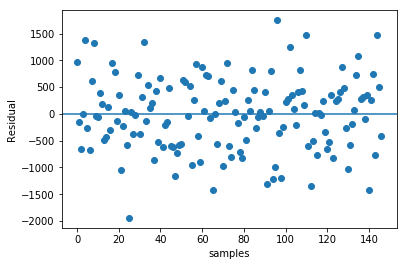

In [11]:
# 残差で確認
residual = test_y - pred_y
axis_x = np.arange(len(residual))
plt.xlabel('samples')
plt.ylabel('Residual')
plt.scatter(axis_x, residual)
plt.axhline(0)
